In [50]:
import os, glob, json
import pickle, dill
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform
from pprint import pprint

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir) ## CHANGE CSID
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)
    
from utils import *
STANZA_DIR

john2
scr1
/john2/scr1/yiweil


'/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed'

# Load utils

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def get_lemmas_with_heads(stanza_json_parse, exclude_punc=True):
    if exclude_punc:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent if w['upos'] != 'PUNCT']
    else:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent]

def get_counts_for_lor(corpus, sample1_ids, priors, save_prefix, 
                       stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner',
                       verbose=False, cache=True, background_only=False, skip_background=False,
                       ngram_range=(1,2), min_df=5, do_lowercase=True, 
                       upos=False, xpos=False, depparse=True, heads=False):
    
    if not cache:
        counts_dict = {}
        if not background_only:
            print(f"Creating count matrix for +/- samples with ngram range {ngram_range}, min_df = {min_df}, lowercasing = {do_lowercase}, upos = {upos}, xpos = {xpos}, depparse = {depparse}, and heads = {heads}...")

            # create text arrays
            corpus1_texts, corpus2_texts = [], []
            for utt in tqdm(corpus.iter_utterances()):
                if utt.id[:2]=='t1':
                    try:
                        json_obj = get_stanza_json(utt,stanza_dir=stanza_dir)
                        if json_obj is not None:
                            subbed_json_obj = sub_url_with_domain(utt)
                            if utt.id in sample1_ids:
                                if upos:
                                    corpus1_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['upos']}"
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                                elif xpos:
                                    corpus1_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['xpos']}"
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                                elif depparse:
                                    corpus1_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['deprel']}"
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                                elif heads:
                                    corpus1_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                                else:
                                    corpus1_texts.append(' '.join([x['lemma'] 
                                                                   if x['lemma'] is not None 
                                                                   else x['text']
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                            else:
                                if upos:
                                    corpus2_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['upos']}"
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                                elif xpos:
                                    corpus2_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['xpos']}"
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                                elif depparse:
                                    corpus2_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}"
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['deprel']}"
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                                elif heads:
                                    corpus2_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                                else:
                                    corpus2_texts.append(' '.join([x['lemma'] 
                                                                   if x['lemma'] is not None 
                                                                   else x['text']
                                                                   for sent in json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT']))
                    except FileNotFoundError:
                        pass
            del corpus # free up memory
            print(f'\tFound {len(corpus1_texts)} non-empty texts in sample 1; {len(corpus2_texts)} non-empty texts in sample 2.')
            if verbose:
                print('\tExample corpus1 texts:',corpus1_texts[:3])
                print('\tExample corpus2 texts:',corpus2_texts[:3])

            # create; save count dictionaries from CV
            for corp_ in ['corpus1','corpus2']:
                vectorizer = CountVectorizer(analyzer='word', ngram_range=ngram_range, 
                                             min_df=min_df, lowercase=do_lowercase)
                X = vectorizer.fit_transform(corpus1_texts) if corp_ == 'corpus1' \
                    else vectorizer.fit_transform(corpus2_texts)
                vocab = vectorizer.get_feature_names()
                counts = np.sum(X,axis=0)
                count_dict = Counter({vocab[i]: counts[0,i] for i in range(len(vocab))
                                  if len(vocab[i]) > 0})
                counts_dict[corp_] = count_dict
                savename = os.path.join('lor_count_mats',
                                     f'{save_prefix}_{corp_}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
    #             if not os.path.exists('lor_count_mats'):
    #                 os.mkdir('lor_count_mats')
                pickle.dump(count_dict,open(savename,'wb'))
                print(f"\tSaved counts of {corp_} (N types = {len(count_dict)}) to {savename}.")
        else:
            print("Skipping directly to creation of background corpus counts matrices.")
        
        if not skip_background:
            # create texts array
            prior_texts = []
            for prior_corp in priors:
                for utt in tqdm(prior_corp.iter_utterances()):
                    json_obj = get_stanza_json(utt)
                    if json_obj is not None:
                        if upos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                         if x['lemma'] is not None 
                                                         else f"{x['text']}_{x['upos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                         if x['lemma'] is not None 
                                                        else f"{x['text']}_{x['xpos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}" 
                                                         if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            prior_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            prior_texts.append(' '.join([x['lemma'] 
                                                         if x['lemma'] is not None 
                                                           else x['text']
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                del prior_corp # free up memory when done iterating
            del priors # free up memory when done iterating
            #del corp_to_analyze['switchboard']
            #del corp_to_analyze['gen_reddit']
            if verbose:
                print('Example prior corpus texts:',prior_texts[:3])

            # create; save count dictionary
            if len(prior_texts) > 0:
                vectorizer_prior = CountVectorizer(analyzer='word', ngram_range=ngram_range, min_df=min_df, 
                                                   lowercase=do_lowercase)
                X_prior = vectorizer_prior.fit_transform(prior_texts)
                vocab_prior = vectorizer_prior.get_feature_names()
                print(len(vocab_prior))
                #pickle.dump(X_prior,open('X_prior.pkl','wb'))
                counts_prior = np.sum(X_prior,axis=0)
                count_dict_prior = Counter({vocab_prior[i]: counts_prior[0,i] for i in range(len(vocab_prior))
                                   if len(vocab_prior[i]) > 0})
                counts_dict['prior'] = count_dict_prior

                savename_prior = os.path.join('lor_count_mats',
                                         f'{save_prefix}_prior_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
                pickle.dump(count_dict_prior,open(savename_prior,'wb'))
                print(f"\tSaved counts of prior (N types = {len(count_dict_prior)}) to {savename_prior}.")
            else:
                print("\tNo prior corpora passed.")
                counts_dict['prior'] = Counter()
        
        return counts_dict
        
    else:
        print("Loading counters from cache...")
        counts_dict = {}
        for save_infix in ['corpus1','corpus2','prior']:
            savename = os.path.join('lor_count_mats',
                                 f'{save_prefix}_{save_infix}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
            try:
                counts_dict[save_infix] = pickle.load(open(savename,'rb'))
            except FileNotFoundError:
                pass
        return counts_dict        

In [6]:
PRIOR_WEIGHT = 1
COUNTS1_WEIGHT = 1 # use for +delta
COUNTS2_WEIGHT = 1

def do_weighted_lor(counts1, counts2, counts_prior, 
                    prior_weight=PRIOR_WEIGHT, counts1_weight=COUNTS1_WEIGHT, counts2_weight=COUNTS2_WEIGHT, 
                    verbose=False):
    
    counts1,counts2 = counts1.copy(),counts2.copy()
    if type(counts1) != Counter:
        counts1 = Counter(counts1)
        counts2 = Counter(counts2)
    prior = counts_prior + counts1 + counts2

    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in prior.keys():
        prior[word] = int(prior[word]/prior_weight + 0.5)

    for word in counts2.keys():
        counts1[word] = int(counts1[word]/counts1_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word]/counts2_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1  = sum(counts1.values())
    n2  = sum(counts2.values())
    nprior = sum(prior.values())
    print("Size of class1:",n1)
    print("Size of class2:",n2)
    print("Size of prior:",nprior)

    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

    if verbose:
        for word in sorted(delta, key=delta.get):
            print(word)
            print("%.3f" % delta[word])
            
    return delta

In [6]:
# og_dir = '/juice/scr/yiweil/Green-American-Lexicon/2_data_exploration'
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# import customized_fighting_words
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

In [7]:
# import importlib 
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# importlib.reload(customized_fighting_words)
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

# Load/filter ConvoKit corpus

Available corpora to load:
* entirety of r/changemyview from inception to 9/24/2021 (`full_cmv`)
* comments-only subset of r/changemyview where comments w/ and without deltas have been evenly matched for length, depth, elapsed time, etc. (`matched_cmv_subsample`)
* subset of the above, further subsetted to comments attached to climate-change-related posts (`matched_cc_cmv_subsample`)
* random sample of posts & comments from top 100 high-activity subreddits (`gen_reddit`)
* switchboard corpus

In [3]:
# LOAD CORPUS

from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/convokit_corpora/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

corp_to_analyze = {'full_cmv': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = utt.meta
                    for key in meta_dict:
                        convo.add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Annotating {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample','full_cmv'}:
            print("Annotating generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
        print("Distribution of generic comments:")
        print(Counter([utt.meta['is_generic'] for utt in corp_to_analyze[corp_name].iter_utterances()
              if utt.id[:2]=='t1']))
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.text = cleanup(utt.text)
            
        print("Annotating removed/deleted comments in {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_removed'] = (utt.text == '[removed]') or (utt.text == '[deleted]')
            
        print("Annotating path information w/ version ignoring OP...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1):
                utt.meta['path_to_outcome_OP_removed'] = get_path_to_outcome_utt(corp_to_analyze[corp_name],
                                                                                 utt, 
                                                                                 ignore_OP=True,
                                                                                 ignore_removed=False)
        
        print("Distribution of valid utterances:")
        print(Counter([is_valid_utt(utt) for utt in corp_to_analyze['full_cmv'].iter_utterances()
                       if utt.id[:2]=='t1']))
        
        print("Distribution of delta outcomes:")
        print(Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if utt.id[:2]=='t1']))
        
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['text_urls'] = get_urls(utt.text)
            utt.meta['url_domains'] = [get_url_domain(u_) for u_ in utt.meta['text_urls']]
            utt.meta['num_urls'] = len([x for x in utt.meta['url_domains'] 
                                        if (x[0] not in domains_to_exclude)
                                        and (x[1] not in domains_to_exclude)])
            utt.meta['has_url'] = utt.meta['num_urls'] > 0

Loading corpus: full_cmv...
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Annotating full_cmv...
Filtering moderators and speakers with usernames ending in '-bot'...
Found 3155486 non-deleted/removed utterances not written by a bot or moderator.


Annotating generic utterances from full_cmv...


3243830it [00:20, 155352.15it/s]


Filtering to 2932326 non-generic comments.
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Distribution of generic comments:
Counter({False: 2905983, True: 253589})
Removing footnotes and in-line embedded text from full_cmv...


3243830it [01:04, 50528.59it/s]


Annotating removed/deleted comments in full_cmv...


3243830it [00:19, 169959.07it/s]


Annotating path information w/ version ignoring OP...


3243830it [00:35, 90219.55it/s]


Distribution of valid utterances:
Counter({True: 2824502, False: 335070})
Distribution of delta outcomes:
Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})


In [25]:
def is_OP_utt(corp,utt):
    if utt.speaker.id == None:
        return False
    return (utt.speaker.id == corp.get_utterance(utt.conversation_id).speaker.id)

def get_utt(utt_id,corp=corp_to_analyze['full_cmv']):
    return corp.get_utterance(utt_id)

# (Copied from utils.py)
def is_valid_utt(utt):
    """
    Returns whether an utterance meets the following criteria: 
    1) is not removed/deleted; 
    2) is not empty; 
    3) is not generic; 
    4) is not written by a bot/moderator.
    """
    return (not utt.meta['is_removed']) and (not is_empty_utt(utt)) and (not utt.meta['is_generic']) \
       and (not utt.meta['written_by_bot']) 

def meets_datapoint_criteria(utt, corp=corp_to_analyze['full_cmv'], exclude_OP=True):
    """
    Returns whether an utterance should be counted when analyzing a subtree datapoint by checking whether:
    1) it is valid (see `is_valid_utt()`);
    2) it is not written by OP;
    3) it is at least 6 tokens OR has a URL.
    """
    if exclude_OP:
        return is_valid_utt(utt) and (not is_OP_utt(corp, utt)) and \
           ((len(utt.text.split())>=6) or \
            (utt.meta['has_url']))
    else:
        return is_valid_utt(utt) and \
           ((len(utt.text.split())>=6) or \
            (utt.meta['has_url']))

# Parsing (w/ Stanza)

Check if any parsing needs to be done:

In [26]:
# Check if non-empty/deleted/generic posts need any parsing
convo_ids = corp_to_analyze['full_cmv'].get_conversation_ids()
print(len(convo_ids))
valid_convo_ids = [convo_id for convo_id in convo_ids
                   if meets_datapoint_criteria(get_utt(convo_id), exclude_OP=True)]
print(len(valid_convo_ids)) # expect 0
valid_convo_ids = [convo_id for convo_id in convo_ids
                   if meets_datapoint_criteria(get_utt(convo_id), exclude_OP=False)]
print(f"Found {len(valid_convo_ids)} valid conversation IDs.")

84258
4107
Found 26094 valid conversation IDs.


In [31]:
processed = glob.glob(os.path.join(STANZA_DIR,'*.json'))
processed_ids = set([x.split('/')[-1].split('.json')[0] for x in processed])
print('Already processed {} utterances.'.format(len(processed)))

#missing_ids = regression_utt_ids.difference(processed_ids)
missing_ids = set(valid_convo_ids).difference(processed_ids)
print("\tFound {} missing ids.".format(len(missing_ids)))
    
if len(missing_ids) > 0:
    print("Creating dataframe with IDs and texts of items not yet processed...")
    df_to_process = pd.DataFrame({
        'id': [id_ for id_ in missing_ids],
        'title_and_text': [' '.join([get_utt(id_).title,
                                     get_utt(id_).text])
                           for id_ in missing_ids]
    })
    savename = 'full_cmv_posts_for_topic_analysis.pkl'
    df_to_process.to_pickle(savename)
    print(f"Saved dataframe to: {savename}")

Already processed 3241311 utterances.
	Found 0 missing ids.


Only continue past this point if missing ids exist:

In [34]:
# import stanza
# stanza.download('en') # download English model
# nlp = stanza.Pipeline('en', use_gpu= True)

In [30]:
# Perform parsing
processed_dirname = f'{STANZA_DIR}'
assert processed_dirname == '/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'

if not os.path.exists(processed_dirname):
    os.mkdir(processed_dirname)

for corp_name in corp_to_process:
    for utt in tqdm(corp_to_process[corp_name].iter_utterances()):
    #     savename = os.path.join(
    #         DISK_IO_DIR,processed_dirname,"{}.json".format(
    #             utt.id))
        savename = os.path.join(processed_dirname,"{}.json".format(
                utt.id))
        if len(utt.text) > 0:
            print(utt.text)
            try:
                doc = nlp(utt.text)
                print('test')
                jsonlist = {'parse': [[{
                                            'id': word.id,
                                            'text': word.text,
                                            'lemma': word.lemma,
                                            'upos': word.upos,
                                            'xpos': word.xpos,
                                            'feats': word.feats,
                                            'head': word.head,
                                            'deprel': word.deprel,
                                            'start_char': word.start_char,
                                            'end_char': word.end_char
                                        } 
                            for word in sent.words]
                            for sent in doc.sentences],
                            'ents': [{
                                        "text": ent.text,
                                        "type": ent.type,
                                        "start_char": ent.start_char,
                                        "end_char": ent.end_char
                                    }
                                    for ent in doc.ents]}
                with open(savename,'w') as f:
                    json.dump(jsonlist,f)
            except AssertionError:
                pass
        #break

1it [00:00,  8.28it/s]


-


0it [00:00, ?it/s]

/


1it [00:00,  8.98it/s]


Perform some file management:

In [ ]:
# zip up within local machine dir
tar -czf stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz stanza_processed_matched_filtered_cc_cmv_corpus

# move to /juice dir
export JUICE_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration
echo $JUICE_DIR # check
mv stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz $JUICE_DIR

# unzip to /juice dir
tar -xzf $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz -C $JUICE_DIR

# move contents to central dir
export STANZA_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output#_with_ner
mv $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus/* $JUICE_DIR/STANZA_DIR/

In [105]:
# Check for corrupted and/or missing json files in unzipped directory
JUICE_DIR='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration'
STANZA_DIR=os.path.join(JUICE_DIR,'combined_stanza_output_with_ner')
all_fnames = glob.glob(os.path.join(STANZA_DIR,'*.json'))
problematic_fnames = []
for fname in tqdm(all_fnames):
    try:
        json.load(open(fname,'r'))
    except EOFError:
        problematic_fnames.append(fname)
print("Found {} problematic json files among {} total files in unzipped /juice dir.".format(
    len(problematic_fnames), len(all_fnames)))

corpus_to_process = corp_to_analyze['matched_cc_cmv_subsample']
ids_needed = [utt.id for utt in corpus_to_process.iter_utterances() if len(utt.text) > 0]
missing_ids = set(ids_needed).difference(set([x.split('/')[-1].split('.json')[0] for x in all_fnames]))
print("Found {} missing ids from {} utterance ids total in corpus to parse.".format(
    len(missing_ids), len(ids_needed)
))

100%|██████████| 6349/6349 [00:05<00:00, 1115.49it/s]

Found 0 problematic json files among 6349 total files in unzipped /juice dir.
Found 0 missing ids from 6349 utterance ids total in corpus to parse.


# Find climate-change related conversations

In [64]:
# def remove_special_chars(s):
#     return re.sub('[^A-Za-z]+', ' ', s)

# def contains_keyword(s,keyword_set,ignore_case=True):
#     if ignore_case:
#         s = s.lower()
#     pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
#     #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
#     return len(set(pat.findall(s)).intersection(keyword_set)) > 0

# with open('../1_data_collection/keywords_high_precision.txt','r') as f:
#     CLIMATE_KEYWORDS = f.read().splitlines()
# print(CLIMATE_KEYWORDS)

# def get_op(corp,convo_idx):
#     return corp.get_utterance(convo_idx)

# def get_op_title(op):
#     return op.meta['title']

# def get_op_text(op):
#     return op.text

['global warming', 'climate change', 'carbon dioxide', 'co2', 'methane', 'fossil fuel', 'climate crisis', 'climate emergency', 'extreme weather', 'clean energy', 'renewable energy', 'cap and trade', 'sea level rise', 'IPCC', 'deforestation', 'permafrost', 'greenhouse gas', 'greenhouse effect', 'green new deal', 'environmentalism', 'EPA']


In [32]:
manual_checked = pd.read_csv('is_cc_related_gold_manual_checked.tsv',sep='\t')
manual_checked['is_true'] = manual_checked['is_true'].apply(
    lambda x: {'f':'false','m':'meta','d':'doom','r':'renewables/energy','v':'vegetarianism',
              'p':'overpopulation','g':'government/politics','c':'conservation','e':'economy',
              'l':'lifestyle','foo':'food (non-vegetarianism)','a':'adaptation',
              'mor':'ethics/morality','gm':'government/politics'}[x]
                if not pd.isnull(x) else 'other')
manual_checked['label'] = manual_checked['label'].apply(lambda x: {'s':'skeptic','st':'indifferent'}[x] 
                                                       if x in {'s','st'} else 'other')
gold_df = manual_checked.loc[manual_checked['is_true']!='false']
climate_convo_idxs_gold = set(gold_df['id'].values)
print(f'Found {len(climate_convo_idxs_gold)} conversations which are manually checked to be true climate convos.')

c_id2other_cc_label = dict(zip(gold_df['id'].values,gold_df['is_true'].values))
for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
    if convo.id not in c_id2other_cc_label:
        c_id2other_cc_label[convo.id] = 'non-cc'
        
for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
    utt.meta['is_cc_related_gold'] = utt.conversation_id in climate_convo_idxs_gold
    utt.meta['other_cc_label'] = c_id2other_cc_label[utt.conversation_id]
for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
    convo.meta['other_cc_label'] = c_id2other_cc_label[convo.id]
print(Counter([utt.meta['is_cc_related_gold'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))
print(Counter([utt.meta['other_cc_label'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))

Found 422 conversations which are manually checked to be true climate convos.


In [34]:
for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
    utt.meta['is_cc_related_gold'] = utt.conversation_id in climate_convo_idxs_gold
    utt.meta['other_cc_label'] = c_id2other_cc_label[utt.conversation_id]
for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
    convo.meta['other_cc_label'] = c_id2other_cc_label[convo.id]
print(Counter([utt.meta['is_cc_related_gold'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))
print(Counter([utt.meta['other_cc_label'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))

3243830it [00:33, 96806.50it/s] 
84258it [00:00, 163533.01it/s]
3243830it [00:05, 636756.20it/s]


Counter({False: 3214504, True: 29326})


3243830it [00:05, 623274.01it/s]


Counter({'non-cc': 3214504, 'other': 5677, 'renewables/energy': 4159, 'meta': 4084, 'vegetarianism': 3685, 'government/politics': 3009, 'overpopulation': 2852, 'doom': 2263, 'conservation': 1637, 'economy': 885, 'lifestyle': 539, 'food (non-vegetarianism)': 267, 'ethics/morality': 167, 'adaptation': 102})


In [ ]:
# Find other keywords related to environment

# Approach 1: Empath

In [53]:
from empath import Empath
lexicon = Empath()

RENEWABLES_SEEDS = ['renewable','solar panel','wind farm','clean energy']
ENVIRO_SEEDS = ['environmentalism','ecosystem','sustainability','natural habitat','habitat loss']
VAX_SEEDS = ['vaccine','vaccination','anti-vax','anti-vaccine','antivax','antivaccine']
#lexicon.create_category("renewables_reddit",RENEWABLES_SEEDS,model="reddit")
#lexicon.create_category("enviro_reddit",ENVIRO_SEEDS,model="reddit")
lexicon.create_category("vax_reddit",VAX_SEEDS,model="reddit")

["vaccination", "vaccines", "anti-vax", "anti-vaxxers", "anti-vaccination", "vaccinations", "anti-vaccine", "antivaxxers", "anti-vaxers", "anti-vaccers", "vaccine", "anti_vaxxers", "anti-vax_movement", "anti-vaxxer", "anti_vaxers", "vaccinating", "anti-vaccine_movement", "antivax", "flu_shots", "vaccinating", "anti_vaccine", "anti-vaccine_people", "Anti-vaxxers", "flu_vaccine", "pro-vaccination", "immunization", "anti_vax", "vax", "anti_vaccers", "vaccinate", "anti_vaccination", "anti-vaccination_movement", "anti-vaccination_people", "mandatory_vaccines", "vaxxing", "vaccinated", "anti-vaxx", "flu_vaccines", "vaxxers", "Jenny_McCarthy", "mandatory_vaccinations", "autism", "anti-vax_people", "antivaxers", "flu_shot", "pro-vaccine", "anti-vax_crowd", "certain_vaccines", "vaxx", "vaccinated", "vaxers", "Vaccines", "vaccinations", "Vaccinations", "pro-vaxxers", "pro_vaccine", "other_vaccines", "medical_community", "anti_vaxxer", "anti-vaxer", "unvaccinated", "antivaxxer", "vaccine", "immun

In [54]:
lexicon.create_category("enviro_nyt",VAX_SEEDS,model="nytimes")

["vaccine", "vaccination", "vaccines", "AZT", "smallpox_vaccine", "antibiotics", "vaccinations", "new_vaccine", "antibiotic", "gene_therapy", "new_drug", "tamoxifen", "hepatitis_B", "clinical_trials", "hepatitis_C", "smallpox", "transfusions", "nevirapine", "clinical_trial", "other_diseases", "such_drugs", "Cipro", "thalidomide", "anthrax_vaccine", "flu_vaccine", "protease_inhibitors", "experimental_drug", "immunization", "H.I.V.", "doses", "influenza", "experimental_drugs", "diabetics", "cervical_cancer", "serious_side_effects", "penicillin", "infection", "infections", "infected_people", "healthy_people", "AIDS_virus", "effective_treatment", "anti-H.I.V._drugs", "oral_vaccine", "antibodies", "AZT", "new_drugs", "new_treatment", "diseases", "vaccinated", "most_patients", "early_detection", "transfusion", "H.I.V._infection", "estrogen", "therapies", "bone_marrow_transplants", "standard_treatment", "human_immunodeficiency_virus", "cancer_patients", "blood_transfusions", "screening_test",

In [57]:
VAX_TO_REMOVE={'alternative_medicine','autism','homeopathy','herd_immunity','homeopathy','measles','medical_community',
'medical_establishment','polio','preventable_diseases','quackery'}

In [58]:
VAX_KWS = set(["vaccination", "vaccines", "anti-vax", "anti-vaxxers", "anti-vaccination", "vaccinations", "anti-vaccine", "antivaxxers", "anti-vaxers", "anti-vaccers", "vaccine", "anti_vaxxers", "anti-vax_movement", "anti-vaxxer", "anti_vaxers", "vaccinating", "anti-vaccine_movement", "antivax", "flu_shots", "vaccinating", "anti_vaccine", "anti-vaccine_people", "Anti-vaxxers", "flu_vaccine", "pro-vaccination", "immunization", "anti_vax", "vax", "anti_vaccers", "vaccinate", "anti_vaccination", "anti-vaccination_movement", "anti-vaccination_people", "mandatory_vaccines", "vaxxing", "vaccinated", "anti-vaxx", "flu_vaccines", "vaxxers", "Jenny_McCarthy", "mandatory_vaccinations", "autism", "anti-vax_people", "antivaxers", "flu_shot", "pro-vaccine", "anti-vax_crowd", "certain_vaccines", "vaxx", "vaccinated", "vaxers", "Vaccines", "vaccinations", "Vaccinations", "pro-vaxxers", "pro_vaccine", "other_vaccines", "medical_community", "anti_vaxxer", "anti-vaxer", "unvaccinated", "antivaxxer", "vaccine", "immunized", "vaccinate", "herd_immunity", "vaxxer", "forced_vaccinations", "immunize", "mandatory_vaccination", "anti_science", "anti-vaxxer_movement", "measles", "anti-vaccer", "homeopathy", "flu_vaccination", "Vaccination", "MMR_vaccine", "immunizations", "immunizing", "polio", "HPV_vaccine", "preventable_diseases", "medical_establishment", "measles_vaccine", "childhood_vaccines", "alternative_medicine", "quackery", "vaccinated_children", "vax"])

In [59]:
VAX_KWS = VAX_KWS.difference(VAX_TO_REMOVE)

In [61]:
#VAX_KWS

In [48]:
RENEWABLE_KWS = set(['renewable','renewables','solar power','wind power','hydropower','solar and wind',
                'biofuel','biofuels','carbon capture','solar/wind','clean energy','geothermal','hydroelectric',
                'hydroelectricity','solar farm','solar farms','wind farm','wind farms','alternative enegry',
                'green energy','solar energy','wind energy'])
ENVIRO_KWS = set(["sustainability", "environmentalism", "ecosystem", "ecosystems","eco-system",
                 "biodiversity",'environmental','deforestation'])

In [49]:
renewable_convos = [convo for convo in corp_to_analyze[corp_name].iter_conversations()
                   if contains_keyword(convo.meta['title'],RENEWABLE_KWS)]
renewable_convo_ids = set([c.id for c in renewable_convos])
renewable_utts = [utt for utt in corp_to_analyze[corp_name].iter_utterances()
                 if utt.conversation_id in renewable_convo_ids]
len(renewable_utts)

1843

In [50]:
Counter([utt.meta['is_awarded_delta'] for utt in renewable_utts])

Counter({False: 1828, True: 15})

In [65]:
enviro_convos = [convo for convo in corp_to_analyze[corp_name].iter_conversations()
                   if contains_keyword(convo.meta['title'],CLIMATE_KEYWORDS)]
enviro_convo_ids = set([c.id for c in enviro_convos])
enviro_utts = [utt for utt in corp_to_analyze[corp_name].iter_utterances()
                 if utt.conversation_id in enviro_convo_ids]
len(enviro_utts)

22331

In [66]:
Counter([utt.meta['is_awarded_delta'] for utt in enviro_utts])

Counter({False: 22041, True: 290})

In [62]:
vax_convos = [convo for convo in corp_to_analyze[corp_name].iter_conversations()
                   if contains_keyword(convo.meta['title'],VAX_KWS)]
vax_convo_ids = set([c.id for c in vax_convos])
vax_utts = [utt for utt in corp_to_analyze[corp_name].iter_utterances()
                 if utt.conversation_id in vax_convo_ids]
len(vax_utts)

32564

In [ ]:
Counter([utt.meta['is_awarded_delta'] for utt in vax_utts])

In [18]:
for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv','matched_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            assert 'is_cc_related' in utt.meta

756789it [00:01, 617000.07it/s]


In [14]:
# climate_convo_idxs = []
# lingering_posts = []
# for utt in tqdm(filtered_cmv_corpus.iter_utterances()):
#     if utt.id[:2] == 't3':
#         print('test') # Oh, right, I deleted OPs in the subsamples b/c those automatically can't get deltas
#         lingering_posts.append(utt)
#         op_idx = utt.id
#         op = get_op(filtered_subsample,op_idx)
#         op_title = get_op_title(op)
#         if contains_keyword(op_title, set(CLIMATE_KEYWORDS)):
#             climate_convo_idxs.append(op_idx)
# len(climate_convo_idxs)

In [15]:
# # Add meta field for whether utterance belongs to climate change-related conversation
# for utt in tqdm(corpus.iter_utterances()):
#     utt.meta['is_cc_related'] = utt.conversation_id in \
#                                 set(climate_convo_idxs)

# Stance labeling

In [71]:
# # Select random sample to manually classify
# sample_convo_ids = np.random.choice(climate_convo_idxs,size=150,replace=False)
# len(sample_convo_ids),sample_convo_ids[:3]

(150, array(['t3_an59pr', 't3_563ep2', 't3_2ylc5a'], dtype='<U9'))

In [83]:
# # Write to file to manually label
# pd.DataFrame({
#     'id': sample_convo_ids,
#     'title': [corpus.get_utterance(convo_id).meta['title'] 
#              if 'title' in corpus.get_utterance(convo_id).meta else -1
#              for convo_id in sample_convo_ids],
#     'label': [-1]*len(sample_convo_ids)
# }).to_csv('cmv_climate_posts_to_manually_stance_label.csv',header=True,index=False)

In [3]:
# Read in labels
sample_with_labels_df = pd.read_csv('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
cmv_climate_posts_with_manual_stance_labels.csv',header=0)
sample_with_labels_df.head()

id  \
0  t3_an59pr   
1  t3_563ep2   
2  t3_2ylc5a   
3  t3_ehwa7r   
4  t3_bg5fnj   

                                                                                            title  \
0  CMV: The most ethical course of action is to take very drastic measures to stop climate change   
1                                                CMV: I will not have kids due to climate change.   
2                                                          CMV:Climate change is a scam by the UN   
3     Politicians who don't believe in climate change should not be allowed to hold public office   
4                CMV: Patanogia donating $10 Million towards climate change sets a bad precedent.   

  label  
0     p  
1    ps  
2     a  
3    ps  
4    an

In [4]:
# Aggregate fine-grained annotations into one of 3 macro categories
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['label'].apply(lambda x: x[0])
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['manual_label_macro'].apply(
    lambda x: {'p':'pro',
               'a':'anti',
               'n':'neutral'}[x] if x in {'p','a','n'} else x)
sample_with_labels_df['manual_label_macro'].value_counts()

pro        92
anti       38
neutral    20
Name: manual_label_macro, dtype: int64

In [5]:
sample_with_labels_df['label'].value_counts()/sum(sample_with_labels_df['label'].value_counts())

ps    0.380000
a     0.246667
p     0.126667
n     0.126667
pa    0.106667
na    0.006667
an    0.006667
Name: label, dtype: float64

In [6]:
# Plot distribution over time
# x-axis: time
# y-axis: conversation stance

from datetime import datetime
def get_convo_time(convo_id):
    return corpus.get_utterance(convo_id).meta['created']

sample_with_labels_df['time'] = sample_with_labels_df['id'].apply(lambda x: get_convo_time(x))
sample_with_labels_df['year'] = sample_with_labels_df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

sns.displot(data=sample_with_labels_df,x='year',hue='manual_label_macro',multiple='stack')
plt.xlabel('')
plt.ylabel('Number of posts')
plt.title('Stance of post titles over time')
sns.despine()
plt.legend(title='Stance of post title', loc='upper left', labels=['neutral', 'anti', 'pro'])

NameError: name 'corpus' is not defined

See how many of each stance got deltas:

In [10]:
stance_labeled_with_deltas = set(deltalog['awarded_utt_id'].values).intersection(
    set(sample_with_labels_df['id'].values))
len(stance_labeled_with_deltas)

0

# Topic analysis

In [38]:
posts = pd.DataFrame({
    'id':[id_ for id_ in valid_convo_ids],
    'title':[get_utt(id_).meta['title']
             for id_ in valid_convo_ids],
    'text':[get_utt(id_).text
            for id_ in valid_convo_ids]})
posts['cleaned_title'] = posts['title'].apply(lambda x: re.sub('[,\.!?]', '', x.lower()))
posts['cleaned_text'] = posts['text'].apply(lambda x: re.sub('[,\.!?]', '', x.lower()))
posts['cleaned_full'] = posts['cleaned_title'] + ' ' + posts['cleaned_text']
posts.to_csv('posts_for_topic_analysis.tsv',sep='\t',header=True,index=False)
posts.shape

(26094, 6)

In [39]:
posts['lemmas'] = posts['id'].apply(lambda x: 
                                    get_stanza_lemmas(get_utt(x)))
posts['lemmas'] = posts['lemmas'].apply(lambda x: [w for w in x if w is not None])

Use most frequent words from Switchboard and General Reddit corpora as another source of stopwords to eliminate from LDA:

In [41]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'cmv', 'view', 'say', 'thing', 'person', 'someone', 'change', 'know', 
                   'people', 'will', 'one', 'even', 'make', 'think', 'believe'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /sailhome/yiweil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# background_texts = pd.DataFrame({
#     'id': [utt.id for utt in corp_to_analyze['switchboard'].iter_utterances()]\
#         + [utt.id for utt in corp_to_analyze['gen_reddit'].iter_utterances()],
#     'text':[utt.text for utt in corp_to_analyze['switchboard'].iter_utterances()]\
#         + [utt.text for utt in corp_to_analyze['gen_reddit'].iter_utterances()]
# })
# background_texts['text'] = background_texts['text'].apply(lambda x: re.sub('[,\.!?]', '', x.lower()))

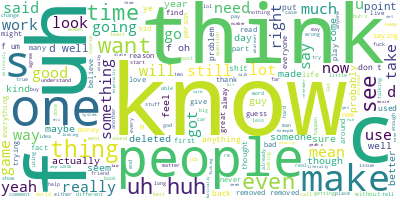

In [11]:
# from wordcloud import WordCloud
# # Join the different processed titles together.
# long_string = ','.join(list(background_texts['text'].values))
# # Create a WordCloud object
# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# # Generate a word cloud
# wordcloud.generate(long_string)
# # Visualize the word cloud
# wordcloud.to_image()

## Approach 1: LDA

In [110]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'cmv', 'view', 'say', 'thing', 'person', 'someone', 'change', 'know', 
                   'people', 'will', 'one', 'even', 'make', 'think', 'believe'])

# def sent_to_tokens(sentences):
#     for sentence in sentences:
#         # deacc=True removes punctuations
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# def remove_stopwords_from_tokens(texts,stopword_set):
#     print('cmv' in stopword_set)
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stopword_set] for doc in texts]

# def remove_stopwords_from_lemmas(texts,stopword_set):
#     print('cmv' in stopword_set)
#     return [[word for word in doc_lemmas 
#              if (word not in stopword_set) and (word is not None)] for doc_lemmas in texts]

# data_words = posts['lemmas'].values.tolist()
# print('far' in stop_words)
# data_words = remove_stopwords_from_lemmas(data_words,set(stop_words))
# counted_non_stop_words = Counter(flatten(data_words))
# top_non_stop_words = sorted(counted_non_stop_words.items(),key=lambda x:x[1],reverse=True)

# background_data = background_texts['text'].values.tolist()
# background_data_words = list(sent_to_tokens(background_data))
# background_data_words = remove_stopwords_from_tokens(background_data_words,set(stop_words))
# background_data_words = [item for sublist in background_data_words for item in sublist]
# counted_background_words = Counter(background_data_words)
# top_background_words = sorted(counted_background_words.items(),key=lambda x:x[1],reverse=True)

# # stop_words.extend([x[0] for x in top_background_words[:100]]+[x[0] for x in top_non_stop_words[:100]])
# # stop_words = set(stop_words)
# # 'cmv' in stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /sailhome/yiweil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


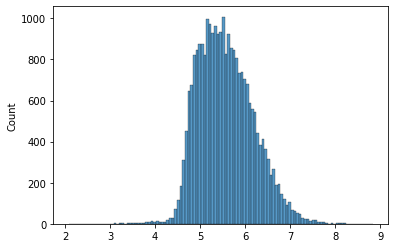

In [72]:
# Restrict to ~e**5 first lemmas

sns.histplot(posts['lemmas'].apply(lambda x: np.log(len(x))).values)

In [78]:
np.log(math.e**5)

5.0

In [79]:
math.e**5

148.41315910257657

Use doc-frequency threshold as another way of finding stopwords to remove:

In [107]:
data_words = posts['lemmas'].values.tolist()
post_counts_per_word = defaultdict(int)
for doc in tqdm(data_words):
    doc_words = set(doc)
    for w in doc_words:
        post_counts_per_word[w] += 1

100%|██████████| 26094/26094 [00:02<00:00, 8806.04it/s]


In [224]:
len(data_words)*.1

2609.4

In [225]:
sorted(post_counts_per_word.items(),key=lambda x:x[1],reverse=True)[200]

('cause', 3287)

In [245]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'cmv', 'view', 'say', 'thing', 'person', 'someone', 'change', 'know', 
                   'people', 'will', 'one', 'even', 'make', 'think', 'believe'])

print('far' in stop_words)
print(stop_words)
stop_words = set(stop_words)
stop_words |= set([x[0] for x in sorted(post_counts_per_word.items(),key=lambda x:x[1],reverse=True)[:200]])
print('far' in stop_words)
print(stop_words)
# data_words = posts.loc[posts['lemmas'].apply(lambda x: len(x)>0)]['lemmas'].values.tolist()
# data_words = remove_stopwords_from_lemmas(data_words,set(stop_words))
# print(data_words[:1][0][:30])

# counted_non_stop_words = Counter(flatten(data_words))
# top_non_stop_words = sorted(counted_non_stop_words.items(),key=lambda x:x[1],reverse=True)

False
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'th

In [51]:
#top_non_stop_words[:100]

In [17]:
# top_background_words_set = set([x[0] for x in top_background_words[:100]])
# 'believe' in top_background_words_set

['cmv there be nothing wrong with do what incel call cope # background please '
 'see the link I be be stalk by a incel on reddit he have spend this morning '
 'try to convince I that my life be hopeless and that I should give up '
 'https://ireddit/im7cyd967yf11jpg because I be a 22 year old male virgin '
 'accord to he the fact that I be a 22 year old male virgin prove that I be '
 'very ugly and therefore I have no chance of ever get a girlfriend '
 'https://iredditmediacom/zqei4uwcxk4zwvkpba5-zhhxwkvgmlpgg2qdyja2el4pngfit=crop&crop=faces%2centropy&arh=2&w=960&s=850aefe1790eae2e7dc497221270cf32 '
 'one can technically say that I be a incel since I do not have a girlfriend '
 'but I refuse to associate with incel community accord to he man who can not '
 'get girlfriend be revile by society for be the low ring on the human totem '
 'pole '
 'https://npredditcom/r/advice/comments/92ieoq/how_can_i_get_respect_from_an_adult_brother_who/ '
 'I have be try to refute he point but he refuse

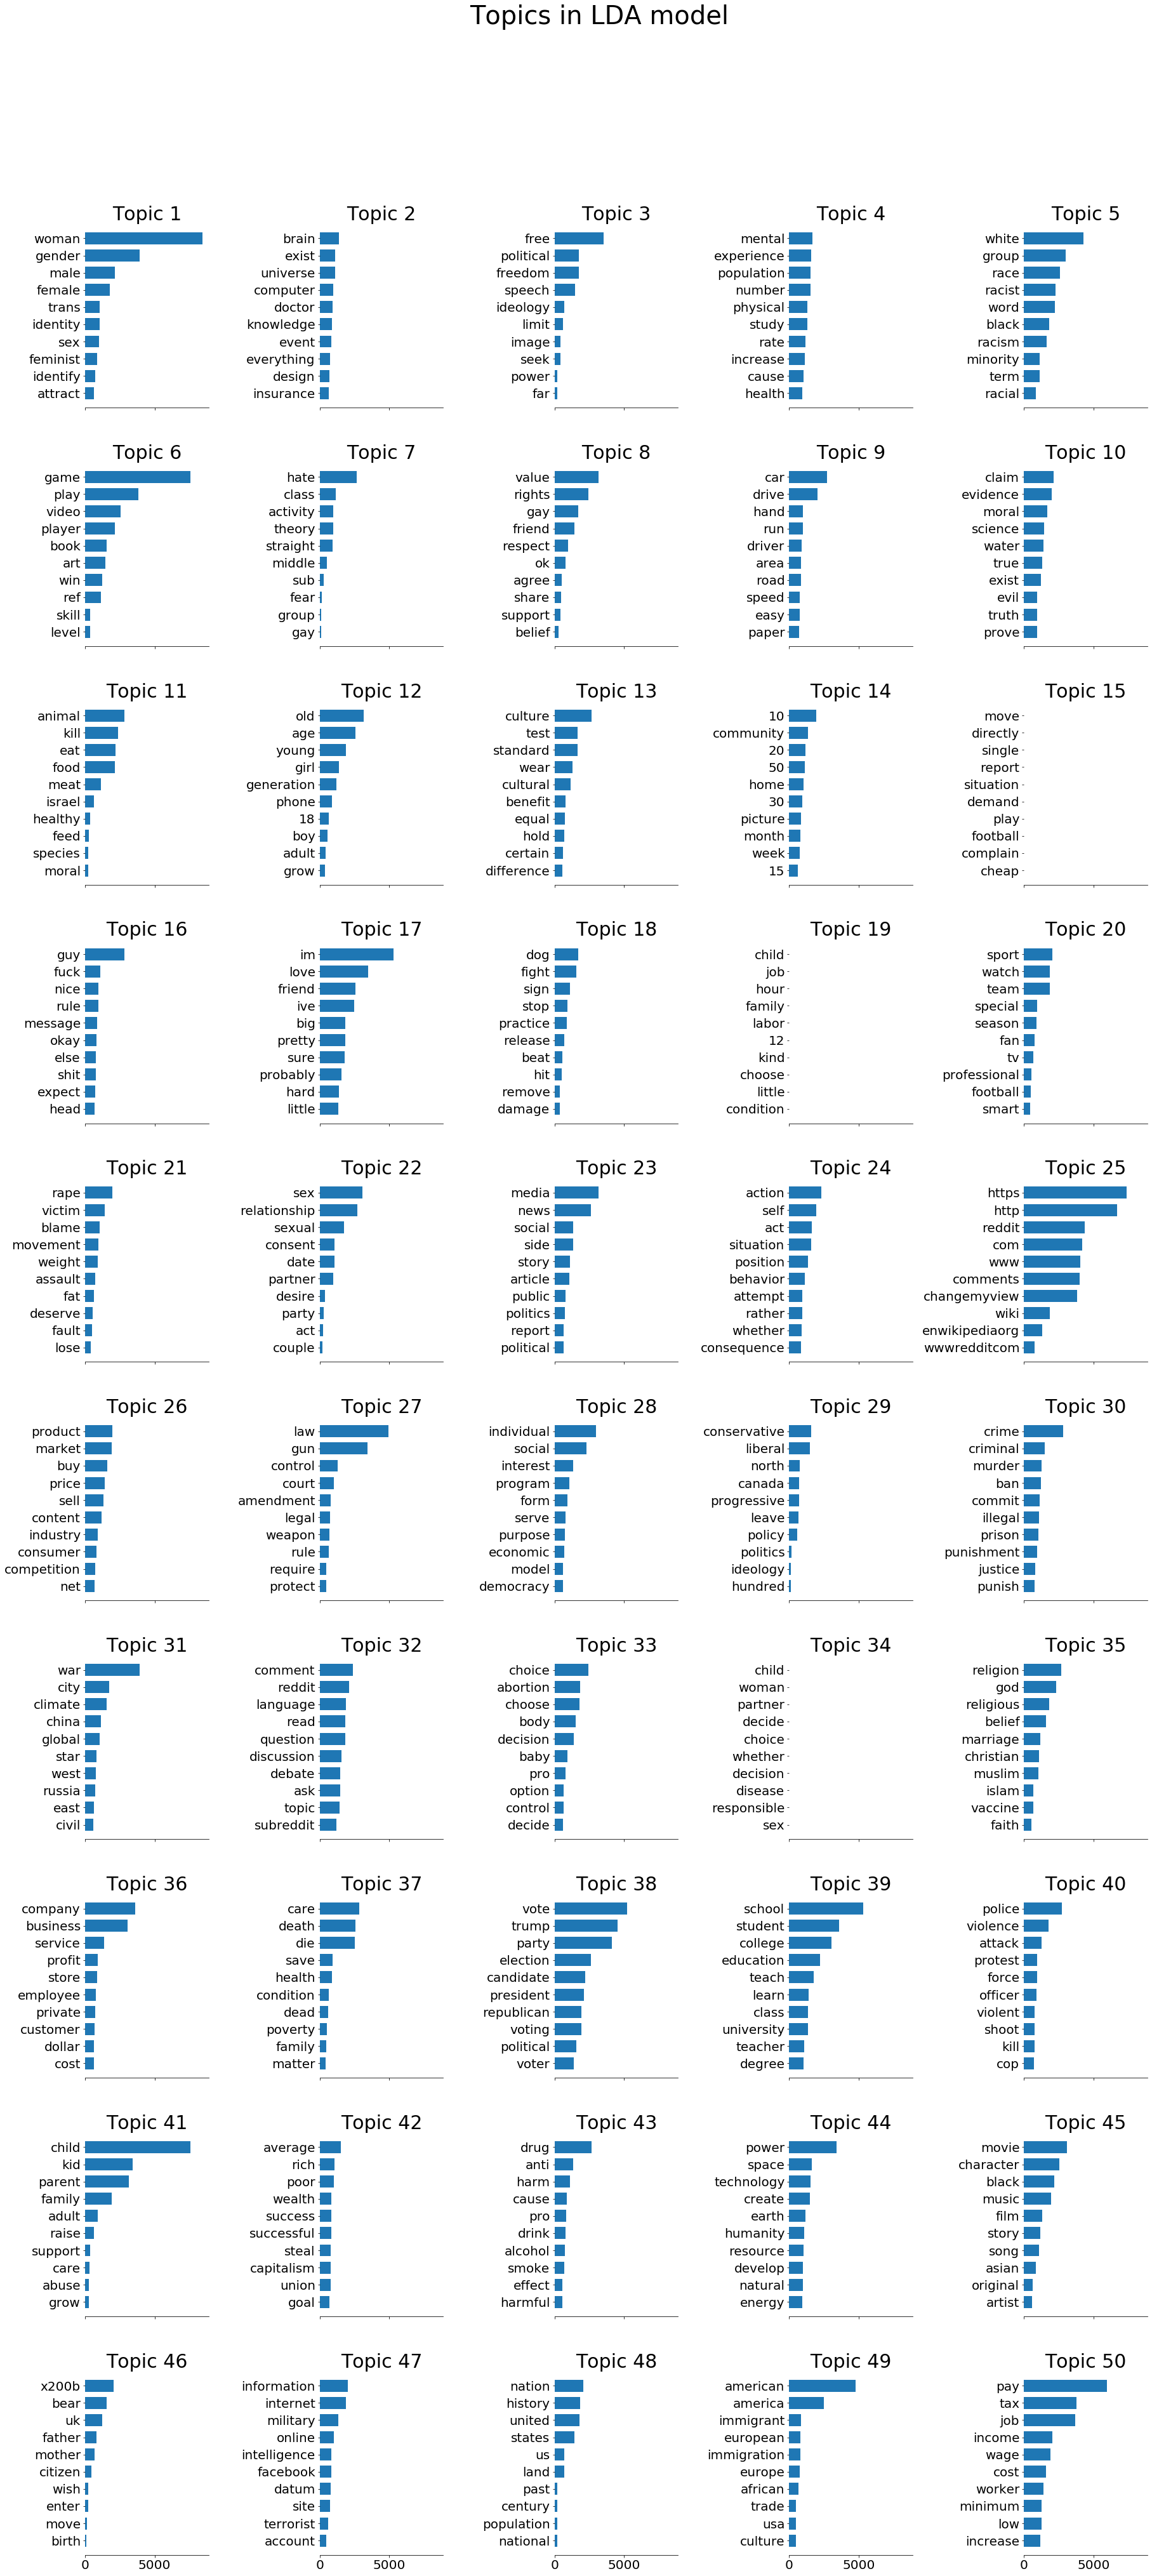

In [272]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_features = 1000
n_components = 50
n_top_words = 10
max_df = 0.3 # [0.5, 0.6, 0.7, 0.8, 0.9]

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(10, int(n_components/10), figsize=(int(30*(n_components/50)), 60), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

LEMMA_THRESH = 1000
data_samples = posts['lemmas'].apply(lambda x: ' '.join(x[:LEMMA_THRESH])).values.tolist()
#data_samples = posts['cleaned_title'].values.tolist()

# Remove Emails
data_samples = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data_samples]
# Remove new line characters
data_samples = [re.sub(r'\s+', ' ', sent) for sent in data_samples]
# Remove distracting single quotes
data_samples = [re.sub(r"\'", "", sent) for sent in data_samples]
pprint(data_samples[:1])

# # Tokenize
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data_words = list(sent_to_words(data_samples))
# print(data_words[:1])

# # Use tf-idf features for NMF.
# print("Extracting tf-idf features for NMF...")
# tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=2, max_features=n_features, stop_words=stop_words)
# t0 = time()
# tfidf = tfidf_vectorizer.fit_transform(data_samples)
# print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(analyzer='word', lowercase=True, #max_df=max_df, 
                                min_df=2, max_features=n_features, stop_words=stop_words)
t0 = time()
data_vectorized = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()


print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_features=%d..."
    % (n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)


t0 = time()
lda.fit_transform(data_vectorized)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [265]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", lda.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(data_vectorized))

# See model parameters
pprint(lda.get_params())

Log Likelihood:  -669258.1729042155
Perplexity:  1375.1492404909236
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 50,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [54]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", lda.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(data_vectorized))

# See model parameters
pprint(lda.get_params())

Log Likelihood:  -16261103.464334108
Perplexity:  588.9383786588345
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 50,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [273]:
# Don't do grid search for now

model = lda

In [154]:
# from sklearn.model_selection import GridSearchCV

# # Define Search Param
# search_params = {'n_components': [10, 15, 20, 25, 30, 35, 40, 45, 50], 'learning_decay': [.5, .7, .9]}

# # Init the Model
# lda = LatentDirichletAllocation()

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)

# # Do the Grid Search
# model.fit(data_vectorized)

In [155]:
# # Best Model
# best_lda_model = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(tf))

In [156]:
# n_topics = [10, 15, 20, 25, 30, 35, 40, 45, 50]
# log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][i]) for i,gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
# log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][i]) for i,gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
# log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][i]) for i,gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# # Show graph
# plt.figure(figsize=(12, 8))
# plt.plot(n_topics, log_likelyhoods_5, label='0.5')
# plt.plot(n_topics, log_likelyhoods_7, label='0.7')
# plt.plot(n_topics, log_likelyhoods_9, label='0.9')
# plt.title("Choosing Optimal LDA Model")
# plt.xlabel("Num Topics")
# plt.ylabel("Log Likelyhood Scores")
# plt.legend(title='Learning decay', loc='best')
# plt.show()

In [274]:
# Create Document — Topic Matrix
lda_output = model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data_samples))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
next_topic = np.argsort(df_document_topic.values, axis=1)[:,-2]
posts['dominant_topic'] = dominant_topic
posts['second_topic'] = next_topic
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['second_topic'] = next_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [275]:
# Show top n keywords for each topic
def show_topics(vectorizer=tf_vectorizer, lda_model=model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=model, n_words=25)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords)
topic2keywords = {int(topic.split(' ')[-1]): ', '.join(df_topic_keywords.loc[topic].values)
                  for topic in df_topic_keywords.index}

Word 0        Word 1      Word 2     Word 3        Word 4  \
Topic 0          woman        gender        male     female         trans   
Topic 1          brain         exist    universe   computer        doctor   
Topic 2           free     political     freedom     speech      ideology   
Topic 3         mental    experience  population     number      physical   
Topic 4          white         group        race     racist          word   
Topic 5           game          play       video     player          book   
Topic 6           hate         class    activity     theory      straight   
Topic 7          value        rights         gay     friend       respect   
Topic 8            car         drive        hand        run        driver   
Topic 9          claim      evidence       moral    science         water   
Topic 10        animal          kill         eat       food          meat   
Topic 11           old           age       young       girl    generation   
Topic 12       culture          test    standard       wear      cultural   
Topic 13            10     community          20         50          home   
Topic 14          move      directly      single     report     situation   
Topic 15           guy          fuck        nice       rule       message   
Topic 16            im          love      friend        ive           big   
Topic 17           dog         fight        sign       stop      practice   
Topic 18         child           job        hour     family         labor   
Topic 19         sport         watch        team    special        season   
Topic 20          rape        victim       blame   movement        weight   
Topic 21           sex  relationship      sexual    consent          date   
Topic 22         media          news      social       side         story   
Topic 23        action          self         act  situation      position   
Topic 24         https          http      reddit        com           www   
Topic 25       product        market         buy      price          sell   
Topic 26           law           gun     control      court     amendment   
Topic 27    individual        social    interest    program          form   
Topic 28  conservative       liberal       north     canada   progressive   
Topic 29         crime      criminal      murder        ban        commit   
Topic 30           war          city     climate      china        global   
Topic 31       comment        reddit    language       read      question   
Topic 32        choice      abortion      choose       body      decision   
Topic 33         child         woman     partner     decide        choice   
Topic 34      religion           god   religious     belief      marriage   
Topic 35       company      business     service     profit         store   
Topic 36          care         death         die       save        health   
Topic 37          vote         trump       party   election     candidate   
Topic 38        school       student     college  education         teach   
Topic 39        police      violence      attack    protest         force   
Topic 40         child           kid      parent     family         adult   
Topic 41       average          rich        poor     wealth       success   
Topic 42          drug          anti        harm      cause           pro   
Topic 43         power         space  technology     create         earth   
Topic 44         movie     character       black      music          film   
Topic 45         x200b          bear          uk     father        mother   
Topic 46   information      internet    military     online  intelligence   
Topic 47        nation       history      united     states            us   
Topic 48      american       america   immigrant   european   immigration   
Topic 49           pay           tax         job     income          wage   

              Word 5        Word 6        Word 7          Word 8  \
Topic 0     identity

In [258]:
topic2keywords[32]

'choice, abortion, choose, body, decision, baby, pro, option, control, decide, woman, birth, responsibility, morally, force, responsible, mother, whether, legal, risk, support, cannot, rights, immoral, agree'

In [276]:
topic_counts_df = posts['dominant_topic'].value_counts()
top_topics = set(topic_counts_df.loc[topic_counts_df > 10].index)
print(len(top_topics), list(top_topics)[:5])

posts['dominant_topic_kws'] = posts['dominant_topic'].apply(lambda x: topic2keywords[x])
posts['second_topic_kws'] = posts['second_topic'].apply(lambda x: topic2keywords[x])
posts['abridged_full'] = posts['lemmas'].apply(lambda x: ' '.join(x[:LEMMA_THRESH]))

exs = posts.loc[posts['dominant_topic'].isin(top_topics)]\
        [['cleaned_title','abridged_full','dominant_topic','dominant_topic_kws','second_topic','second_topic_kws']]\
        .groupby('dominant_topic').sample(10)
exs.to_csv('lda_output_n=50_mindf=2_stopwords=200')

47 [0, 1, 2, 3, 4]


UnicodeEncodeError: 'utf-8' codec can't encode characters in position 1279-1282: surrogates not allowed

Errors:
* WSD failure:
    * shoot, penalty (sports and death/prison sentences)
    * limit, rate, increase (driving, taxes)

In [279]:
posts.loc[posts['dominant_topic']==7]\
    [['cleaned_title','abridged_full','dominant_topic','dominant_topic_kws','second_topic','second_topic_kws']]

cleaned_title  \
65                                                                                          i think that terms like "homophobia" are used too often and not for their intended meaning cmv   
82                                                                                                    cmv: digging up mummies and displaying them in museums in barbaric and disrespectful   
209    cmv: i believe emphasizing that "being gay is born rather than a choice" is irrelevent and gay rights should be the same no matter if homosexuality is born with nurtured or chosen   
227                                                                                                            cmv: the argument "either it's all ok or none of it's ok" is a bad argument   
370                                                         cmv: it is wrong of google to editorialize search results by censoring specific topics no matter how reprehensible they may be   
...                                                                                                                                                                                    ...   
24473                                                                                                                     cmv: masturbating to gay porn does not make me gay and heres why   
24741                                                                                                                             cmv: george soros deserves much more praise than he gets   
24911                                                                                                   i don't care about things (esp social movements) that don't directly affect me cmv   
25885                                                                                                                        i think that a lot of gay people put on a different voice cmv   
26014                                                                                                                         cmv: i believe that the concept of "gay pride" is ridiculous   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

## Topic analysis script

In [ ]:
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import argparse
import pandas as pd
import os

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    fig, axes = plt.subplots(5, int(n_topics/5), figsize=(30, int(30*n_topics/25)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
def main(args):
    
    posts = pd.read_csv(args.input_data_fname,sep='\t',header=0)
    data_samples = posts.loc[posts['lemmas'].apply(lambda x: len(x) > 0)]\
                            ['lemmas'].apply(lambda x: ' '.join(x)).values.tolist()
    
    print(f"Extracting tf features for LDA using max_df = {args.max_df}, max_features = {args.max_features}...")
    tf_vectorizer = CountVectorizer(max_df=args.max_df, min_df=2, 
                                    max_features=args.max_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(data_samples)
    
    # Define Search Params
    search_params = {'n_components': args.n_topics, 
                     'learning_decay': args.learning_decays}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(tf)

    # Plot log likelihood, perplexity as function of search params
    n_topics = search_params['n_components']
    log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][i]) for i,gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
    log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][i]) for i,gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
    log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][i]) for i,gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.tight_layout()
    out_dir = f"topic_analysis_results/max_df={args.max_df}_max_feats={args.max_features}"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    plt.savefig(os.path.join(out_dir,'CV_plot.png'),dpi=200)

    # Write best model parameters
    best_lda_model = model.best_estimator_
    with open(os.path.join(out_dir,'best_params.txt'),'w') as f:
        f.write(f"Best Model's Params:\t{model.best_params_}\n")
        f.write(f"Best Log Likelihood Score:\t{model.best_score_}\n")
        f.write(f"Model Perplexity:\t{best_lda_model.perplexity(tf)}")
        
    tf_feature_names = tf_vectorizer.get_feature_names()
    plot_top_words(best_lda_model, tf_feature_names, args.n_top_words, "Topics in LDA model", 
                   model.best_params_['n_components'])
    
if __name__ == "__main__":
    print('test')
    parser = argparse.ArgumentParser()
    parser.add_argument('--input_data_fname', type=str, default='posts_for_topic_analysis.tsv',
                        help='path to input data')
    parser.add_argument('--n_top_words', type=int, default=20,
                        help='number of words to use for each topic')
    parser.add_argument('--max_df', type=float, default=0.7,
                        help='document frequency pct above which to exclude a word')
    parser.add_argument('--max_features', type=int, default=1000,
                        help='max num features to evaluate')
    parser.add_argument('--n_topics', type=list, default=[10, 15, 20, 25, 30, 35, 40, 45, 50],
                        help='number of topics to evaluate')
    parser.add_argument('--learning_decays', type=list, default=[.5, .7, .9],
                        help='learning decays to evaluate')
    parser.add_argument('--output_dir', type=str,
                        default='topic_analysis_results',
                        help='where to write output')
    args = parser.parse_args()
    
    main(args)

## BERT

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens',device='cuda')
embeddings = model.encode(posts['cleaned_full'].values, show_progress_bar=True)

I1209 16:23:19.603808 140683053111040 SentenceTransformer.py:60] Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens


Batches:   0%|          | 0/283 [00:00<?, ?it/s]

In [11]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/umap/rp_tree.py:469: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_angular_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), none, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/umap/rp_tree.py (476)

File "../../../../../u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/umap/rp_tree.py", line 476:
def make_angular_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_angular_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During:

In [12]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [37]:
# import matplotlib.pyplot as plt

# # Prepare data
# umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
# result = pd.DataFrame(umap_data, columns=['x', 'y'])
# result['labels'] = cluster.labels_

# # Visualize clusters
# fig, ax = plt.subplots(figsize=(20, 10))
# outliers = result.loc[result.labels == -1, :]
# clustered = result.loc[result.labels != -1, :]
# plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
# plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
# plt.colorbar()

In [13]:
assert len(posts) == len(cluster.labels_)
posts['topic'] = cluster.labels_
posts_per_topic = posts.groupby(['topic'], as_index = False).agg({'cleaned_full': ' '.join})

from sklearn.feature_extraction.text import CountVectorizer
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(posts_per_topic.cleaned_full.values, m=len(posts))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .cleaned_full
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "cleaned_full": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, posts_per_topic, n=20)
topic_sizes = extract_topic_sizes(posts)
print(len(topic_sizes))

topic_sizes['example_top_words'] = topic_sizes['topic'].apply(
    lambda x: ', '.join([x[0] for x in top_n_words[x]]))
topic_sizes.reset_index(inplace=True,drop=True)
topic_sizes['topic_ix'] = topic_sizes.index.copy()
topic_sizes # 25, 33

34


topic  Size  \
0      -1  4775   
1      13   707   
2      16   667   
3       9   485   
4      26   366   
5       2   316   
6      20   310   
7      11   186   
8      21   178   
9      31    92   
10      4    91   
11      5    82   
12      8    73   
13     18    67   
14     10    56   
15      3    47   
16      6    42   
17     25    42   
18     22    40   
19     29    38   
20      0    38   
21     23    36   
22     24    36   
23     12    32   
24      1    30   
25     17    27   
26     32    27   
27     28    26   
28     30    26   
29     15    23   
30     19    21   
31     27    19   
32      7    18   
33     14    15   

                                                                                                                                                                                                                example_top_words  \
0                                                                                         world, bad, money, work, government, better, good, https, point, ve, need, things, use, right, free, social, society, lot, view, really   
1                                                                     gender, women, men, trans, sex, female, male, transgender, woman, gay, feminism, man, sexual, girls, girl, genders, feminist, binary, biological, sexuality   
2                                       trump, vote, election, president, voting, party, candidate, democrats, biden, political, republican, voters, republicans, clinton, hillary, sanders, politics, candidates, bernie, donald   
3                                                                  gun, guns, crime, prison, police, punishment, drugs, rape, death, criminals, crimes, drug, alcohol, innocent, illegal, legal, criminal, law, marijuana, victim   
4                                            god, religion, religious, christian, religions, christianity, jesus, bible, belief, atheism, atheist, christians, moral, beliefs, morality, islam, existence, faith, evidence, exist   
5                                                         white, black, racism, race, racist, racial, african, word, culture, color, blacks, police, americans, skin, asian, minorities, races, privilege, discrimination, whites   
6                                                                                  wage, minimum, tax, income, money, wealth, pay, rich, taxes, economy, jobs, government, work, cost, ubi, rate, million, price, wages, business   
7                                                              abortion, fetus, pro, mother, child, pregnancy, baby, murder, life, woman, choice, abortions, birth, pregnant, human, rape, fetuses, conception, killing, autonomy   
8                                                   students, school, student, college, math, classes, high, class, learning, schools, grade, degree, education, teachers, skills, learn, grades, english, university, professors   
9                                                                           movie, film, plot, movies, character, story, star, rey, characters, series, anime, wars, harry, söze, films, genie, marvel, civilization, zelda, dark   
10                                                                 sandwich, cheese, food, pizza, chips, fries, eat, sauce, chocolate, potato, pasta, chopsticks, hot, butter, potatoes, bread, french, cooking, sandwiches, cook   
11                                                                meat, animals, animal, vegan, eat, eating, vegetarian, veganism, diet, vegans, food, farming, factory, moral, killing, beef, farms, pain, veggie, vegetarianism   
12                                                                           cars, car, driving, traffic, lane, road, drivers, speed, driver, drive, safety, parking, light, lights, spot, windows, stop, vehicle, red, accidents   
13                                                   climate, warming, global, emissions, change, weather, carbon, energy, nuclear, 

In [18]:
topiclabels = """other, gender, politics, crime, religion, race, economy, abortion,
education, moves, food, vegetarianism, driving, climate change, vaccines,
household, pets, ?, sports, tech, canada, aliens, AI, relationships, weight loss,
international relations, anime?, music, social media, ??, tipping, social media 2, gaming, ???"""
topiclabels = [l.strip().replace(',','') for l in re.split(r', |\n',topiclabels)]
assert len(topiclabels) == len(set(topiclabels))
topiclabels

['other',
 'gender',
 'politics',
 'crime',
 'religion',
 'race',
 'economy',
 'abortion',
 'education',
 'moves',
 'food',
 'vegetarianism',
 'driving',
 'climate change',
 'vaccines',
 'household',
 'pets',
 '?',
 'sports',
 'tech',
 'canada',
 'aliens',
 'AI',
 'relationships',
 'weight loss',
 'international relations',
 'anime?',
 'music',
 'social media',
 '??',
 'tipping',
 'social media 2',
 'gaming',
 '???']

In [19]:
topic_sizes['name'] = topic_sizes['topic_ix'].apply(lambda x: topiclabels[x])
topic_sizes

topic  Size  \
0      -1  4775   
1      13   707   
2      16   667   
3       9   485   
4      26   366   
5       2   316   
6      20   310   
7      11   186   
8      21   178   
9      31    92   
10      4    91   
11      5    82   
12      8    73   
13     18    67   
14     10    56   
15      3    47   
16      6    42   
17     25    42   
18     22    40   
19     29    38   
20      0    38   
21     23    36   
22     24    36   
23     12    32   
24      1    30   
25     17    27   
26     32    27   
27     28    26   
28     30    26   
29     15    23   
30     19    21   
31     27    19   
32      7    18   
33     14    15   

                                                                                                                                                                                                                example_top_words  \
0                                                                                         world, bad, money, work, government, better, good, https, point, ve, need, things, use, right, free, social, society, lot, view, really   
1                                                                     gender, women, men, trans, sex, female, male, transgender, woman, gay, feminism, man, sexual, girls, girl, genders, feminist, binary, biological, sexuality   
2                                       trump, vote, election, president, voting, party, candidate, democrats, biden, political, republican, voters, republicans, clinton, hillary, sanders, politics, candidates, bernie, donald   
3                                                                  gun, guns, crime, prison, police, punishment, drugs, rape, death, criminals, crimes, drug, alcohol, innocent, illegal, legal, criminal, law, marijuana, victim   
4                                            god, religion, religious, christian, religions, christianity, jesus, bible, belief, atheism, atheist, christians, moral, beliefs, morality, islam, existence, faith, evidence, exist   
5                                                         white, black, racism, race, racist, racial, african, word, culture, color, blacks, police, americans, skin, asian, minorities, races, privilege, discrimination, whites   
6                                                                                  wage, minimum, tax, income, money, wealth, pay, rich, taxes, economy, jobs, government, work, cost, ubi, rate, million, price, wages, business   
7                                                              abortion, fetus, pro, mother, child, pregnancy, baby, murder, life, woman, choice, abortions, birth, pregnant, human, rape, fetuses, conception, killing, autonomy   
8                                                   students, school, student, college, math, classes, high, class, learning, schools, grade, degree, education, teachers, skills, learn, grades, english, university, professors   
9                                                                           movie, film, plot, movies, character, story, star, rey, characters, series, anime, wars, harry, söze, films, genie, marvel, civilization, zelda, dark   
10                                                                 sandwich, cheese, food, pizza, chips, fries, eat, sauce, chocolate, potato, pasta, chopsticks, hot, butter, potatoes, bread, french, cooking, sandwiches, cook   
11                                                                meat, animals, animal, vegan, eat, eating, vegetarian, veganism, diet, vegans, food, farming, factory, moral, killing, beef, farms, pain, veggie, vegetarianism   
12                                                                           cars, car, driving, traffic, lane, road, drivers, speed, driver, drive, safety, parking, light, lights, spot, windows, stop, vehicle, red, accidents   
13                                                   climate, warming, global, emissions, change, weather, carbon, energy, nuclear, 

In [22]:
topic_sizes[['name','example_top_words','Size']]

name  \
0                     other   
1                    gender   
2                  politics   
3                     crime   
4                  religion   
5                      race   
6                   economy   
7                  abortion   
8                 education   
9                     moves   
10                     food   
11            vegetarianism   
12                  driving   
13           climate change   
14                 vaccines   
15                household   
16                     pets   
17                        ?   
18                   sports   
19                     tech   
20                   canada   
21                   aliens   
22                       AI   
23            relationships   
24              weight loss   
25  international relations   
26                   anime?   
27                    music   
28             social media   
29                       ??   
30                  tipping   
31           social media 2   
32                   gaming   
33                      ???   

                                                                                                                                                                                                                example_top_words  \
0                                                                                         world, bad, money, work, government, better, good, https, point, ve, need, things, use, right, free, social, society, lot, view, really   
1                                                                     gender, women, men, trans, sex, female, male, transgender, woman, gay, feminism, man, sexual, girls, girl, genders, feminist, binary, biological, sexuality   
2                                       trump, vote, election, president, voting, party, candidate, democrats, biden, political, republican, voters, republicans, clinton, hillary, sanders, politics, candidates, bernie, donald   
3                                                                  gun, guns, crime, prison, police, punishment, drugs, rape, death, criminals, crimes, drug, alcohol, innocent, illegal, legal, criminal, law, marijuana, victim   
4                                            god, religion, religious, christian, religions, christianity, jesus, bible, belief, atheism, atheist, christians, moral, beliefs, morality, islam, existence, faith, evidence, exist   
5                                                         white, black, racism, race, racist, racial, african, word, culture, color, blacks, police, americans, skin, asian, minorities, races, privilege, discrimination, whites   
6                                                                                  wage, minimum, tax, income, money, wealth, pay, rich, taxes, economy, jobs, government, work, cost, ubi, rate, million, price, wages, business   
7                                                              abortion, fetus, pro, mother, child, pregnancy, baby, murder, life, woman, choice, abortions, birth, pregnant, human, rape, fetuses, conception, killing, autonomy   
8                                                   students, school, student, college, math, classes, high, class, learning, schools, grade, degree, education, teachers, skills, learn, grades, english, university, professors   
9                                                                           movie, film, plot, movies, character, story, star, rey, characters, series, anime, wars, harry, söze, films, genie, marvel, civilization, zelda, dark   
10                                                                 sandwich, cheese, food, pizza, chips, fries, eat, sauce, chocolate, potato, pasta, chopsticks, hot, butter, potatoes, bread, french, cooking, sandwiches, cook   
11                                                                meat, animals, animal, vegan, eat, eating, vegetarian, veganism, diet, vegans, food, farming, factory, moral, killing, beef

In [20]:
topic_no2topic_name = dict(zip(topic_sizes['topic'].values,topic_sizes['name'].values))
posts['topic_name'] = posts['topic'].apply(lambda x: topic_no2topic_name[x])
posts['gold_cc_label'] = posts['id'].apply(lambda x: corp_to_analyze['matched_cmv_subsample'].get_utterance(x)\
                                          .meta['is_cc_related_gold'])
posts['other_cc_label'] = posts['id'].apply(lambda x: corp_to_analyze['matched_cmv_subsample'].get_utterance(x)\
                                          .meta['other_cc_label'])
posts.to_csv('topic_categorized_regression_posts.tsv',sep='\t',header=True,index=False)

In [25]:
print('\n'.join(posts.loc[(posts['topic_name']=='climate change') &
         (posts['gold_cc_label']==False)]\
[['id','title','topic_name','gold_cc_label','other_cc_label']]['title'].values))

"Nuclear power is bad", CMV
CMV: Scientific articles are frequently a bit off base, misleading, or even downright wrong about some issues, and it isn't in the slightest "anti-science" to say so.
CMV: Andrew Yang's thorium nuclear vision is bullshit
CMV: If a total catastrophic breakdown of society were to happen, liberals would be primarily useless.
CMV: If America had dropped the atomic bomb in a less populated (or even unpopulated) area of Japan, then the Japanese Empire would have surrendered anyway. There was no need to kill so many innocent people.
CMV: While it's not technically too late to mitigate climate change, the conditions required to do so are not going to happen in the time we have left, and we're doomed.
CMV: Environmental movements like Extinction Rebellion do more to harm their cause than help.
CMV: Any free market, given enough time, will inevitably end up destroying itself.
CMV: A "world government" or equivalent organisation is absolutely necessary to create and en

In [30]:
posts.loc[(posts['topic_name']=='other') &
         (posts['gold_cc_label']==True)]\
[['id','title','topic_name','gold_cc_label','other_cc_label']]#['title'].values

id  \
0     t3_36ncax   
73    t3_2vgdvl   
507   t3_nkqd08   
842   t3_dqltww   
963   t3_nsbsx4   
...         ...   
8152  t3_n62crf   
8177  t3_puk9rq   
8216  t3_h7icuw   
8662  t3_5irmi8   
8703  t3_olry48   

                                                                                                                                                                                                                                                                      title  \
0                                                                                                                                                                                                                                                   CMV: the Earth is alive   
73                                                                                                                                                                                     CMV: "Planet" should not be part of the Triple Bottom Line (People, Planet, Profit).   
507                                                                                                                                                                                                     CMV: Governments should encourage and incentivise plant based diets   
842                                                                                                                                                           CMV: A plastic tax is the only reasonable way to reduce production and limit microplastics in the environment   
963                                                                                                                                                                                      CMV: The current population boom in many parts of the Western USA is unsustainable   
...                                                                                                                                                                                                                                                                     ...   
8152                                                                                                                                                                                                                                   Cmv: Nuclear energy is just the best   
8177                                                                                                                                                                                                                            CMV: The left has hijacked environmentalism   
8216                                                                                                                                                                        CMV: All modern technology except medicine is mainly useful for people living in cold countries   
8662                                                                                                                         CMV: Climate change isn't something 99% of the population should worry about because the ingenuity of the other 1% will fix it in 50-100 years   
8703  CMV: Residents of California should be planting more trees, grass, and foliage, as well as continuing to irrigate versus transitioning to desertscape/xeriscapes with zero to little irrigation. We are currently accelerating the transition to a desert enviroment.   

     topic_name  gold_cc_label     other_cc_label  
0         other           True              other  
73        other           True              other  
507       other           True      vegetarianism  
842       other           True       conservation  
963       other           True     overpopulation  
...         ...            ...                ...  
8152      other           True  renewables/energy  
8177      other           True               meta  
8216      other           True       conservation  
8662      o

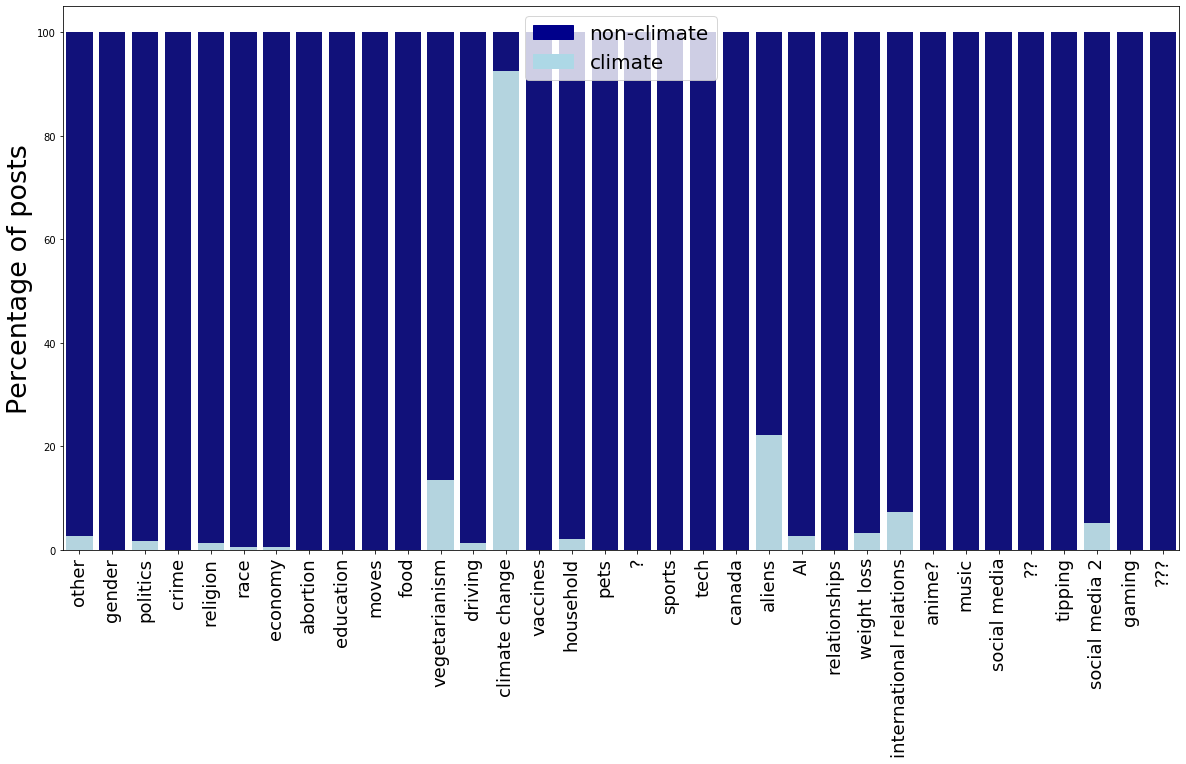

In [21]:
# TO DO: make barplot
import matplotlib.patches as mpatches

to_plot_df = pd.DataFrame({
    'topic_id':topic_sizes['topic'].values,
    'size':topic_sizes['Size'].values-[Counter([corp_to_analyze['matched_cmv_subsample'].get_conversation(c_id)\
                                   .meta['is_cc_related_gold'] 
             for c_id in posts.loc[posts['topic']==topic_id]['id'].values])[True] 
                         for topic_id in topic_sizes['topic'].values],
    'topic_name':topic_sizes['name'].values,
    'type':['non-climate posts']*len(topic_sizes)})
to_plot_df = to_plot_df.append(pd.DataFrame({
    'topic_id':topic_sizes['topic'].values,
    'size':[Counter([corp_to_analyze['matched_cmv_subsample'].get_conversation(c_id)\
                                   .meta['is_cc_related_gold'] 
             for c_id in posts.loc[posts['topic']==topic_id]['id'].values])[True] 
                         for topic_id in topic_sizes['topic'].values],
    'topic_name':topic_sizes['name'].values,
    'type':['climate posts']*len(topic_sizes)}))
to_plot_df['log_size'] = to_plot_df['size'].apply(lambda x: np.log(x))

fig, ax = plt.subplots(figsize=(20, 10))

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = to_plot_df.groupby('topic_name')['size'].sum().reset_index().copy()
cc = to_plot_df[to_plot_df.type=='climate posts'].sort_values('topic_name').copy()
total['normed_size'] = [i / j * 100 for i,j in zip(total['size'], total['size'])]
cc['normed_size'] = [i / j * 100 for i,j in zip(cc['size'], total['size'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="topic_name",  y="normed_size", data=total, color='darkblue',order=topic_sizes['name'].values)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="topic_name", y="normed_size", data=cc, estimator=sum, ci=None, color='lightblue',
                  order=topic_sizes['name'].values)

# add legend
top_bar = mpatches.Patch(color='darkblue', label='non-climate')
bottom_bar = mpatches.Patch(color='lightblue', label='climate')
plt.legend(handles=[top_bar, bottom_bar],fontsize=20)

#sns.barplot(data=to_plot_df,x='topic_name',y='log_size',hue='type',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,size=18)
ax.set_xlabel('')
ax.set_ylabel('Percentage of posts',size=27)

# show the graph
plt.savefig('figs/pct_climate_posts_per_topic_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

In [24]:
for topic_id in topic_sizes['topic'].values:
    counts = Counter([corp_to_analyze['matched_cmv_subsample'].get_conversation(c_id).meta['is_cc_related_gold'] 
             for c_id in posts.loc[posts['topic']==topic_id]['id'].values])
    print(f"Distribution of cc-related conversations (gold) in cluster {topic_id}:",
          counts)
    if len(counts) > 1:
        print(f"\tDistribution of other cc topics (gold) in cluster {topic_id}:",
              Counter([corp_to_analyze['matched_cmv_subsample'].get_conversation(c_id).meta['other_cc_label'] 
                 for c_id in posts.loc[posts['topic']==topic_id]['id'].values]))

Distribution of cc-related conversations (gold) in cluster -1: Counter({False: 5294, True: 133})
	Distribution of other cc topics (gold) in cluster -1: Counter({'non-cc': 5366, 'other': 12, 'vegetarianism': 10, 'conservation': 8, 'overpopulation': 7, 'doom': 5, 'meta': 5, 'renewables/energy': 4, 'economy': 4, 'lifestyle': 3, 'government/politics': 3})
Distribution of cc-related conversations (gold) in cluster 10: Counter({False: 278, True: 1})
	Distribution of other cc topics (gold) in cluster 10: Counter({'non-cc': 278, 'government/politics': 1})
Distribution of cc-related conversations (gold) in cluster 16: Counter()
Distribution of cc-related conversations (gold) in cluster 5: Counter({False: 723, True: 11})
	Distribution of other cc topics (gold) in cluster 5: Counter({'non-cc': 731, 'meta': 1, 'government/politics': 1, 'doom': 1})
Distribution of cc-related conversations (gold) in cluster 23: Counter()
Distribution of cc-related conversations (gold) in cluster 2: Counter({False: 4

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes_ = posts.groupby(['topic']).count().sort_values("cleaned_full", ascending=False).reset_index()
    topic_to_merge = topic_sizes_.iloc[-1].topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    posts.loc[posts.topic == topic_to_merge, "topic"] = topic_to_merge_into
    old_topics = posts.sort_values("topic").topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    posts.topic = posts.topic.map(map_topics)
    docs_per_topic = posts.groupby(['topic'], as_index = False).agg({'cleaned_full': ' '.join})

    # Calculate new topic words
    m = len(posts)
    tf_idf_, count_ = c_tf_idf(docs_per_topic.cleaned_full.values, m)
    top_n_words_ = extract_top_n_words_per_topic(tf_idf_, count_, docs_per_topic, n=20)

topic_sizes_ = extract_topic_sizes(posts)
len(topic_sizes_)

14

In [20]:
topic_sizes_['example_top_words'] = topic_sizes_['topic'].apply(
    lambda x: ', '.join([x[0] for x in top_n_words_[x]]))
topic_sizes_

topic  Size  \
0      -1  5427   
6       5   734   
9       8   676   
3       2   454   
12     11   346   
1       0   311   
11     10   279   
4       3   181   
10      9   163   
13     12   119   
7       6    92   
5       4    90   
8       7    89   
2       1    73   

                                                                                                                                                                            example_top_words  
0                                                           https, work, better, world, point, money, bad, good, use, ve, need, things, free, government, time, lot, view, life, really, know  
6   trump, vote, president, election, party, voting, political, republican, democrats, candidate, biden, republicans, voters, clinton, hillary, politics, sanders, candidates, bernie, donald  
9                                 gender, women, men, trans, sex, female, male, transgender, woman, gay, feminism, man, sexual, genders, girls, girl, binary, feminist, biological, sexuality  
3                             gun, guns, crime, prison, police, drugs, punishment, death, drug, criminals, alcohol, crimes, illegal, legal, innocent, law, criminal, penalty, laws, marijuana  
12    god, religion, religious, christian, religions, bible, christianity, atheism, jesus, belief, atheist, christians, beliefs, moral, existence, morality, evidence, exist, atheists, faith  
1                           white, black, racism, race, racist, racial, african, word, culture, color, blacks, police, skin, americans, minorities, whites, races, privilege, asian, american  
11                                             wage, minimum, tax, pay, money, income, wealth, tip, taxes, rich, jobs, tipping, economy, work, hour, business, government, paid, higher, food  
4                          abortion, fetus, pro, mother, pregnancy, child, baby, murder, life, woman, abortions, choice, birth, rape, human, fetuses, conception, pregnant, killing, autonomy  
10               students, school, student, math, college, classes, high, learning, class, grade, education, schools, skills, grades, degree, english, professors, learn, courses, university  
13                                       movie, film, plot, game, star, movies, character, episode, games, wars, souls, story, dark, series, rey, anime, pokemon, characters, harry, original  
7                   climate, warming, global, emissions, nuclear, change, weather, energy, carbon, humans, planet, science, scientific, power, human, world, earth, humanity, co2, scientists  
5                              sandwich, cheese, food, pizza, chips, fries, sauce, chocolate, potato, eat, hot, pasta, chopsticks, butter, potatoes, bread, french, sandwiches, cooking, dish  
8                              meat, animals, animal, vegan, eating, eat, vegetarian, veganism, diet, food, vegans, killing, farming, suffering, ethical, beef, factory, farms, moral, veggie  
2                                            car, cars, driving, traffic, lane, drivers, road, drive, driver, speed, vehicle, safety, windows, light, lights, parking, spot, limit, stop, red

In [22]:
red_topic2label = {
    -1: 'other',
    5: 'politics',
    8: 'gender',
    2: 'crime',
    11: 'religion',
    0: 'race',
    10: 'economy',
    3: 'abortion',
    9: 'education',
    12: 'movies',
    6: 'climate change',
    4: 'food',
    7: 'vegetarianism',
    1: 'driving'}
topic_sizes_['name'] = topic_sizes_['topic'].apply(lambda x: red_topic2label[x])
topic_sizes_

topic  Size  \
0      -1  5427   
6       5   734   
9       8   676   
3       2   454   
12     11   346   
1       0   311   
11     10   279   
4       3   181   
10      9   163   
13     12   119   
7       6    92   
5       4    90   
8       7    89   
2       1    73   

                                                                                                                                                                            example_top_words  \
0                                                           https, work, better, world, point, money, bad, good, use, ve, need, things, free, government, time, lot, view, life, really, know   
6   trump, vote, president, election, party, voting, political, republican, democrats, candidate, biden, republicans, voters, clinton, hillary, politics, sanders, candidates, bernie, donald   
9                                 gender, women, men, trans, sex, female, male, transgender, woman, gay, feminism, man, sexual, genders, girls, girl, binary, feminist, biological, sexuality   
3                             gun, guns, crime, prison, police, drugs, punishment, death, drug, criminals, alcohol, crimes, illegal, legal, innocent, law, criminal, penalty, laws, marijuana   
12    god, religion, religious, christian, religions, bible, christianity, atheism, jesus, belief, atheist, christians, beliefs, moral, existence, morality, evidence, exist, atheists, faith   
1                           white, black, racism, race, racist, racial, african, word, culture, color, blacks, police, skin, americans, minorities, whites, races, privilege, asian, american   
11                                             wage, minimum, tax, pay, money, income, wealth, tip, taxes, rich, jobs, tipping, economy, work, hour, business, government, paid, higher, food   
4                          abortion, fetus, pro, mother, pregnancy, child, baby, murder, life, woman, abortions, choice, birth, rape, human, fetuses, conception, pregnant, killing, autonomy   
10               students, school, student, math, college, classes, high, learning, class, grade, education, schools, skills, grades, degree, english, professors, learn, courses, university   
13                                       movie, film, plot, game, star, movies, character, episode, games, wars, souls, story, dark, series, rey, anime, pokemon, characters, harry, original   
7                   climate, warming, global, emissions, nuclear, change, weather, energy, carbon, humans, planet, science, scientific, power, human, world, earth, humanity, co2, scientists   
5                              sandwich, cheese, food, pizza, chips, fries, sauce, chocolate, potato, eat, hot, pasta, chopsticks, butter, potatoes, bread, french, sandwiches, cooking, dish   
8                              meat, animals, animal, vegan, eating, eat, vegetarian, veganism, diet, food, vegans, killing, farming, suffering, ethical, beef, factory, farms, moral, veggie   
2                                            car, cars, driving, traffic, lane, drivers, road, drive, driver, speed, vehicle, safety, windows, light, lights, parking, spot, limit, stop, red   

              name  
0            other  
6         politics  
9           gender  
3            crime  
12        religion  
1             race  
11         economy  
4         abortion  
10       education  
13          movies  
7   climate change  
5             food  
8    vegetarianism  
2          driving

In [ ]:
posts['reduced_topic'] = cluster.labels_
posts_per_topic = posts.groupby(['topic'], as_index = False).agg({'cleaned_full': ' '.join})

In [35]:
for topic_id in topic_sizes['topic'].values:
    print(f"Distribution of cc-related conversations (gold) in cluster {topic_id}:",
          Counter([corp_to_analyze['matched_cmv_subsample'].get_conversation(c_id).meta['is_cc_related_gold'] 
             for c_id in posts.loc[posts['topic']==topic_id]['id'].values]))

Distribution of cc-related conversations (gold) in cluster -1: Counter({False: 5320, True: 120})
Distribution of cc-related conversations (gold) in cluster 13: Counter({False: 726})
Distribution of cc-related conversations (gold) in cluster 12: Counter({False: 603, True: 11})
Distribution of cc-related conversations (gold) in cluster 14: Counter({False: 350, True: 7})
Distribution of cc-related conversations (gold) in cluster 10: Counter({False: 325, True: 2})
Distribution of cc-related conversations (gold) in cluster 0: Counter({False: 298, True: 2})
Distribution of cc-related conversations (gold) in cluster 11: Counter({False: 180})
Distribution of cc-related conversations (gold) in cluster 4: Counter({False: 171, True: 1})
Distribution of cc-related conversations (gold) in cluster 5: Counter({False: 134})
Distribution of cc-related conversations (gold) in cluster 16: Counter({False: 122})
Distribution of cc-related conversations (gold) in cluster 3: Counter({False: 106})
Distributio

In [38]:
for topic_id in topic_sizes_['topic'].values:
    if topic_id != 6:
        print(f'**********{topic_id}*********')
        print([(c_id,corp_to_analyze['matched_cmv_subsample'].get_conversation(c_id).meta['title'])
         for c_id in posts.loc[posts['topic']==topic_id]['id'].values
        if corp_to_analyze['matched_cmv_subsample'].get_conversation(c_id).meta['is_cc_related_gold'] == True][:6])

**********-1*********
[('t3_oe7spt', 'CMV: America’s “NASA” should be a tiny department UNTIL U.S. poverty is near eradication and our negative effect on our climate is minimal'), ('t3_92ownj', 'CMV: Plastic bottled water should be banned.'), ('t3_8t5hur', 'CMV: A carbon tax will help fight climate change'), ('t3_hnuoa2', 'CMV: We are putting too much effort into changing plastic items into biodegradable items and not looking at the big picture'), ('t3_5wq1id', 'CMV: Inability to quantify the impact of humans on climate is a real problem for proponents of man-made climate change'), ('t3_hlir8e', 'CMV: It was a mistake for The Conversation to ban climate change denialism on their platform, because it backfired.')]
**********13*********
[]
**********12*********
[('t3_evoa9a', 'CMV: Republicans often don’t see the big picture when it really matters.'), ('t3_a39qlb', 'CMV: Conservatism is facing death in the United States of America.'), ('t3_5ckndl', 'CMV: I should give up trying to stop C

# Features

## Arousal

### SentiStrength

#### Examine SentiStrength lexicon bugs

In [59]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
Dictionary.txt','r') as f:
    ss_vocab = set(f.read().splitlines())

In [30]:
len(senti_dict)

2655

In [33]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
SentimentLookupTable.txt','r') as f:
    lines = f.read().splitlines()
    
senti_dict = {}
for line in lines:
    line_fields = line.split('\t')[:2]
    word, score = line_fields[0], int(line_fields[1])
    senti_dict[word] = score

In [110]:
#senti_dict#['abandon*']

In [56]:
def find_sentistrength_overlap(utts,ss_vocab):
    utts_vocab = [utt.split() for utt in utts]
    utts_vocab = [item.strip() for sublist in utts_vocab for item in sublist]
    return Counter([x for x in utts_vocab if x in ss_vocab])

In [60]:
sentistrength_vocab_overlap_per_cat = {}
for cat in utt_ids_per_senti_cat:
    sentistrength_vocab_overlap_per_cat[cat] = find_sentistrength_overlap(
        [filtered_cmv_subsample.get_utterance(utt_id).text
        for utt_id in utt_ids_per_senti_cat[cat]],ss_vocab)

In [170]:
# deltas_one_cat_vs_rest = {}
# for curr_cat in SENTI_CATS:
#     print("Computing LOR values for SS vocab in {} class vs. the rest.".format(curr_cat))
#     rest = Counter()
#     for cat in SENTI_CATS:
#         if cat != curr_cat:
#             rest += sentistrength_vocab_overlap_per_cat[cat]
#     deltas_one_cat_vs_rest[curr_cat] = \
#         do_weighted_lor(sentistrength_vocab_overlap_per_cat[curr_cat], 
#                                            rest, 
#                     PRIOR_WEIGHT, COUNTS1_WEIGHT, COUNTS2_WEIGHT, verbose=False)

In [93]:
#sorted(deltas_one_cat_vs_rest['hi_neg_hi_pos'].items(),key=lambda x: x[1],reverse=True)

In [94]:
#sorted(deltas_one_cat_vs_rest['hi_neg_lo_pos'].items(),key=lambda x: x[1],reverse=True)

In [95]:
#sorted(deltas_one_cat_vs_rest['hi_pos_lo_neg'].items(),key=lambda x: x[1],reverse=True)
# REALLY NEED TO REMOVE GENERIC COMMENTS

In [96]:
#sorted(deltas_one_cat_vs_rest['hi_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [97]:
#sorted(deltas_one_cat_vs_rest['lo_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [98]:
#sorted(deltas_one_cat_vs_rest['lo_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [99]:
#sorted(deltas_one_cat_vs_rest['hi_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [100]:
#sorted(deltas_one_cat_vs_rest['neut_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [79]:
len(senti_dict)

2655

In [86]:
# BUGS TO REMOVE FROM LOOKUP TABLE!

# cool, coolest, coolness, erode, erosion, exhaust, fume, fumes, leakage, leaking, 
# pollut, power, powerless, spill, sunnier, sunniest, sunny, sunshin*, warm*

# ?: desert, progressive, drought, undemocratic

bugs_to_remove = ['cool','coolest', 'coolness', 'erode', 'erosion', 'exhaust', 'fume', 
                  'fumes', 'leakage', 'leaking', 'pollut', 'power', 'powerless', 'spill', 
                  'sunnier', 'sunniest', 'sunny', 'sunshin*', 'warm*','desert','drought']

In [85]:
pd.DataFrame(senti_dict,index=[0]).T.to_csv('senti_dict.tsv',sep='\t',header=True,
                                            index=True)

In [171]:
# with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
# SentimentLookupTable.txt','r') as f:
#     old_lines = f.read().splitlines()

# for i,line in enumerate(old_lines):
#     for n,bug in enumerate(bugs_to_remove):
#         if line.startswith(bug):
#             print(n,line)

# with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
# SentimentLookupTable_debugged.txt','w') as f:
#     for line in old_lines:
#         has_bug = False
#         for bug in bugs_to_remove:
#             if line.startswith(bug):
#                 has_bug = True
#                 break
#         if not has_bug:
#             f.write(line+'\n')

In [101]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    for line in f:
        for bug in bugs_to_remove:
            if line.startswith(bug):
                print(line)

In [104]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    print(len(f.read().splitlines()))

2634


In [105]:
len(old_lines),len(bugs_to_remove)

(2657, 21)

In [106]:
os.rename('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt',
         '/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable.txt')

#### Measure SentiStrength

In [16]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/') 
print(senti.getSentiment('What exhaust, what fumes there is too much drought!',score='dual'))
print(senti.getSentiment('Energy efficiency is great.',score='dual'))

senti_debugged = PySentiStr()
senti_debugged.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_debugged.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/') 
print(senti_debugged.getSentiment('What exhaust, what fumes there is too much drought!', 
                         score='dual'))
print(senti_debugged.getSentiment('Energy efficiency is great.',score='dual'))

senti_ads = PySentiStr()
senti_ads.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_ads.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_adjs_advs/') 
print(senti_ads.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))
print(senti.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))

def get_senti_scores(utts, senti_model=senti_debugged, score='dual'):
    """
    param s: str to label for arousal
    param senti_model: instance of a PySentiStr() object
    param score: 'unary', 'dual' (default), 'binary', or 'ternary'
    """
    res = senti_model.getSentiment(utts, score=score)
    return res

[(1, -3)]
[(3, -1)]
[(2, -1)]
[(3, -1)]
[(2, -1)]
[(2, -3)]


Skip directly to scoring from cache if caches exist:

In [48]:
# Check that text; title information available for all ids
for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id != utt.conversation_id: # is a comment, rather than post
            text = utt.text
        else:
            text = corp_to_analyze[corp_name].get_conversation(utt.id).meta['title']

756789it [00:02, 317573.64it/s]
6349it [00:00, 211855.78it/s]


In [88]:
# # Score in batches
# BATCH_SIZE=5000

# for corp_name in corp_to_analyze:
#     if corp_name in {'matched_cmv_subsample','gen_reddit'}:
#         print("Scoring comment texts/post titles within {} in batches of {}..."\
#              .format(corp_name, BATCH_SIZE))
#         utt_ids = corp_to_analyze[corp_name].get_utterance_ids()
#         print("\tFound {} items to score.".format(len(utt_ids)))

#         all_senti_scores = defaultdict(list)

#         for ix in range(0,len(utt_ids),BATCH_SIZE):
#             utt_ids_batch = utt_ids[ix:min(ix+BATCH_SIZE,len(utt_ids))]
#             utts_batch_texts = [corp_to_analyze[corp_name].get_utterance(utt_id).text 
#                     if utt_id != corp_to_analyze[corp_name].get_utterance(utt_id).conversation_id
#                     else corp_to_analyze[corp_name].get_conversation(utt_id).meta['title']
#                     for utt_id in utt_ids_batch]
#             ids_texts_zip = list(zip(utt_ids_batch,utts_batch_texts))
#             ids_texts_zip = [item for item in ids_texts_zip if len(item[1]) > 0]
#             for senti_model in {senti_debugged, senti_ads}:
#                 utts_batch_texts = [x[1] for x in ids_texts_zip]
#                 utts_batch_senti_scores = get_senti_scores(utts_batch_texts,
#                                                            senti_model=senti_model)
#                 if len(utts_batch_senti_scores) != len(utts_batch_texts):
#                     break
#                 senti_model_name = 'all' if senti_model == senti_debugged else 'adxs_only'
#                 all_senti_scores[senti_model_name].extend(
#                     list(zip([x[0] for x in ids_texts_zip],utts_batch_senti_scores)))
#             if ix % 5000 == 0:
#                 print(ix)

#         pickle.dump(all_senti_scores,
#                     open('filtered_{}_senti_scores.pkl'.format(corp_name),'wb'))
#         print('\tSaved SentiStrength output to {}.\n'.format(
#                 'filtered_{}_senti_scores.pkl'.format(corp_name)))

In [79]:
diff = []
for i in tqdm(range(len(all_senti_scores['adxs_only']))):
    if all_senti_scores['adxs_only'][i] != all_senti_scores['all'][i]:
        diff.append(all_senti_scores['adxs_only'][i][0])
len(diff)

100%|██████████| 756670/756670 [00:00<00:00, 930395.31it/s] 


189988

In [84]:
utt_id2senti_score['adxs_only'][diff[10000]]

(3, -2)

In [85]:
utt_id2senti_score['all'][diff[10000]]

(3, -3)

In [86]:
corp_to_analyze['matched_cmv_subsample'].get_utterance(diff[10000]).text

'What makes you think the troops believe in intervening in these countries?  \n\nA line from "The Charge of the Light Brigade:"  \n\n*Ours is not to question why, ours is not to make reply. Ours is but to do and die.*  \n\nThe "support our troops" is not for what the government has them do, but for what they are willing to do for you as a US citizen. They are willing to guard your freedoms, with their life if need be. They are willing to take a bullet so that we can get on here and debate, have sympathy for them, etc... they aren\'t personally asking for it.  \n\nDo I think the idea of supporting the troops has been fetishized? I certainly do. I also think there are individuals who take it way too far, and think you are a bad person if you don\'t respect or support the troops. I don\'t think everyone must, that it is somehow our civic duty to do so. As a veteran, I support our troop without supporting the current policy. I honestly hold no umbrage against anyone that say a veteran or c

In [17]:
# Load scores from cache and initialize look-up dict
cached_senti_scores = glob.glob('filtered_*_senti_scores.pkl')
print('Found {} cached SentiStrength files.'.format(len(cached_senti_scores)))
utt_id2senti_score = defaultdict(dict)
for cache in cached_senti_scores:
    if cache != 'filtered_gen_reddit_senti_scores.pkl':
        scores = pickle.load(open(cache,'rb'))
        for senti_model in scores:
            utt_id2senti_score[senti_model].update(dict(zip(
                [item[0] for item in scores[senti_model]],
                [item[1] for item in scores[senti_model]]
            )))                              
        
def assign_senti_cat(senti_res): 
    res_pos, res_neg = senti_res[0], senti_res[1]
    cats = []
    if res_pos == 2:
        cats.append('lo_pos')
    elif res_pos > 2:
        cats.append('hi_pos')
    else:
        cats.append('neut_pos')
        
    if res_neg == -2:
        cats.append('lo_neg')
    elif res_neg < -2:
        cats.append('hi_neg')
    else:
        cats.append('neut_neg')
    
    return cats

# Assign scores from look-up dict
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if len(utt.text) > 0:
                for senti_model in {'all','adxs_only'}:
                    cats = assign_senti_cat(utt_id2senti_score[senti_model][utt.id])
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = '_'.join(sorted(cats))
            else:
                for senti_model in {'all','adxs_only'}:
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = None

Found 3 cached SentiStrength files.


756789it [00:13, 54248.93it/s]


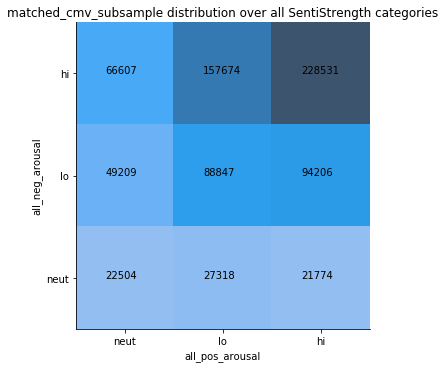

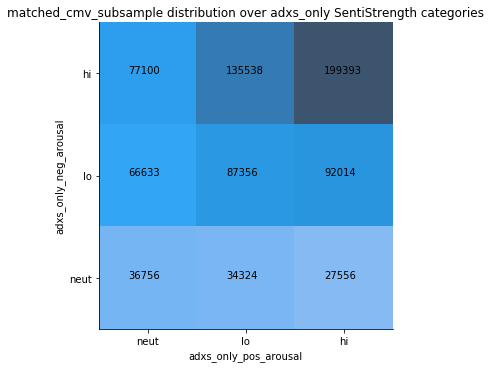

In [21]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                  if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat':[utt.meta['senti_all_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat':[utt.meta['senti_adxs_only_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']]
        })
        for senti_model in {'all','adxs_only'}:
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            ax = sns.displot(data=to_plot_df, 
                             x=f'{senti_model}_pos_arousal', 
                             y=f'{senti_model}_neg_arousal')
            x_locs, y_locs = ax.axes[0][0].get_xticks(), ax.axes[0][0].get_yticks()
            for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                    plt.annotate(str(len(to_plot_df.loc[
                        (to_plot_df[f'{senti_model}_pos_arousal']==pos_level) &
                        (to_plot_df[f'{senti_model}_neg_arousal']==neg_level)])),
                        xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.title(f'{corp_name} distribution over {senti_model} SentiStrength categories')
            plt.savefig(f'figs/senti_dist_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

Examine temporal trend:

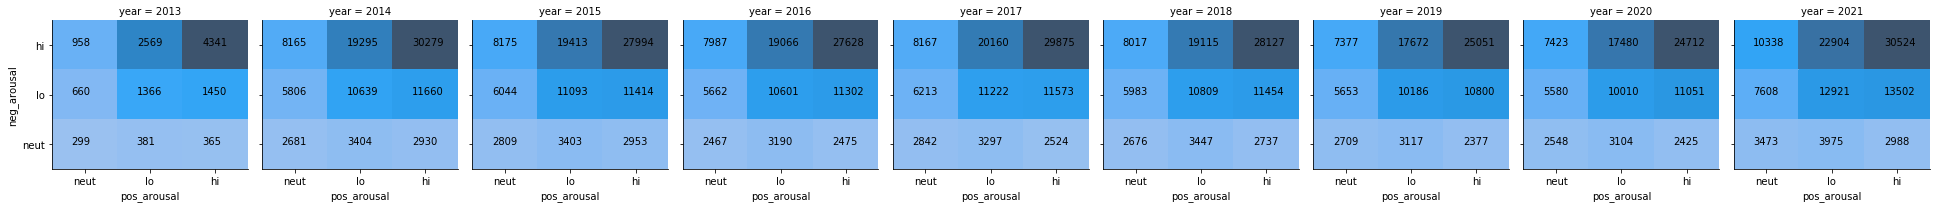

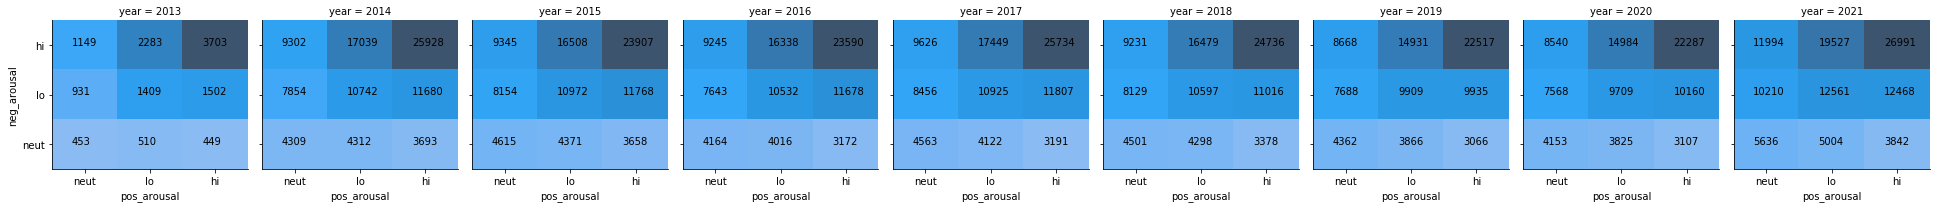

In [22]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:

        years = list(range(2013,2022))
        topics = ['climate change','other']
        for senti_model in ['all','adxs_only']:
        #emotions = EMOLEX_EMOS
            df_year, df_topic = [], []
            df_id, df_contro, df_replies, df_score = [], [], [], []
            df_pos_arousal, df_neg_arousal = [], []
            for utt in corp_to_analyze[corp_name].iter_utterances():
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if ('is_cc_related' in utt.meta and utt.meta['is_cc_related']) else 'other'
                df_year.append(year)
                df_topic.append(topic)
                df_id.append(utt.id)
                contro = utt.meta['controversiality'] if 'controversiality' in utt.meta else None
                df_contro.append(contro)
                num_replies = len(utt.meta['reply_ids']) if 'reply_ids' in utt.meta else None
                df_replies.append(num_replies)
                df_score.append(utt.meta['score'])
                senti_cat = utt.meta[f'senti_{senti_model}_arousal_cat'] 
                if senti_cat is not None:
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                else:
                    df_pos_arousal.append(None)
                    df_neg_arousal.append(None)
            to_plot_df = pd.DataFrame({
                'year':df_year,
                'topic':df_topic,
                'id':df_id,
                'contro':df_contro,
                'num_replies':df_replies,
                'score':df_score,
                'pos_arousal':df_pos_arousal,
                'neg_arousal':df_neg_arousal
            })
            for i,val in enumerate(['pos','neg']):
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='year', aspect=1)
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
            sns.despine()
            for i,col in enumerate(g.col_names):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['year']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.savefig(f'figs/senti_dist_over_time_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

In [23]:
# # Why are there so many neut-neut comments in general Reddit?
# # Examine examples
# [utt.text for utt in corp_to_analyze['gen_reddit'].iter_utterances()
# if utt.meta['senti_arousal_cat'] == 'neut_neg_neut_pos'][:20]

In [24]:
# [utt.text for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
# if utt.meta['senti_arousal_cat'] == 'hi_neg_hi_pos'][:20]

### NRC

In [14]:
VAD = pd.read_csv('/u/scr/yiweil/datasets/NRC-VAD-Lexicon.txt',sep='\t',header=0)
VAD.head()

Word  Valence  Arousal  Dominance
0  aaaaaaah    0.479    0.606      0.291
1     aaaah    0.520    0.636      0.282
2  aardvark    0.427    0.490      0.437
3     aback    0.385    0.407      0.288
4    abacus    0.510    0.276      0.485

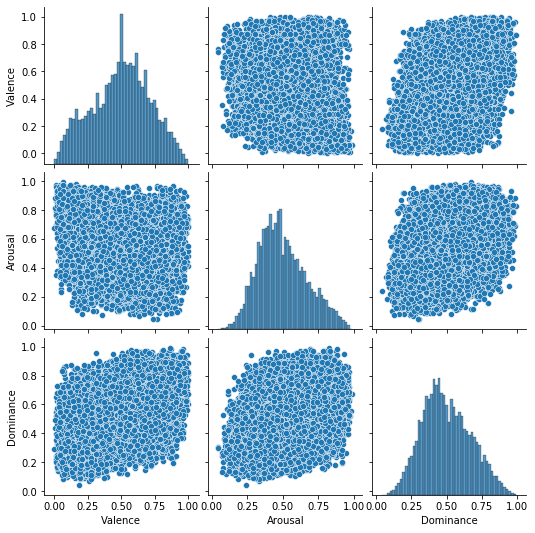

In [20]:
sns.pairplot(data=VAD)

In [19]:
# Create look-up dicts and function for computing NRC arousal

word2nrc_arousal = dict(zip(VAD['Word'],VAD['Arousal']))
word2nrc_valence = dict(zip(VAD['Word'],VAD['Valence']))

NRC_words_per_cat = defaultdict(list)
HI_AROUSAL_THRESH, LO_AROUSAL_THRESH = VAD['Arousal'].quantile(.75), VAD['Valence'].quantile(.25)
for w in tqdm(VAD['Word'].values):
    if word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['hi_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['lo_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['lo_pos'].append(w)
    elif word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['hi_pos'].append(w)
    else:
        NRC_words_per_cat['neut'].append(w)
        
NRC_words_per_cat = {cat: set(NRC_words_per_cat[cat]) for cat in NRC_words_per_cat}

word2NRC_cat = {}
for cat in NRC_words_per_cat:
    word2NRC_cat.update({w: cat for w in NRC_words_per_cat[cat]})
    
def get_nrc_arousal_cat(utt_lemmas,utt_id,cache_dict=None,verbose=False):
    if not cache_dict:
        val_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_valence]
        if len(val_lemms) > 0:
            valence_norm = sum([word2nrc_valence[lemm] 
                            for lemm in val_lemms])/len(val_lemms)
            arousal_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_arousal]
            arousal_norm = sum([word2nrc_arousal[lemm] 
                               for lemm in arousal_lemms])/len(arousal_lemms)
            if verbose:
                print(val_lemms)
                print(arousal_lemms)

            if arousal_norm >= VAD['Arousal'].quantile(.50):
                if valence_norm >= VAD['Valence'].quantile(.5):
                    return 'hi_pos'
                else:
                    return 'hi_neg'
            elif arousal_norm < VAD['Arousal'].quantile(.50) \
            and arousal_norm >= VAD['Arousal'].quantile(.25):
                if valence_norm >= VAD['Valence'].quantile(.5):
                    return 'lo_pos'
                else:
                    return 'lo_neg'
            else:
                return 'neut'
        return None
    else:
        return cache_dict[utt_id]

100%|██████████| 20007/20007 [00:18<00:00, 1105.32it/s]


In [ ]:
#NRC_words_per_cat['hi_neg']

In [ ]:
#NRC_words_per_cat['lo_neg']

In [ ]:
#NRC_words_per_cat['hi_pos']

In [ ]:
#NRC_words_per_cat['lo_pos']

In [21]:
# Assign NRC arousal categories 
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        vad_cache = pickle.load(open(f'VAD_scores_{corp_name}.pkl','rb'))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            vad_score = get_nrc_arousal_cat(None,utt.id,cache_dict=vad_cache)
            utt.meta['nrc_all_arousal_cat'] = vad_score['all']
            utt.meta['nrc_adxs_only_arousal_cat'] = vad_score['adxs_only']
            #break

756789it [00:07, 99482.51it/s] 


In [30]:
# # One time: create cache 
# vad_cache = defaultdict(dict)
# for corp_name in corp_to_analyze:
#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         vad_cache[utt.id]['all'] = utt.meta['nrc_all_arousal_cat']
#         vad_cache[utt.id]['adxs_only'] = utt.meta['nrc_adxs_only_arousal_cat']
#     pickle.dump(vad_cache,open(f'VAD_scores_{corp_name}.pkl','wb'))

756789it [00:03, 217946.28it/s]


### Compare SentiStrength categories to VAD categories

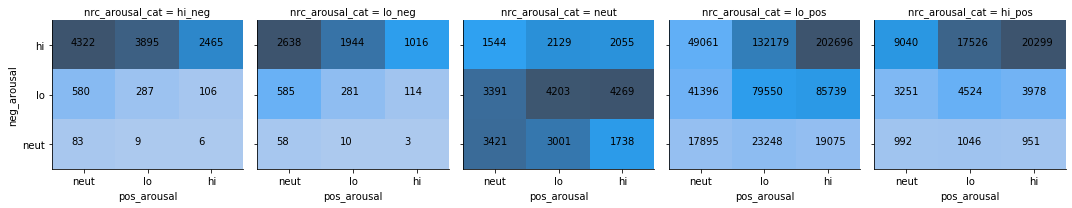

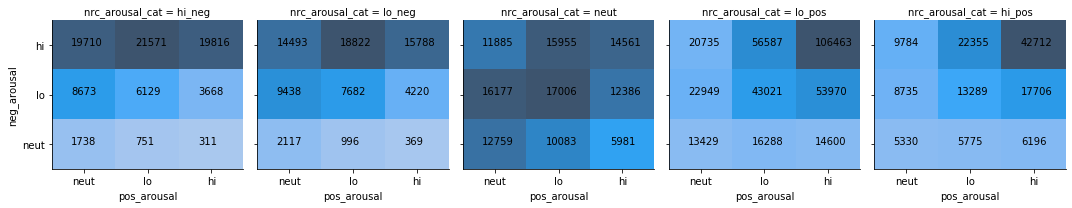

In [37]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        for model_name in ['all','adxs_only']:
            to_plot_df = pd.DataFrame({
                'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.meta[f'senti_{model_name}_arousal_cat'] 
                      and f'nrc_{model_name}_arousal_cat' in utt.meta 
                      and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'senti_arousal_cat':[utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'nrc_arousal_cat':[utt.meta[f'nrc_{model_name}_arousal_cat'] 
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            for i,val in enumerate(['pos','neg']):
                to_plot_df['{}_arousal'.format(val)] = \
                to_plot_df[f'senti_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='nrc_arousal_cat', 
                              col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')
            for i,col in enumerate(['hi_neg','lo_neg','neut','lo_pos','hi_pos']):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['nrc_arousal_cat']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
        #     plt.title('{} distribution over SentiStrength categories per VAD category'.format(
        #         corp_name))
            plt.savefig(f'figs/senti_dist_and_vad_dist_{corp_name}_{model_name}.png',
                         dpi=150,bbox_inches="tight")

Comments receiving `hi_neg` NRC label but `hi_pos_lo_neg` SentiStrength label:

In [115]:
mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_neg') &
                              (to_plot_df['senti_arousal_cat']=='hi_pos_lo_neg')]\
['id'].values
pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

0
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   The existence of Global Warming is considered a political issue in very few countries. Really only the US.\n\nWhy is that?\n\nIn 2006, Al Gore helped to make the movie "An Inconvenient Truth." The opening line of this film is "'Hi, I'm Al Gore, I used to be the next president of the United States of America." By opening the film in this manner, Mr. Gore *immediately* politicized the issue. I don't agree with the fact that it did, but that's the unfortunate truth.\n\n\nIf you're talking about the US and only the US, then there's some truth to this as we've politicized the issue of global warming (even though the IPCC has officially stated that it's happening and caused by humans.) If your talking about other countries, then I don't think this is true simply because global warming isn't a political issue. So, please clarify, is this US specific or not?\n\nSource: Attendance of Multiple Lectures by IPCC memebers
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Just because a source has not got a good track record does not mean they are permanently doomed to being wrong forever. Second, a prediction is only proved when it comes true. Just because it has not come true yet doesn't mean it never will. What you demand from these organisations is that they knew what they were talking about 5 years ago, when there is every chance they are working on more robust science since then. Regardless of this, your post claims it is unprovable. They are, of course, all provable, they just haven't been proved yet. \n\nInstead I put it to you, that you cannot prove that anthropocentric climate change being catastrophic cannot be proven, and your point of view is therefore redundant. I however, can prove that it is provable. It is instantly proved, when any one of the models that claims it will be catastrophic is proved correct
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                First time commenting on one of these, your opinion actually makes a lot of sense to me. Developing economies need these co2 emitting resources; however, there is no need for developed nations to still be using them. While there are definite pluses for having more CO2 in the air there are still many negatives! Pollution, contamination, CO2 levels in the ocean, acid rain, smog, and

Comments receiving `hi_pos` NRC label but `hi_neg_neut_pos` or `hi_neg_lo_pos` SentiStrength label:

In [28]:
# mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_pos') &
#                               (to_plot_df['senti_arousal_cat'].isin({'hi_neg_neut_pos',
#                                                                      'hi_neg_lo_pos'}))]\
# ['id'].values
# pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

## Emotions

### EmoLex

In [15]:
BLACKLIST_WORDS = {'shit','shitty','fuck','crap','crappy','gore','trump','tree','sun','soil','shanghai','john',
                  'desert','turn','earthquake','lightning','hurricane','cyclone','tornado','storm','wildfire',
                  'fire','cool','warm','hot','human','earth','planet','global','climate','change','cold'}

In [16]:
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')
EMOLEX = EMOLEX.loc[~EMOLEX['word'].isin(BLACKLIST_WORDS)]
EMOLEX_EMOS = EMOLEX['emotion'].value_counts().index
print(EMOLEX.head())

print(EMOLEX[
    'emotion'
].value_counts())

        word emotion  emotion-intensity-score
0   outraged   anger                    0.964
1  brutality   anger                    0.959
2     hatred   anger                    0.953
3    hateful   anger                    0.940
4  terrorize   anger                    0.939
fear            1754
trust           1562
anger           1475
sadness         1292
joy             1265
disgust         1085
anticipation     862
surprise         578
Name: emotion, dtype: int64


In [44]:
ratios_trusted_trusting = pickle.load(open('emolex_high_trust_ratios_trusted_trusting.pkl','rb'))
trusted_words = [w for w in ratios_trusted_trusting if ratios_trusted_trusting[w] >= 1]
trusting_words = [w for w in ratios_trusted_trusting if ratios_trusted_trusting[w] < 1]
len(trusted_words),len(trusting_words)

(450, 379)

In [ ]:
# # Why is trust higher than the rest?
# EMOLEX.loc[(EMOLEX['emotion']=='trust') & 
#           (EMOLEX['emotion-intensity-score']>0.5)].word.values

In [25]:
# Create look-up dicts and function for computing Emolex scores

word2emolex_score = defaultdict(dict)
for _,row in EMOLEX.iterrows():
    word, emotion, score = row['word'], row['emotion'], row['emotion-intensity-score']
    word2emolex_score[word][emotion] = score
    
def get_emolex_scores(utt,utt_id,json_dir,cache_dict=None,verbose=False):
    if not cache_dict:
        json_obj = get_stanza_json(utt)
        if json_obj:
            utt_lemmas = [x['lemma'] for sent in json_obj['parse'] for x in sent]
            utt_adxs = [x['lemma'] for sent in json_obj['parse'] for x in sent if x['upos'] in {'ADJ','ADV'}]
            emo_lemms = [lemm for lemm in utt_lemmas if lemm in word2emolex_score]
            emo_adxs = [lemm for lemm in utt_adxs if lemm in word2emolex_score]
            if verbose:
                print(emo_lemms)
                print(emo_adxs)

            emo_norms = defaultdict(dict)
            if len(emo_lemms) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_lemms
                                    if emo in word2emolex_score[lemm]])/len(emo_lemms)
                    emo_norms['all'][emo] = emo_norm
            if len(emo_adxs) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_adxs
                                    if emo in word2emolex_score[lemm]])/len(emo_adxs)
                    emo_norms['adxs_only'][emo] = emo_norm
            return emo_norms
        return {}
    else:
        return cache_dict[utt_id]

In [42]:
utt.text

'We actually don’t have many Mac apples around me, so I don’t have strong opinions on it.\n\nBut when I saw the Red Delicious is the lowest common denominator of apples, I mean that in terms of its actual place in the market.   It literally was bred to be the generic “apple” that you can find in any free fruit basket, crappy school and hospital cafeteria, etc.   It’s the mass market product of late 20th century American industrial agriculture.\n\nThe original cultivar of the apple was apparently quite good, which is why it became popular.  And I’m sure if you get some good red delicious apples today that they are from sources closer to those original trees.\n\nBut around the ‘40s and ‘50s, as our food supply chains industrialized, farmers started selecting for strains that were more consistently deep red, because those were the easiest to market, that had thick skins, because those could be more easily shipped, and that had high yields, because those grew more cheaply.   Taste and text

In [44]:
get_emolex_scores(utt,utt.id,STANZA_DIR,verbose=True)

['strong', 'free', 'school', 'hospital', 'late', 'good', 'popular', 'good', 'delicious', 'food', 'start', 'ship', 'grow', 'result', 'delicious', 'dominate', 'bad', 'bottom', 'fall', 'delicious', 'government', 'production', 'delicious', 'grow', 'good', 'good', 'reliable', 'delicious']
['strong', 'free', 'late', 'good', 'popular', 'good', 'delicious', 'delicious', 'bad', 'delicious', 'delicious', 'good', 'good', 'reliable', 'delicious']


defaultdict(dict,
            {'all': {'fear': 0.05914285714285714,
              'trust': 0.23260714285714287,
              'anger': 0.03403571428571429,
              'sadness': 0.05971428571428572,
              'joy': 0.22746428571428567,
              'disgust': 0.013964285714285716,
              'anticipation': 0.1727857142857143,
              'surprise': 0.04357142857142856},
             'adxs_only': {'fear': 0.025,
              'trust': 0.27540000000000003,
              'anger': 0.030199999999999998,
              'sadness': 0.03646666666666667,
              'joy': 0.37513333333333326,
              'disgust': 0.02606666666666667,
              'anticipation': 0.10213333333333333,
              'surprise': 0.058399999999999994}})

In [48]:
# # One time: create cache
# for corp_name in corp_to_analyze:
#     if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
#         emolex_cache = defaultdict(dict)
#         for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#             scores = get_emolex_scores(utt,utt.id,STANZA_DIR)
#             if len(scores) > 0:
#                 for emo in EMOLEX_EMOS:
#                     for model_name in scores:
#                         utt.meta[f'emolex_{model_name}_{emo}'] = scores[model_name][emo]
#                         emolex_cache[utt.id][f'{model_name}_{emo}'] = scores[model_name][emo]
#         pickle.dump(emolex_cache,open(f'emolex_cache_{corp_name}.pkl','wb'))

756789it [28:50, 437.41it/s]


In [26]:
# Get Emolex scores for corpora that are stanza-parsed
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        emolex_cache = pickle.load(open(f'emolex_cache_{corp_name}.pkl','rb'))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            scores = get_emolex_scores(utt,utt.id,STANZA_DIR,cache_dict=emolex_cache)
            if len(scores) > 0:
                for emo in EMOLEX_EMOS:
                    for model_name in ['all','adxs_only']:
                        if f'{model_name}_{emo}' in scores:
                            utt.meta[f'emolex_{model_name}_{emo}'] = scores[f'{model_name}_{emo}']

756789it [01:05, 11557.13it/s]


Examine temporal trend:

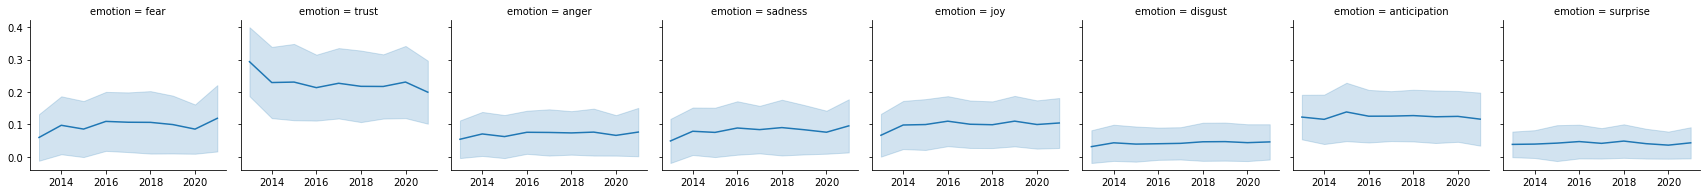

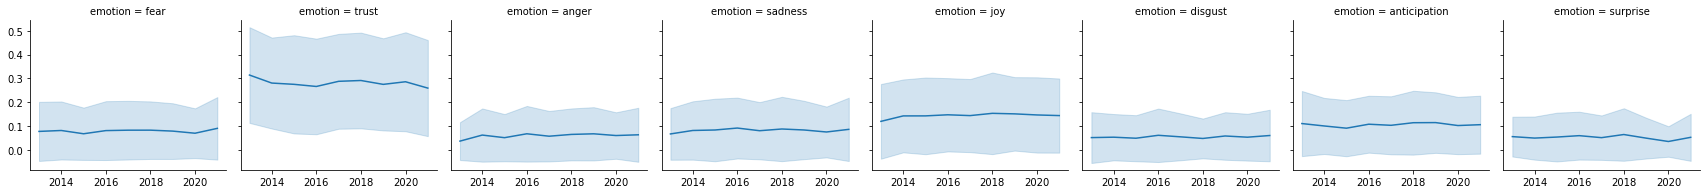

In [133]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            year = datetime.utcfromtimestamp(utt.timestamp).year
            topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
            for key in utt.meta.keys():
                if key.startswith(f'emolex_{model_name}'):
                    emo = key.split('_')[-1]
                    score = utt.meta[f'emolex_{model_name}_{emo}']
                    df_year.append(year)
                    df_topic.append(topic)
                    df_emo.append(emo)
                    df_emoscore.append(score)
                    df_id.append(utt.id)
                    df_contro.append(utt.meta['controversiality'])
                    df_replies.append(len(utt.meta['reply_ids']))
                    df_score.append(utt.meta['score'])
                    df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                    senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                    df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
        plt.rcParams['figure.figsize'] = [10, 5]
        g = sns.FacetGrid(to_plot_df, col='emotion', aspect=1)
        g.map(sns.lineplot, 'year', 'emoscore', ci='sd')
        sns.despine()
        for ax in g.axes[0]:
            ax.set_xlabel('')
            ax.set_ylabel('')
        plt.savefig(f'figs/emolex_scores_over_time_{corp_name}_{model_name}.png',
                    dpi=200,bbox_inches="tight")

Examine other correlations:

Engagement-related correlations:

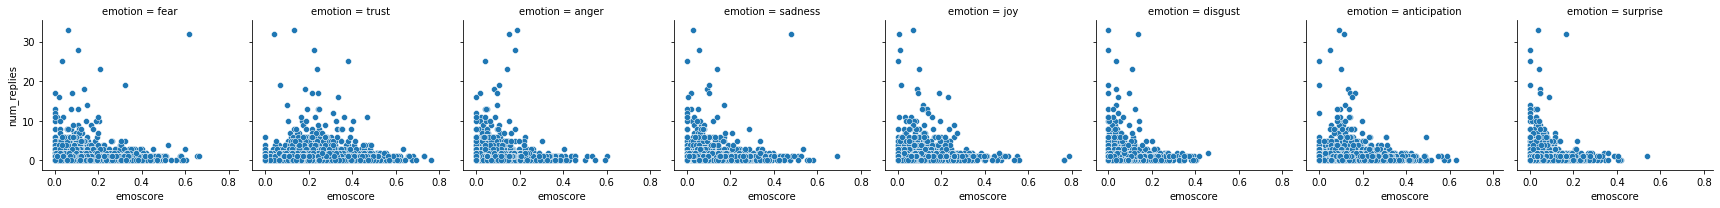

In [209]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','num_replies')
# for ax in g.axes[0]:
#     ax.set_yscale('log')

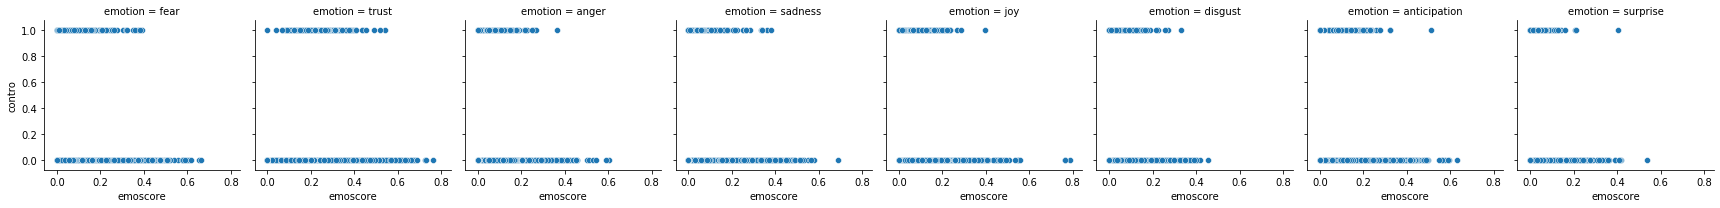

In [210]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','contro')

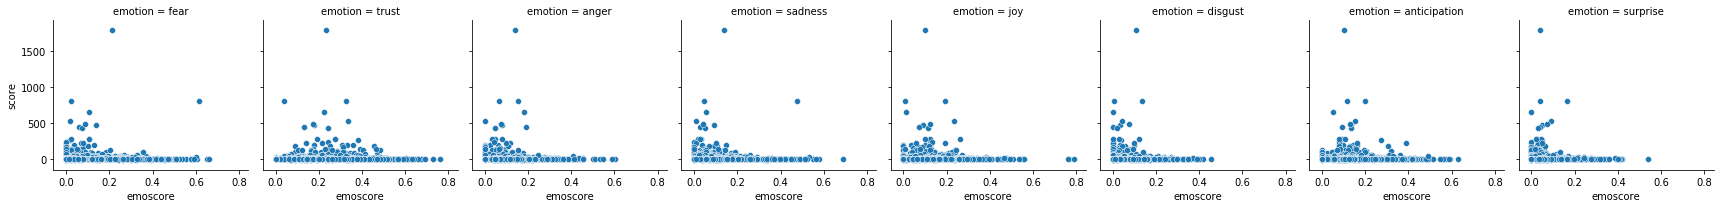

In [211]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','score')

Arousal correlations:

In [38]:
for corp_name in corp_to_analyze:
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            if utt.id[:2] != 't3':
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
                for key in utt.meta.keys():
                    if key.startswith(f'emolex_{model_name}'):
                        emo = key.split('_')[-1]
                        score = utt.meta[f'emolex_{model_name}_{emo}']
                        df_year.append(year)
                        df_topic.append(topic)
                        df_emo.append(emo)
                        df_emoscore.append(score)
                        df_id.append(utt.id)
                        df_contro.append(utt.meta['controversiality'])
                        df_replies.append(len(utt.meta['reply_ids']))
                        df_score.append(utt.meta['score'])
                        df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                        senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                        df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                        df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                        df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
    
        g = sns.FacetGrid(to_plot_df, col=f'nrc_arousal', 
                          col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
        g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)

        # Aesthetics & saving
        for ax_ix,ax in enumerate(g.axes[0]):
            if ax_ix == 0:
                ax.set_ylabel('Emotion intensity score',fontsize=24)
            ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel('')
        plt.savefig(f'figs/emolex_dist_and_vad_dist_{corp_name}_{model_name}.png',
                     dpi=150,bbox_inches="tight")

KeyboardInterrupt: 

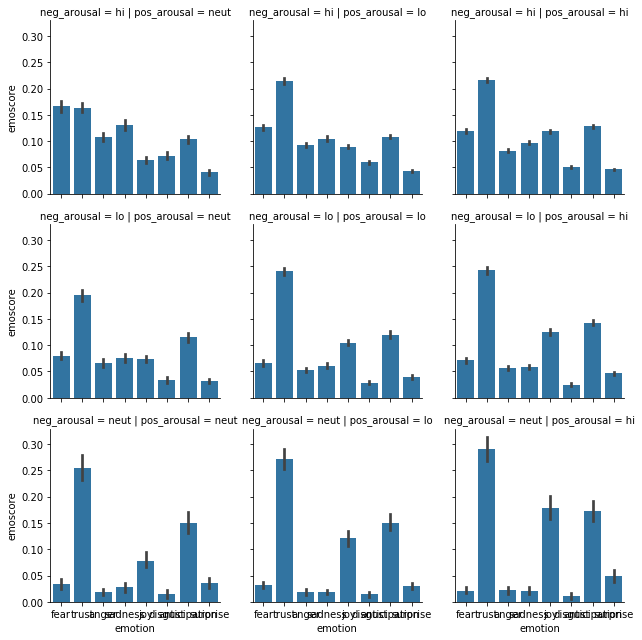

In [200]:
for corp_name in corp_to_analyze:
    
    g = sns.FacetGrid(to_plot_df, col='pos_arousal', row='neg_arousal',
                      col_order=['neut','lo','hi'], row_order=['hi','lo','neut'])
    g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)
    
#     # Aesthetics & saving
#     for ax_ix,ax in enumerate(g.axes[0]):
#         if ax_ix == 0:
#             ax.set_ylabel('Emotion intensity score',fontsize=24)
#         ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
#         ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
#         ax.set_xlabel('')
#     plt.savefig('figs/emolex_dist_and_senti_dist_{}.png'.format(corp_name),
#                  dpi=150,bbox_inches="tight")

## People

In [17]:
def get_ents(utt,json_dir,verbose=False):
    json_obj = get_stanza_json(utt)
    if json_obj is not None:
        ents = [(x['text'],x['type']) for x in json_obj['ents']]
        return ents
    else:
        return []

In [ ]:
# Extract people
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','matched_cmv_subsample'}:
        all_corp_ents = []
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if utt.id[:2] != 't3':
                utt_ents = get_ents(utt,STANZA_DIR)
                all_corp_ents.extend(utt_ents)
                utt.meta['people'] = [e[0] for e in utt_ents if e[1]=='PERSON']

23450it [07:04, 34.12it/s]

First, examine most commonly mentioned NEs:

In [282]:
print(sorted(Counter([x for x in all_corp_ents if x[1] not in {'DATE','CARDINAL','ORDINAL','PERCENT'}]).items(), 
       key=lambda x: x[1], reverse=True)[:100])
del all_corp_ents

[(('US', 'GPE'), 738), (('Earth', 'LOC'), 642), (('China', 'GPE'), 602), (('Trump', 'PERSON'), 175), (('India', 'GPE'), 174), (('IPCC', 'ORG'), 160), (('American', 'NORP'), 155), (('America', 'GPE'), 145), (('Europe', 'LOC'), 139), (('Republicans', 'NORP'), 130), (('Canada', 'GPE'), 116), (('USA', 'GPE'), 108), (('Americans', 'NORP'), 95), (('NASA', 'ORG'), 92), (('California', 'GPE'), 89), (('Democrats', 'NORP'), 83), (('Russia', 'GPE'), 83), (('the United States', 'GPE'), 79), (('Africa', 'LOC'), 74), (('Chinese', 'NORP'), 73), (('U.S.', 'GPE'), 71), (('republicans', 'NORP'), 65), (('Australia', 'GPE'), 57), (('UK', 'GPE'), 57), (('earth', 'LOC'), 56), (('EPA', 'ORG'), 51), (('Republican', 'NORP'), 50), (('Al Gore', 'PERSON'), 48), (('Tesla', 'ORG'), 46), (('Venus', 'LOC'), 45), (('Paris', 'GPE'), 45), (('Obama', 'PERSON'), 44), (('Germany', 'GPE'), 42), (('EU', 'ORG'), 41), (('Florida', 'GPE'), 40), (('Bible', 'WORK_OF_ART'), 40), (('OP', 'ORG'), 40), (('France', 'GPE'), 39), (('GM'

Examine most commonly mentioned people:

In [355]:
counted_people = Counter([item for sublist in 
                         [utt.meta['people'] for utt in corp_to_analyze['matched_cc_cmv_subsample'].iter_utterances()
                         if utt.id[:2] != 't3' and utt.meta['is_awarded_delta']]
                         for item in sublist
                         ])
sorted(counted_people.items(),key=lambda x: x[1],reverse=True)[:100]

[('Trump', 10),
 ('Greta', 4),
 ('Joe', 3),
 ('Al Gore', 3),
 ('Broecker', 2),
 ('E. Calvo', 2),
 ('M.T. McCulloch', 2),
 ('J.F. Marshall', 2),
 ('M.K. Gagan', 2),
 ('J.M. Lough', 2),
 ('B.N. Opdyke', 2),
 ('Iris', 2),
 ('Lindzen', 2),
 ('Clinton', 2),
 ('Bill Nye', 2),
 ("Al Gore's", 2),
 ('Greta Thunberg', 2),
 ('Donald Trump', 2),
 ('Simon', 2),
 ('Joe Smuch', 1),
 ('Ruddiman', 1),
 ('S.E. Wijffels', 1),
 ('R.J. Matear', 1),
 ('Occam', 1),
 ('Spencer', 1),
 ('Hadley Cells', 1),
 ('W Bush', 1),
 ('Biden', 1),
 ('Matt Yglesias', 1),
 ('Linuxmoose5000', 1),
 ('Manchin', 1),
 ('Dunning-Kruger', 1),
 ('Brooks', 1),
 ('The Bill Gates', 1),
 ('Sandy', 1),
 ('Lenin', 1),
 ('Milankovitch', 1),
 ('Saharan Summers', 1),
 ('Robert Mugabe', 1),
 ('McCulloch', 1),
 ('Nick Bostrom', 1),
 ('Bostrom', 1),
 ('Erwin', 1),
 ('Utah Phillips', 1),
 ('BILL NYE', 1),
 ('Bruce Willis', 1),
 ('Cook', 1),
 ('Cooks', 1),
 ('Tucker Carlson', 1),
 ('Tucker', 1),
 ('Bill', 1),
 ('Jim Skea', 1),
 ('Mitch McConnell

Examine temporal trend:

756789it [00:04, 185943.28it/s]


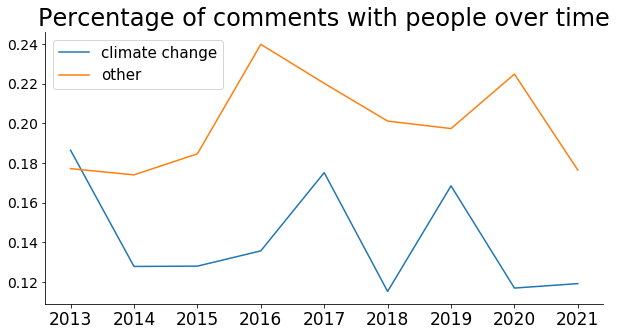

In [49]:
for corp_name in corp_to_analyze:
    counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.timestamp and utt.id[:2] != 't3':
            year = datetime.utcfromtimestamp(utt.timestamp).year
            if utt.meta['is_cc_related']:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['climate change']['has person'] += 1
                else:
                    counts_by_bin[year]['climate change']['no person'] += 1
            else:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['other']['has person'] += 1
                else:
                    counts_by_bin[year]['other']['no person'] += 1

    years = list(range(2013,2022))
    topics = ['climate change','other']
    classes = ['has person','no person']
    to_plot_df = pd.DataFrame({
        'year':[item for sublist in 
                [[y]*len(topics)*len(classes) for y in years]
                for item in sublist],
        'topic':[item for sublist in 
                [[t]*len(classes) for t in topics]
                for item in sublist]*len(years),
        'class':classes*len(years)*len(topics),
        'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
    })

    per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
    to_plot_df['percent'] = to_plot_df.apply(
        lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
                            .loc[x['topic']]['count'],
        axis=1
    )

    plt.rcParams['figure.figsize'] = [10, 5]
    sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='has person'],
               x='year',y='percent',hue='topic',ci='sd')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=14)
    plt.title('Percentage of comments with people over time',fontsize=24)
    plt.legend(title='',fontsize=15)
    sns.despine()
    plt.savefig('figs/pct_comments_with_people_over_time_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

Examine correlation with other comment properties:

In [50]:
for corp_name in corp_to_analyze:

    people_df = pd.DataFrame({
        'id':[utt.id
             for utt in corp_to_analyze[corp_name].iter_utterances()
             if utt.id[:2] != 't3'],
        'has_person':[len(utt.meta['people'])>0 
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
        'num_people':[len(utt.meta['people']) 
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
        'year':[datetime.utcfromtimestamp(utt.timestamp).year 
                for utt in corp_to_analyze[corp_name].iter_utterances()
               if utt.id[:2] != 't3'],
        'controversiality':[utt.meta['controversiality'] 
                            for utt in corp_to_analyze[corp_name].iter_utterances()
                           if utt.id[:2] != 't3'],
        'num_replies':[len(utt.meta['reply_ids'])
                       for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.id[:2] != 't3'],
        'score':[utt.meta['score']
                 for utt in corp_to_analyze[corp_name].iter_utterances()
                if utt.id[:2] != 't3']
    })

    people_df.head()

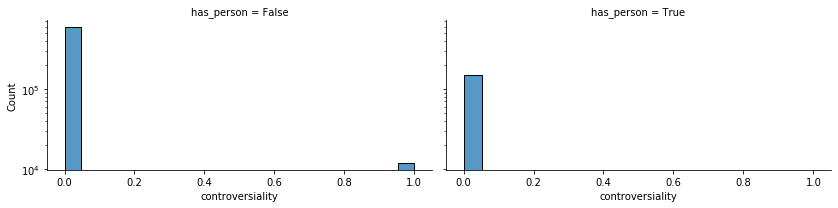

In [51]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "controversiality")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

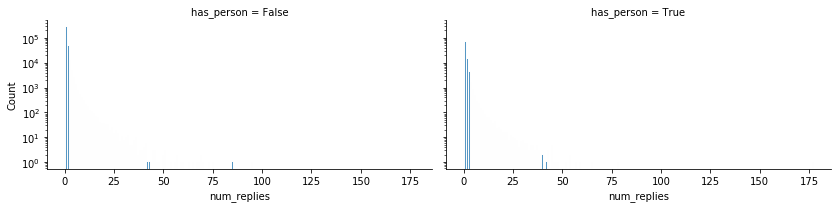

In [52]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "num_replies")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

In [54]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "score")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f475d53c510> (for post_execute):


KeyboardInterrupt: 

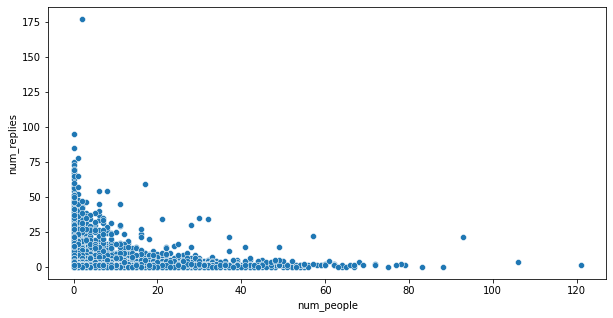

In [55]:
sns.scatterplot(data=people_df,x="num_people",y="num_replies")

In [173]:
#sns.scatterplot(data=people_df,x="num_people",y="controversiality")

In [174]:
#ax = sns.scatterplot(data=people_df,x="num_people",y="score")

## URLs

In [129]:
from urllib.parse import urlparse

def get_url_domain(url):
    url = re.split(']|\)',url)[0]
    domain = urlparse(url).netloc
    domain = re.split('.com|.org|.gov|.edu|.net', domain.split('www.')[-1])[0]
    return domain

def get_urls(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        utt.meta['text_urls'] = get_urls(utt.text)
        utt.meta['url_domains'] = [get_url_domain(u_) for u_ in utt.meta['text_urls']]
        utt.meta['num_urls'] = len(utt.meta['text_urls'])
        utt.meta['has_url'] = utt.meta['num_urls'] > 0

<>:4: DeprecationWarning: invalid escape sequence \)
<>:4: DeprecationWarning: invalid escape sequence \)
<>:4: DeprecationWarning: invalid escape sequence \)
<ipython-input-129-e688f4df060a>:4: DeprecationWarning: invalid escape sequence \)
  url = re.split(']|\)',url)[0]
184474it [00:07, 24760.85it/s]


In [130]:
counted_url_domains = Counter([item for sublist in 
                         [utt.meta['url_domains'] for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
                         if utt.id[:2] != 't3' and utt.meta['is_awarded_delta']]
                         for item in sublist
                         ])
sorted(counted_url_domains.items(),key=lambda x: x[1],reverse=True)[:100]

[('en.wikipedia', 1259),
 ('youtube', 409),
 ('reddit', 163),
 ('ncbi.nlm.nih', 154),
 ('en.m.wikipedia', 89),
 ('nytimes', 89),
 ('youtu.be', 82),
 ('google', 77),
 ('washingtonpost', 75),
 ('i.imgur', 71),
 ('theguardian', 61),
 ('npr', 60),
 ('cdc', 52),
 ('forbes', 39),
 ('psychologytoday', 33),
 ('pewresearch', 33),
 ('theatlantic', 33),
 ('vox', 32),
 ('cnn', 31),
 ('huffingtonpost', 31),
 ('imgur', 31),
 ('politifact', 29),
 ('amazon', 29),
 ('votesmart', 29),
 ('upload.wikimedia', 23),
 ('bbc', 23),
 ('slate', 22),
 ('businessinsider', 22),
 ('nbcnews', 21),
 ('tandfonline', 21),
 ('bls', 21),
 ('abcnews.go', 20),
 ('jstor', 20),
 ('independent.co.uk', 19),
 ('nature', 18),
 ('telegraph.co.uk', 18),
 ('sciencedirect', 18),
 ('twitter', 18),
 ('cnbc', 18),
 ('merriam-webster', 18),
 ('plato.stanford', 18),
 ('economist', 17),
 ('usatoday', 17),
 ('m.youtube', 17),
 ('data.worldbank', 16),
 ('nber', 16),
 ('time', 15),
 ('fivethirtyeight', 15),
 ('pubmed.ncbi.nlm.nih', 15),
 ('me

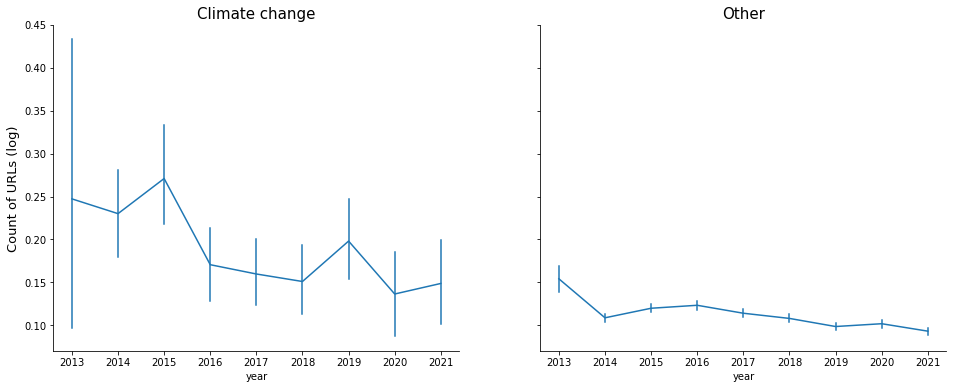

In [89]:
for corp_name in corp_to_analyze:
    to_plot_df = pd.DataFrame({
            'topic': [utt.meta['is_cc_related_gold']
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.id[:2] != 't3'],
            'year': [datetime.utcfromtimestamp(utt.timestamp).year
                     for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
            'num_urls': [utt.meta['num_urls']
                            for utt in corp_to_analyze[corp_name].iter_utterances()
                            if utt.id[:2] != 't3'],

        })
    to_plot_df['log_num_urls'] = to_plot_df['num_urls'].apply(lambda x: np.log(x+1))

    fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
    for ix_, topic_bool in enumerate([True, False]):
        ax_ = ax[ix_]
        sns.lineplot(data=to_plot_df.loc[to_plot_df['topic']==topic_bool], 
                     x='year', y='log_num_urls', ci=95,err_style='bars',
                     ax=ax_)
        if ix_ % 2 == 0:
            ax_.set_ylabel('Count of URLs (log)',fontsize=13)
            ax_.set_title("Climate change",fontsize=15)
        else:
            ax_.set_ylabel('')
            ax_.set_title("Other",fontsize=15)
        #labels = ax_.get_xticklabels()
        #print(labels[0].text)
        #print([label.__dict__ for label in ax_.get_xticklabels()[:3]])
        #ax_.set_xticklabels([label._x for label in ax_.get_xticklabels()],fontsize=14,rotation=90)
        #ax_.set_xlabel('')
    sns.despine()
    plt.savefig('figs/log_num_urls_over_time_with_error_bars_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

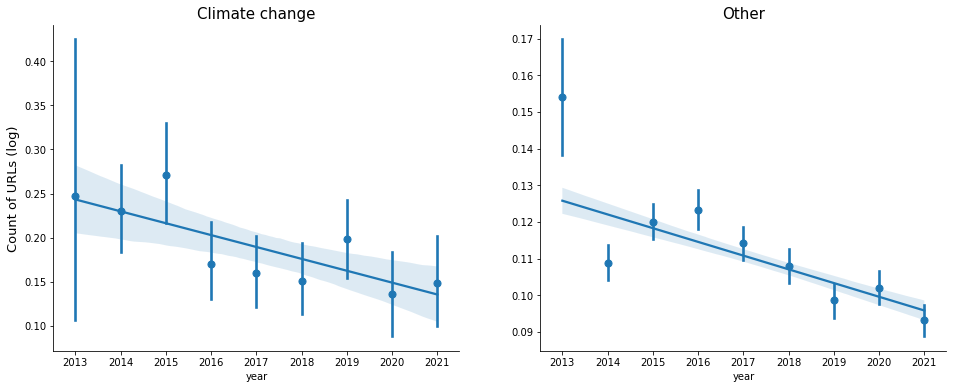

In [95]:
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=False)
for ix_, topic_bool in enumerate([True, False]):
    ax_ = ax[ix_]
    sns.regplot(data=to_plot_df.loc[to_plot_df['topic']==topic_bool], 
                 x='year', y='log_num_urls', ci=95,scatter=True,x_estimator=np.mean,
                 ax=ax_)
    if ix_ % 2 == 0:
        ax_.set_ylabel('Count of URLs (log)',fontsize=13)
        ax_.set_title("Climate change",fontsize=15)
    else:
        ax_.set_ylabel('')
        ax_.set_title("Other",fontsize=15)
sns.despine()
plt.savefig('figs/log_num_urls_over_time_regplot_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

## DeSMOG features

In [56]:
desmog_feats_dict = defaultdict(list)
for fname in glob.glob('/u/scr/yiweil/GWStance/4_analyses/lexicons/*.txt'):
    feats_cat = fname.split('/')[-1].split('.txt')[0]
    with open(fname,'r') as f:
        desmog_feats_dict[feats_cat].extend(f.read().splitlines())

In [105]:
desmog_feats_dict.keys()

dict_keys(['ANTI_WORDS', 'AFFIRM_WORDS', 'SCI_WORDS', 'VERBS_WORDS', 'DOUBT_WORDS', 'PRO_WORDS'])

## Scientific language

### Use Empath

In [ ]:
from empath import Empath
lexicon = Empath()
SCIENCE_SEEDS = desmog_feats_dict['SCI_WORDS']#

In [ ]:
', '.join(SCIENCE_SEEDS)

In [ ]:
# lexicon.create_category("science_nyt",SCIENCE_SEEDS,model="nytimes")
# lexicon.create_category("science_reddit",SCIENCE_SEEDS,model="reddit")
# lexicon.create_category("science_fic",SCIENCE_SEEDS,model="fiction")

empath_sci_feats = {}
for mod in ['nyt','reddit','fic']:
    with open(f'/juice/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/\
empath/data/user/science_{mod}.empath','r') as f:
        empath_sci_feats[mod] = f.read().split('\t')[1:]

In [284]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id[:2] != 't3':
            for empath_cat in ['science','science_nyt','science_reddit','science_fic']:
                utt.meta[empath_cat] = lexicon.analyze(utt.text, categories=[empath_cat])[empath_cat]#, normalize=False)

6349it [00:02, 2188.39it/s]


Examine temporal trend:

In [ ]:
# for corp_name in corp_to_analyze:
#     counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         if utt.timestamp and utt.id[:2] != 't3':
#             year = datetime.utcfromtimestamp(utt.timestamp).year
#             for empath_cat in ['science','science_nyt','science_reddit','science_fic']:
#                 if utt.meta['is_cc_related']:
#                     counts_by_bin[year]['climate change'][empath_cat] += utt.meta[empath_cat]
#                 else:
#                     counts_by_bin[year]['other'][empath_cat] += utt.meta[empath_cat]

#     years = list(range(2013,2022))
#     topics = ['climate change','other']
#     classes = ['science','science_nyt','science_reddit','science_fic']
#     to_plot_df = pd.DataFrame({
#         'year':[item for sublist in 
#                 [[y]*len(topics)*len(classes) for y in years]
#                 for item in sublist],
#         'topic':[item for sublist in 
#                 [[t]*len(classes) for t in topics]
#                 for item in sublist]*len(years),
#         'class':classes*len(years)*len(topics),
#         'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
#     })

#     per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
#     to_plot_df['norm'] = to_plot_df.apply(
#         lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
#                             .loc[x['topic']]['count'],
#         axis=1
#     )
    
#     plt.rcParams['figure.figsize'] = [10, 5]
#     g = sns.FacetGrid(to_plot_df, col='topic', hue='class', aspect=1.5, sharey=False)
#     g.map(sns.lineplot, 'year', 'norm', ci=95)
#     g.add_legend()
#     for ix_ax,ax in enumerate(g.axes[0]):
#         ax.set_xlabel('')
#         ax.set_xticklabels(ax.get_xticklabels(),fontsize=14,rotation=90)
#         if ix_ax % 2 == 0:
#             ax.set_ylabel('Normed count of lexicon features',fontsize=13)
#             ax.set_title("Climate change",fontsize=15)
#         else:
#             ax.set_title("Other",fontsize=15)
#     sns.despine()
#     plt.savefig('figs/empath_sci_features_over_time_{}.png'.format(corp_name),
#                 dpi=200,bbox_inches="tight")

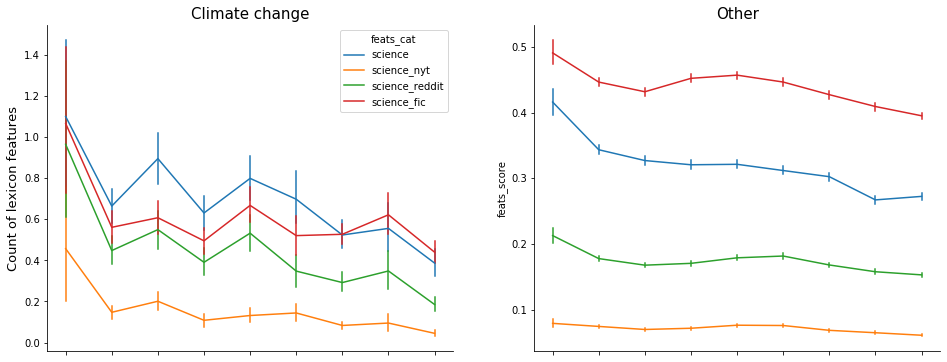

In [240]:
for corp_name in corp_to_analyze:
#     empath_cats = ['science','science_nyt','science_reddit','science_fic']
#     to_plot_df = pd.DataFrame({
#             'topic': [utt.meta['is_cc_related']
#                       for empath_cat in empath_cats
#                       for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#             'year': [datetime.utcfromtimestamp(utt.timestamp).year
#                      for empath_cat in empath_cats
#                      for utt in corp_to_analyze[corp_name].iter_utterances()
#                      if utt.id[:2] != 't3'],
#             'feats_score': [utt.meta[empath_cat]
#                             for empath_cat in empath_cats
#                             for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#             'feats_cat': [empath_cat
#                           for empath_cat in empath_cats
#                           for utt in corp_to_analyze[corp_name].iter_utterances()
#                           if utt.id[:2] != 't3'],

#         })

    fig, ax = plt.subplots(1,2,figsize=(16,6))
    for ix_, topic_bool in enumerate([True, False]):
        ax_ = ax[ix_]
        sns.lineplot(data=to_plot_df.loc[to_plot_df['topic']==topic_bool], 
                     hue='feats_cat', x='year', y='feats_score', ci=95,err_style='bars',
                     ax=ax_)
        if ix_ % 2 == 0:
            ax_.set_ylabel('Count of lexicon features',fontsize=13)
            ax_.set_title("Climate change",fontsize=15)
        else:
            ax_.set_title("Other",fontsize=15)
            ax_.get_legend().remove()
        ax_.set_xlabel('')
        ax_.set_xticklabels(ax_.get_xticklabels(),fontsize=14,rotation=90)
    sns.despine()
    plt.savefig('figs/empath_sci_features_over_time_with_error_bars_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

# Regressions

## Create matched pairs

In [ ]:
regression_ids = pickle.load(open('convo_utt_ids_for_regression.pkl','rb'))
regression_convo_ids, regression_utt_ids = regression_ids['convo'], regression_ids['utt']

In [ ]:
from nltk.corpus import stopwords
to_ignore = set(stopwords.words('english'))
to_ignore |= set(VAD['Word'].values)
to_ignore |= set(EMOLEX['word'].values)
# add Empath sci features

def get_jaccard_sim(utt1,utt2,to_ignore=to_ignore):
    json1 = get_stanza_json(utt1)
    json2 = get_stanza_json(utt2)
    utt1_words = [x['lemma'] if x['lemma'] is not None 
                   else x['text']
                   for sent in json1['parse']
                   for x in sent]
    utt2_words = [x['lemma'] if x['lemma'] is not None 
                   else x['text']
                   for sent in json2['parse']
                   for x in sent]
    utt1_words = set([w for w in utt1_words if w not in to_ignore]).difference(set(utt1.meta['people']))
    utt2_words = set([w for w in utt2_words if w not in to_ignore]).difference(set(utt2.meta['people']))
    return len(utt1_words.intersection(utt2_words))/len(utt1_words | utt2_words)

In [ ]:
matched_pairs = defaultdict()

for convo_id in tqdm(regression_convo_ids):
    convo = subsample.get_conversation(convo_id)
    convo_delta_awarding_ids = OP_deltas(corp_to_analyze['full_cmv'],convo_id)
    convo_delta_awarded_ids = set([awarding2awarded[x] for x in convo_delta_awarding_ids]).intersection(
        regression_utt_ids)
    non_delta_ids = set([x for x in convo.get_utterance_ids() if x[:2] == 't1'
                         and x in regression_utt_ids]).difference(
        convo_delta_awarded_ids)
    #print(f"Found {len(convo_delta_awarded_ids)} comments awarded deltas in conversation {convo_id}.")
    #print(f"Found {len(non_delta_ids)} comments not-awarded deltas in conversation {convo_id}.")
    if len(non_delta_ids) > 0:
        for delta_utt_id in convo_delta_awarded_ids: # find most similar -delta utt for each +delta utt w/ a delta
            try:
                pos_delta_utt = subsample.get_utterance(delta_utt_id)
                #print(f"\tLooking for most similar utt to '{pos_delta_utt.text}'...")
                sims = [(get_jaccard_sim(pos_delta_utt,subsample.get_utterance(utt_id)),utt_id)
                        for utt_id in non_delta_ids]
                sorted_sims = sorted(sims,key=lambda x:x[0],reverse=True)
                #print("\tSorted Jaccard similarities:",sorted_sims)
                most_sim_utt_id = sorted_sims[0][1]
                #print("\tMost similar utt:",subsample.get_utterance(most_sim_utt_id).text)
                matched_pairs[delta_utt_id] = most_sim_utt_id
            except KeyError:
                pass
            
pickle.dump(matched_pairs,open('matched_pairs_for_regression.pkl','wb'))

# Engagement

Create balanced-ish sample of comments from cc- and non-cc-related threads 
for plotting efficiency: `random_ids_to_plot`

In [41]:
# for corp_name in corp_to_analyze:
#     #if 
#     non_cc_ids_to_keep = [utt for utt in filtered_cmv_subsample.iter_utterances()
#                          if not utt.meta['is_cc_related']]
#     cc_ids_to_keep = list(set(filtered_cmv_subsample.get_utterance_ids()).difference(
#         set(non_cc_ids_to_keep)))
#     random_sample_size = 5000
#     print("Drawing random sample of {} from {} non-climate comments for plotting efficiency.".format(
#         random_sample_size,len(non_cc_ids_to_keep)))
#     random_non_cc_ids_to_plot = list(np.random.choice(non_cc_ids_to_keep,size=random_sample_size,replace=False))
#     random_cc_ids_to_plot = list(np.random.choice(cc_ids_to_keep,size=random_sample_size,replace=False))
#     random_ids_to_plot = random_non_cc_ids_to_plot + list(random_cc_ids_to_plot)
#     print("Final size of random sample of climate-related and non-climate comments:",len(random_ids_to_plot))

Drawing random sample of 5000 from 756554 non-climate comments for plotting efficiency.
Final size of random sample of climate-related and non-climate comments: 10000


In [131]:
gen_reddit_utt = corp_to_analyze['gen_reddit'].random_utterance()

In [132]:
gen_reddit_utt.meta

{'score': 7,
 'top_level_comment': 'e5iu8pm',
 'retrieved_on': 1538758820,
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'subreddit': 'baseball',
 'stickied': False,
 'permalink': '/r/baseball/comments/9dnjws/sources_tell_wdiv_detroit_that_altercation_among/e5j9ph8/',
 'author_flair_text': 'MIL bandwagon',
 'written_by_bot': False,
 'senti_arousal_cat': 'hi_neg_neut_pos'}

In [133]:
gen_reddit_utt.reply_to

'e5j14b1'

In [137]:
corp_to_analyze['gen_reddit'].get_conversation(gen_reddit_utt.conversation_id).meta

{'title': "Sources tell WDIV Detroit that altercation among Tigers' broadcasting duo involved color commentator Rod Allen choking play- by-play man Mario Impemba because of a chair in the broadcast booth",
 'num_comments': 404,
 'domain': 'clickondetroit.com',
 'timestamp': 1536270856,
 'subreddit': 'baseball',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'stickied': False,
 'author_flair_text': 'Detroit Tigers'}

In [157]:
len("Removed, see comment rule 3")

27

In [115]:
utt_eng_zip = list(zip([utt.meta['score'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['ups'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['downs'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['is_awarded_delta'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['is_cc_related'] for utt in filtered_cmv_subsample.iter_utterances()],
                      [len(utt.meta['reply_ids']) if 'reply_ids' in utt.meta else 0
                       for utt in filtered_cmv_subsample.iter_utterances()],
                      [utt.id
                       for utt in filtered_cmv_subsample.iter_utterances()]))


eng_df = pd.DataFrame({
    'score':[item[0] for item in utt_eng_zip],
    'ups':[item[1] for item in utt_eng_zip],
    'log_ups':[np.log(item[1]+1) for item in utt_eng_zip],
    'downs':[item[2] for item in utt_eng_zip],
    'log_downs':[np.log(item[2]+1) for item in utt_eng_zip],
    'is_awarded_delta':[item[3] for item in utt_eng_zip],
    'is_cc_related':[item[4] for item in utt_eng_zip],
    'num_replies':[item[5] for item in utt_eng_zip],
    'log_num_replies':[np.log(item[5]+1) for item in utt_eng_zip],
    'id':[item[6] for item in utt_eng_zip]
})

eng_df.describe()

NameError: name 'filtered_cmv_subsample' is not defined

## Relationship/distribution of engagement variables

In [120]:
import scipy.stats as stats
stats.pearsonr(eng_df['score'].values,eng_df['log_num_replies'].values)

(0.26922011147959785, 0.0)

In [117]:
stats.spearmanr(eng_df['score'].values,eng_df['num_replies'].values)

SpearmanrResult(correlation=0.3023072129391767, pvalue=0.0)

Text(0, 0.5, 'Log num replies')

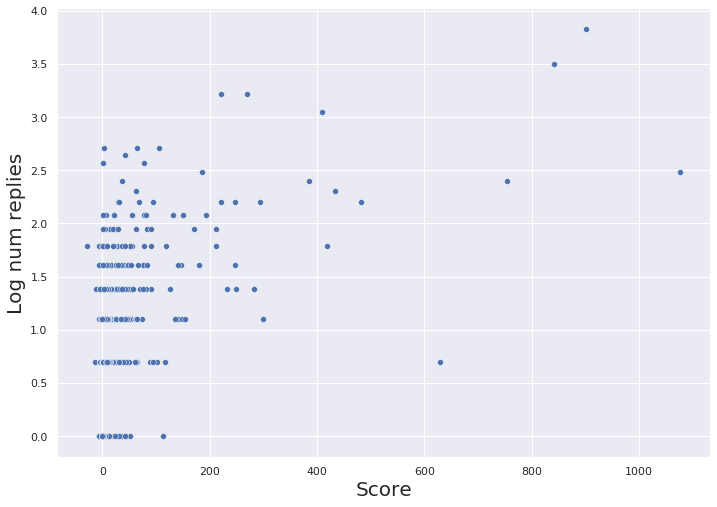

In [131]:
#random_ids_to_plot = set(random_ids_to_plot)
ax = sns.scatterplot(data=eng_df.loc[eng_df['id'].isin(random_ids_to_plot)],
               x='score',y='log_num_replies')
ax.set_xlabel("Score",fontsize=20)
ax.set_ylabel("Log num replies",fontsize=20)

#g.ax_marg_x.set_xlim(0, 100)
#g.ax_joint.set_xscale('log')
#g.ax_joint.set_yscale('log')

#ax.set(xscale="log")#, xscale="log")

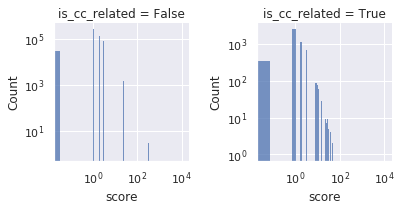

In [155]:
g = sns.FacetGrid(eng_df, col="is_cc_related", sharey=False)#, aspect=1.5)
g.map(sns.histplot, "score")
g.set(xscale="log", yscale="log")
plt.savefig('figs/log_log_score_dist.png',dpi=150,bbox_inches="tight")

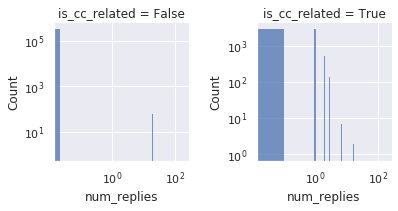

In [142]:
g = sns.FacetGrid(eng_df, col="is_cc_related", sharey=False)#, aspect=1.5)
g.map(sns.histplot, "num_replies")
g.set(yscale="log",xscale="log")#, yscale="log")

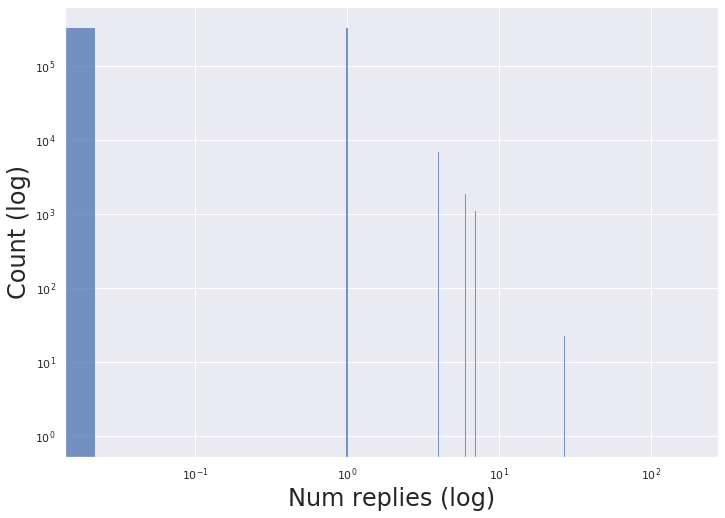

In [153]:
ax = sns.histplot(data=eng_df,x='num_replies')
ax.set(yscale="log")
ax.set(xscale="log")
ax.set_xlabel("Num replies (log)",fontsize=24)
ax.set_ylabel("Count (log)",fontsize=24)
plt.savefig('figs/log_log_num_replies_dist.png',dpi=150,bbox_inches='tight')

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


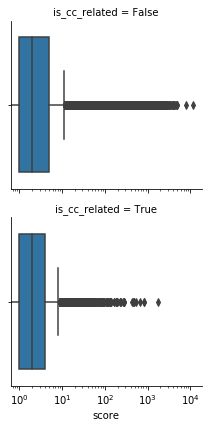

In [54]:
g = sns.FacetGrid(eng_df, row="is_cc_related", sharex=True)#, aspect=1.5)
g.map(sns.boxplot, "score")
g.set(xscale="log")#, yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


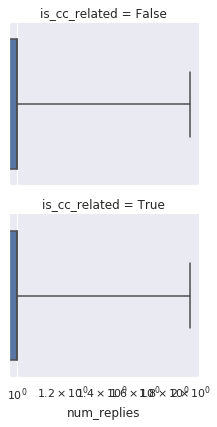

In [132]:
g = sns.FacetGrid(eng_df, row="is_cc_related", sharex=True)#, aspect=1.5)
g.map(sns.boxplot, "num_replies", showfliers=False)
g.set(xscale="log")#, yscale="log")

In [169]:
utt_eng_zip = list(zip([utt.meta['score'] for utt in filtered_gen_reddit_corpus.iter_utterances()],
                       [utt.id for utt in filtered_gen_reddit_corpus.iter_utterances()]))
                       #[utt.meta['downs'] for utt in filtered_gen_reddit_corpus.iter_utterances()]))

eng_df = pd.DataFrame({
    'score':[item[0] for item in utt_eng_zip],
    'id':[item[1] for item in utt_eng_zip]
    #'log_score':[np.log(item[0]+1) for item in utt_zip],
    #'ups':[item[1] for item in utt_eng_zip],
    #'log_ups':[np.log(item[1]+1) for item in utt_eng_zip],
    #'downs':[item[2] for item in utt_eng_zip],
    #'log_downs':[np.log(item[2]+1) for item in utt_eng_zip],
    #'upvote_ratio':[item[1]/(item[2]+.1) for item in utt_eng_zip]
})

eng_df.describe()

score
count  270501.000000
mean      151.237104
std      2393.677951
min      -698.000000
25%         1.000000
50%         2.000000
75%         8.000000
max    195757.000000

[None, None]

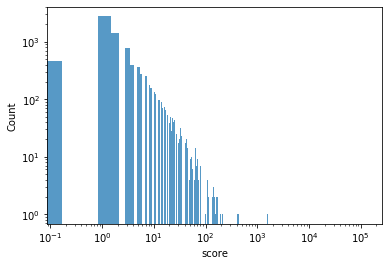

In [170]:
random_gen_reddit_sample_to_plot = set(np.random.choice(filtered_gen_reddit_corpus.get_utterance_ids(),
                                                   size=10000,replace=False))
ax = sns.histplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], x="score")
ax.set(xscale="log", yscale="log")

## Correlation of engagement with features of interest: arousal, NEs

### cmv delta-matched subsample


In [81]:
eng_df['senti_arousal_cats'] = [utt.meta['senti_arousal_cats'] 
                               for utt in filtered_cmv_subsample.iter_utterances()]
eng_df['senti_arousal_cats'] = eng_df['senti_arousal_cats'].apply(
    lambda x: '_'.join(sorted(x)))#.value_counts()
eng_df['senti_arousal_cats'].value_counts()

hi_neg_hi_pos        251081
hi_neg_lo_pos        156390
hi_pos_lo_neg        100206
lo_neg_lo_pos         82631
hi_neg_neut_pos       65974
lo_neg_neut_pos       46495
lo_pos_neut_neg       23121
hi_pos_neut_neg       20489
neut_neg_neut_pos     16557
Name: senti_arousal_cats, dtype: int64

In [109]:
eng_df['senti_arousal_cats'] = [utt.meta['senti_arousal_cat'] 
                               for utt in filtered_gen_reddit.iter_utterances()]
eng_df['senti_arousal_cats'] = eng_df['senti_arousal_cats'].apply(
    lambda x: '_'.join(sorted(x))
if type(x) == list else None)#.value_counts()
eng_df['senti_arousal_cats'].value_counts()

neut_neg_neut_pos    78822
lo_pos_neut_neg      32459
lo_neg_neut_pos      28458
hi_neg_neut_pos      28240
hi_pos_neut_neg      24467
hi_neg_hi_pos        23634
hi_neg_lo_pos        21948
lo_neg_lo_pos        17276
hi_pos_lo_neg        14934
Name: senti_arousal_cats, dtype: int64

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


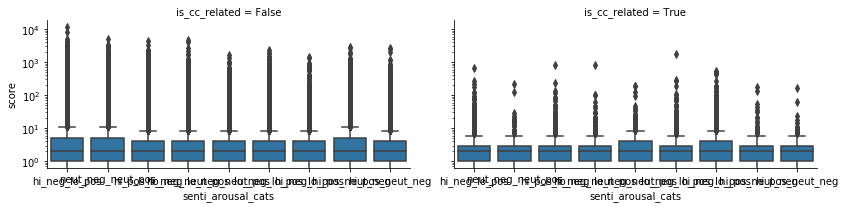

In [82]:
# Distribution over scores for different arousal categories--very even
g = sns.FacetGrid(eng_df, col = 'is_cc_related', aspect=2)
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=True,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


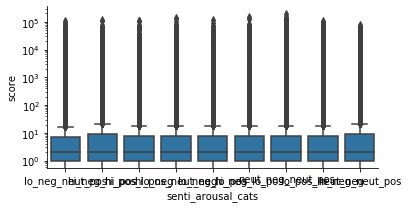

In [111]:
# Distribution over scores for different arousal categories--very even
g = sns.FacetGrid(eng_df, aspect=2)
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=True,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


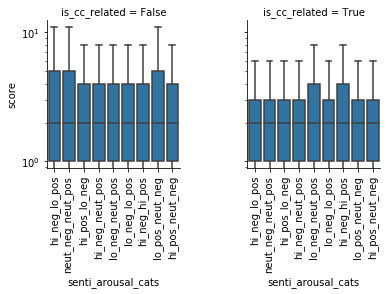

In [83]:
# Fig 1
# Same as above, without outliers--still very even
g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#g.set(yscale="log")
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('figs/score_v_senti_arousal.png',bbox_inches="tight",dpi=150)

[Text(0, 0, 'lo_neg_neut_pos'),
 Text(0, 0, 'hi_neg_hi_pos'),
 Text(0, 0, 'hi_pos_lo_neg'),
 Text(0, 0, 'hi_pos_neut_neg'),
 Text(0, 0, 'lo_neg_lo_pos'),
 Text(0, 0, 'hi_neg_lo_pos'),
 Text(0, 0, 'neut_neg_neut_pos'),
 Text(0, 0, 'lo_pos_neut_neg'),
 Text(0, 0, 'hi_neg_neut_pos')]

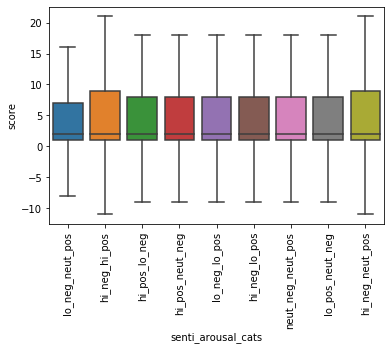

In [114]:
# Fig 
# Same as above, without outliers--still very even
#g = sns.FacetGrid(eng_df)#, col = 'is_cc_related')
ax = sns.boxplot(data=eng_df, x='senti_arousal_cats', y='score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#ax.set(yscale="log")
#for ax in g.axes.ravel():
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.savefig('figs/score_v_senti_arousal.png',bbox_inches="tight",dpi=150)

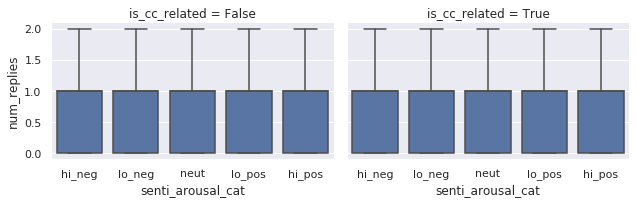

In [146]:
# Distribution over num_replies for different arousal categories--very even
#eng_df['senti_arousal_cat'] = [utt.meta['senti_arousal_cat'] for utt in filtered_cmv_subsample.iter_utterances()]
g = sns.FacetGrid(eng_df, col = 'is_cc_related', aspect=1.5)
g.map(sns.boxplot, 'senti_arousal_cat', 'num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#g.set(yscale="log")

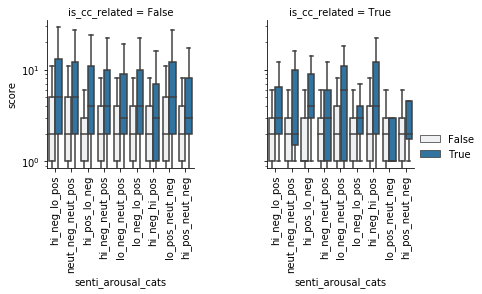

In [84]:
# Fig 2
# what about conditioned on whether or not a comment got a delta?
# score is still independent it seems of arousal for comments w/o delta
# HOWEVER, score varies across arousal category for comments w/ delta

g = sns.FacetGrid(eng_df, col = 'is_cc_related')#, hue='is_awarded_delta')
g.map_dataframe(sns.boxplot, x='senti_arousal_cats', y='score', showfliers=False,
           
               hue='is_awarded_delta')
g.set(yscale="log")
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

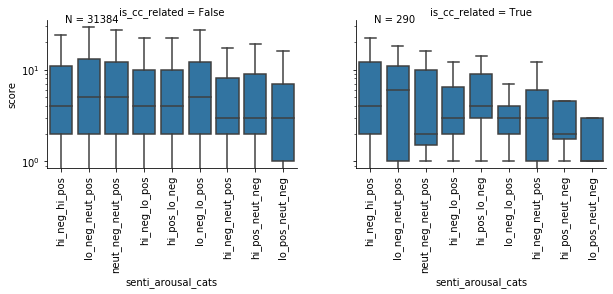

In [85]:
# Fig 3 
# looking only at comments w/ delta:
    # it seems for comments on non-climate-related posts, high arousal ~ high score
    # for comments on climate-related posts (much smaller N), situation is a bit non-linear
    
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.07, .99, f"N = {n}", transform=ax.transAxes)

g = sns.FacetGrid(eng_df.loc[eng_df['is_awarded_delta']], col = 'is_cc_related', aspect=1.5)
g.map_dataframe(sns.boxplot, x='senti_arousal_cats', y='score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")
g.map_dataframe(annotate)
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

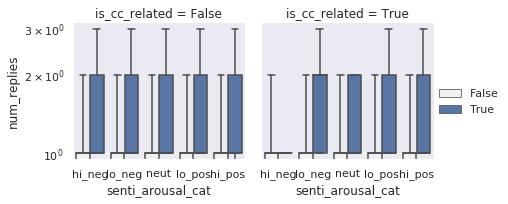

In [136]:
# what about conditioned on whether or not a comment got a delta?
# score is still independent it seems of arousal for comments w/o delta
# HOWEVER, score varies across arousal category for comments w/ delta

g = sns.FacetGrid(eng_df, col = 'is_cc_related')#, hue='is_awarded_delta')
g.map_dataframe(sns.boxplot, x='senti_arousal_cat', y='num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
               hue='is_awarded_delta')
g.set(yscale="log")
g.add_legend()

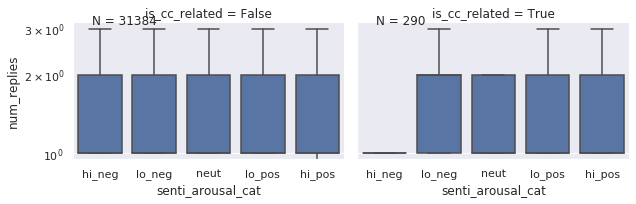

In [139]:
g = sns.FacetGrid(eng_df.loc[eng_df['is_awarded_delta']], col = 'is_cc_related', aspect=1.5)
g.map_dataframe(sns.boxplot, x='senti_arousal_cat', y='num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")
g.map_dataframe(annotate)

In [157]:
# Does score differ for comments w/ and w/o people?

eng_df['has_person'] = [len(filtered_cmv_subsample.get_utterance(utt_id).meta['cleaned_entities_in_text']) > 0
                              for utt_id in random_ids_to_plot]

g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'has_person', 'score', showfliers=True)
g.set(yscale="log")

KeyError: 'cleaned_entities_in_text'

In [ ]:
# Add deltas into the picture
sns.boxplot(data=eng_df, x='has_person', y='score', showfliers=False,
           hue='is_awarded_delta')

### General Reddit subsample

[None]

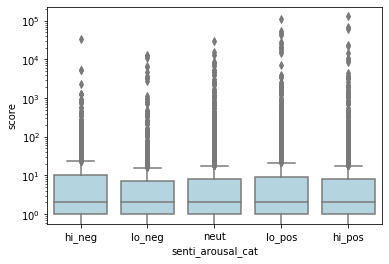

In [176]:
eng_df['senti_arousal_cat'] = [utt.meta['senti_arousal_cat']
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]
ax = sns.boxplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], 
                 x='senti_arousal_cat', y='score', showfliers=True,
               order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],color='lightblue')
ax.set(yscale="log")

[None]

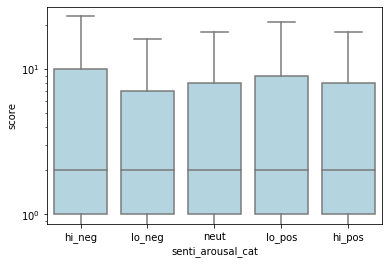

In [178]:
# without outliers
ax = sns.boxplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], 
                 x='senti_arousal_cat', y='score', showfliers=False,
               order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],color='lightblue')
ax.set(yscale="log")

In [193]:
eng_df['has_person'] = [len(utt.meta['cleaned_entities_in_text']) > 0
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]
eng_df['has_person'].value_counts()

False    270400
True        101
Name: has_person, dtype: int64

[None]

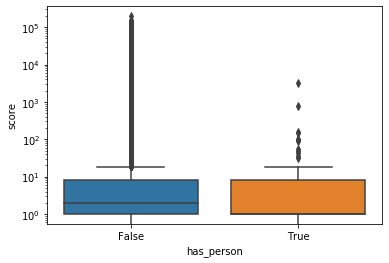

In [194]:
eng_df['has_person'] = [len(utt.meta['cleaned_entities_in_text']) > 0
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]

ax = sns.boxplot(data=eng_df, 
                 x='has_person', y='score', showfliers=True)
ax.set(yscale="log")

# Comments receiving deltas vs. not

## Add +/-delta; num. deltas to meta

Maintain list of comments awarded deltas by:

iterating through all comment utterances

if: speaker.isin(known_mods) AND comment begins with a CUE_START
    
    save: id of mod comment, 
    comment awarding the delta (mod comment's reply_to parent),
    comment awarded the delta (comment awarding the delta's reply_to)

In [7]:
# CUE_STARTS = {'Confirmed: 1 delta awarded to /u/',
#              'Confirmed - 1 delta awarded to /u/',
#              'The moderators have confirmed, ei'}

# with open(os.path.join(DISK_IO_DIR,'deltalog.tsv'),'w') as f:
#     f.write('{}\t{}\t{}\n'.format('logging_utt_id','awarding_utt_id',
#                                   'awarded_utt_id'))
#     for utterance in tqdm(corpus.iter_utterances()):
#         if utterance.speaker.id in known_cmv_mods\
#         and (utterance.text.startswith('Confirmed: 1 delta awarded to /u/')\
#              or utterance.text.startswith('Confirmed - 1 delta awarded to /u/')\
#              or utterance.text.startswith('The moderators have confirmed, ei')):
#             logging_comment_id = utterance.id
#             awarding_comment_id = utterance.reply_to
#             awarded_comment_id = corpus.get_utterance(awarding_comment_id)\
#                                         .reply_to
#             f.write('{}\t{}\t{}\n'.format(
#                 logging_comment_id,awarding_comment_id,
#                     awarded_comment_id))

deltalog = pd.read_csv(os.path.join('/u/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit',
                                    'deltalog.tsv'),
                      sep='\t',header=0)
delta_awarded_utt_ids = set(deltalog['awarded_utt_id'].values)
delta_counts = deltalog['awarded_utt_id'].value_counts()
utt_id2num_deltas = {id_: delta_counts[id_] for id_ in delta_counts.index.values}

# Update meta to include whether an utterance was awarded a delta or not
def is_awarded_delta(utterance_id):
    return utterance_id in delta_awarded_utt_ids

def num_deltas(utterance_id):
    if utterance_id in delta_awarded_utt_ids:
        return utt_id2num_deltas[utterance_id]
    else:
        return 0

for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)
            utt.meta['num_deltas'] = num_deltas(utt.id)

NameError: name 'corp_to_analyze' is not defined

Examine comments getting the most deltas:

In [58]:
delta_counts

t1_d498qau    36
t1_h4hrvgr    28
t1_ehuop0f    15
t1_cg7nbsu    14
t1_c9xf9b1    13
              ..
t1_h0735d6     1
t1_gm1gfmm     1
t1_dozxucl     1
t1_eh7bzti     1
t1_ctsigef     1
Name: awarded_utt_id, Length: 33702, dtype: int64

In [ ]:
# # examples
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] for utt_id in delta_counts.index.values[:10]]})

Within cc-related discussions:

In [65]:
cc_ids = set(corp_to_analyze['matched_cc_cmv_subsample'].get_utterance_ids())
print(len(cc_ids))
delta_counts.loc[delta_counts.index.isin(cc_ids)]

6349


t1_dl1zf88    2
t1_dh1bhuq    2
t1_f3xknsc    2
t1_efr2kcr    1
t1_dhd1ud8    1
             ..
t1_ha2hgif    1
t1_h8x5n7z    1
t1_e7gts5n    1
t1_h3fx0yw    1
t1_d8vwrpw    1
Name: awarded_utt_id, Length: 290, dtype: int64

In [ ]:
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] 
#                            for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]]})

In [ ]:
# for corp_name in corp_to_analyze:
#     if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
#         sns.displot([utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
#                    log_scale=(False,True))
#         #plt.set_yscale
#         plt.title(f'Distribution of deltas in {corp_name}',fontsize=22)
#         plt.xlabel("Num deltas awarded comment",fontsize=20)
#         plt.ylabel("Num comments",fontsize=20)
#         plt.savefig(f'figs/dist_num_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

In [ ]:
#for corp_name in corp_to_analyze:
    if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'num_deltas': [utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            'score': [utt.meta['score'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            #'num_people':[len(utt.meta['people']) for utt in corp_to_analyze[corp_name].iter_utterances()],
            'senti_arousal_cat':[utt.meta['senti_arousal_cat']
                                 if utt.meta['senti_arousal_cat']
                                else None
                                for utt in corp_to_analyze[corp_name].iter_utterances()],
        })
        for i,val in enumerate(['pos','neg']):
            to_plot_df['{}_arousal'.format(val)] = to_plot_df['senti_arousal_cat'].apply(
                lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                if type(x) == str else None
            )
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
        sns.scatterplot(data=to_plot_df,x='num_deltas',y='score')
        plt.title("Score vs. num deltas")

In [ ]:
# g = sns.FacetGrid(to_plot_df, aspect=1.5, col='senti_arousal_cat')
# g.map(sns.histplot, 'num_deltas', log_scale=(False,True))
# plt.title("Num deltas vs. arousal")

In [ ]:
# # Temporal trend
# for corp_name in corp_to_analyze:
#     if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:

#         counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

#         for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#             if utt.timestamp:
#                 year = datetime.utcfromtimestamp(utt.timestamp).year
#                 if utt.meta['is_cc_related']:
#                     if utt.meta['is_awarded_delta']:
#                         counts_by_bin[year]['climate change']['awarded delta'] += 1
#                     else:
#                         counts_by_bin[year]['climate change']['not awarded delta'] += 1
#                 else:
#                     if utt.meta['is_awarded_delta']:
#                         counts_by_bin[year]['other']['awarded delta'] += 1
#                     else:
#                         counts_by_bin[year]['other']['not awarded delta'] += 1
                        
#         years = list(range(2013,2022))
#         topics = ['climate change','other']
#         classes = ['awarded delta','not awarded delta']
#         to_plot_df = pd.DataFrame({
#             'year':[item for sublist in 
#                     [[y]*len(topics)*len(classes) for y in years]
#                     for item in sublist],
#             'topic':[item for sublist in 
#                     [[t]*len(classes) for t in topics]
#                     for item in sublist]*len(years),
#             'class':classes*len(years)*len(topics),
#             'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
#         })
        
#         per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
#         to_plot_df['percent'] = to_plot_df.apply(
#             lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
#                                 .loc[x['topic']]['count'],
#             axis=1
#         )

#         plt.rcParams['figure.figsize'] = [10, 5]
#         sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='awarded delta'],
#                    x='year',y='percent',hue='topic',ci='sd')
#         plt.xlabel('')
#         plt.ylabel('')
#         plt.xticks(fontsize=17)
#         plt.yticks(fontsize=14)
#         plt.title('Percentage of comments awarded ∆ over time',fontsize=24)
#         plt.legend(title='',fontsize=15)
#         sns.despine()
#         plt.savefig('figs/pct_comments_awarded_delta_over_time_{}.png'.format(corp_name),
#                     dpi=200,bbox_inches="tight")

Examples of comments awarding deltas, which explain why user was persuaded:

In [289]:
comments_awarding_deltas_climate_threads = [
    utt_id for utt_id in deltalog['awarding_utt_id'].values
    if corpus.get_utterance(utt_id).meta['is_cc_related']
]
print(len(comments_awarding_deltas_climate_threads))

pd.DataFrame({
    'id':comments_awarding_deltas_climate_threads,
    'text':[corpus.get_utterance(utt_id).text
           for utt_id in comments_awarding_deltas_climate_threads]
})

319


id  \
0    t1_ef9tzs5   
1    t1_h8xaroo   
2    t1_ejjs8tf   
3    t1_fhqpeoe   
4    t1_hb50dh3   
..          ...   
314  t1_ds5kees   
315  t1_dh56ffl   
316  t1_dcsvdvw   
317  t1_et321b6   
318  t1_dab19de   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                ∆ Yeah that's honestly a solid point it would be nice if the government could just handle it.  So another solution would bne if we could just stop being so over hyped about the issue in general.\n\nOnly issue is that I think we are in way too deep for that to work.  It is at the forefront of public policy right now.  Plus the changes that liberals are proposing would cost trillions of dollars and have huge impact on peoples lives....which leads to yellow vests.    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [deleted]  
2    Your point about diminishing returns on greenhouse gas emissions (because of common infrastructure) is a good one. Indeed, I had been imagining that Western population growth leads to emissions growth in a linear fashion. So I guess I'll give you a !delta for that.\n\nHowever, I still maintain my main view that having children isn't a good solution to climate change, on account of the fact that scientific engagement in western countries just isn't high enough. Most people are not involved in energy innovation and research, which means they're producing carbon emissions without contributing to the betterment of these technologies. Maybe if my country (USA) funded its schools better and made more of a conscious drive to shift the labor force towards energy research, then I'd feel differently about this.\n\nAlso, I think that the concept of diminishing returns could apply to energy innovation as well.  
3                                                                                                           

## Which features matter in changing people's minds?

List of features:
* engagement-related features
    * people/messengers
    * +/- arousal (based on SentiStrength)
    * EmoLex
* OG CMV paper features
    * non-textual features
        * entry time
        * len of back-and-forth
        * number of participants
    * textual features
        * interplay-related features
        * word category-based features
        * word score-based features
        * entire argument features
        * markdown formatting features
* DeSMOG features
    
    
NB: OG CMV paper uses different set-up to test importance of features by finding unsuccessful argument with highest Jaccard similarity to successful argument comment and training classifier to make binary prediction as to which one was successful. Intuition: control for content.

### Compute LOR values

In [135]:
def sub_url_with_domain(utt):
    json_obj = get_stanza_json(utt)
    new_json_obj = []
    utt_urls = utt.meta['text_urls']
    utt_domains = utt.meta['url_domains']
    for ix,utt_url in enumerate(utt_urls):
        for sent in json_obj['parse']:
            json_list = []
            for word in sent:
                #print(word['text'],utt_url)
                if word['text'] == utt_url:
                    #print('url found!')
                    word['lemma'] = utt_domains[ix]
                json_list.append(word)
            new_json_obj.append(json_list)
    return {'parse':new_json_obj,'ents':json_obj['ents']}

In [150]:
utt = corp_to_analyze['matched_cmv_subsample'].random_utterance()
print(utt.text)
print(utt.meta['text_urls'])

I don't think there is a lack of reciprocity.  The rule of thumb is: if the money is going to support the lifestyle/income of a human being, it is taxed.  If it is an expenditure that would not be undertaken but for the business, it is not taxed.

So for example, the business can deduct the salaries it pays employees - but those employees must pay tax.  Some entertainment and food expenses are not deductible because it is considered that they would have been spent even if not for the business.  The legal test for deductions of meals and entertainment is [pretty strict](http://www.irs.gov/publications/p463/ch02.html).  Though people commit tax fraud on it a lot.

If you were to operate your self-employed business entirely through an LLC, you would probably not see any meaningful difference in your tax situation, because being a corporation doesn't change how you're taxed.  Unless you became a C corp, then you'd be taxed even more.

Last point, there is a deduction from taxes for the bas

In [151]:
subbed_json_obj = sub_url_with_domain(utt)
json_obj = get_stanza_json(utt)

In [152]:
json_obj['ents'] == subbed_json_obj['ents']

True

In [153]:
for m,sent in enumerate(json_obj['parse']):
    for n,word in enumerate(sent):
        if word != subbed_json_obj['parse'][m][n]:
            print(word)
            print(subbed_json_obj['parse'][m][n])

{'id': 16, 'text': 'http://www.irs.gov/publications/p463/ch02.html).', 'lemma': 'http://www.irs.gov/publications/p463/ch02.html).', 'upos': 'X', 'xpos': 'ADD', 'feats': None, 'head': 13, 'deprel': 'appos', 'start_char': 576, 'end_char': 624}
{'id': 16, 'text': 'http://www.irs.gov/publications/p463/ch02.html).', 'lemma': 'irs', 'upos': 'X', 'xpos': 'ADD', 'feats': None, 'head': 13, 'deprel': 'appos', 'start_char': 576, 'end_char': 624}


In [107]:
#lor_per_corp = defaultdict(dict)

First get counts:

In [ ]:
UPOS = False
XPOS = False
DEPPARSE = False
HEADS = False

sample1_set = set([utt.id for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
                  if utt.meta['is_awarded_delta']])
print(f"Found {len(sample1_set)} ids in sample 1.")

counts_bare = get_counts_for_lor(corp_to_analyze['matched_cmv_subsample'],
                         sample1_set,
                         [],
                         'matched_cmv_subsample_deltas_vs_no_deltas_url_subbed_gen_reddit_switchboard_prior',
                         cache=False,
                         skip_background=True,
                         min_df=5,
                         upos=UPOS,
                         xpos=XPOS,
                         depparse=DEPPARSE,
                         heads=HEADS)

Found 24238 ids in sample 1.
Creating count matrix for +/- samples with ngram range (1, 2), min_df = 5, lowercasing = True, upos = False, xpos = False, depparse = False, and heads = False...


11555it [10:39, 25.01it/s]

In [347]:
counts_bare.keys()

dict_keys([])

In [352]:
for corp_name in ['matched_cmv_subsample']:#corp_to_analyze:
#     unweighted_lor_upos = do_weighted_lor(counts_upos['counts1'], counts_upos['counts2'], 
#                                          counts_upos['prior'], 
#                                          prior_weight=1, 
#                                          counts1_weight=1, 
#                                          counts2_weight=1, 
#                                          verbose=False)
#     lor_per_corp[corp_name]['unweighted_upos'] = unweighted_lor_upos
    weighted_lor_bare = do_weighted_lor(counts_bare['corpus1'], counts_bare['corpus2'], 
                                         counts_bare['prior'], 
                                         prior_weight=2, 
                                         counts1_weight=1, 
                                         counts2_weight=20, 
                                         verbose=False)
    lor_per_corp[corp_name]['weighted_bare'] = weighted_lor_bare
#     weighted_lor_upos = do_weighted_lor(counts_upos['counts1'], counts_upos['counts2'], 
#                                          counts_upos['prior'], 
#                                          prior_weight=100, 
#                                          counts1_weight=1, 
#                                          counts2_weight=15, 
#                                          verbose=False)
#     lor_per_corp[corp_name]['weighted_upos'] = weighted_lor_upos
    
#     unweighted_lor_no_pos = do_weighted_lor(counts_no_pos['counts1'], counts_no_pos['counts2'], 
#                                           counts_no_pos['prior'], 
#                                           prior_weight=1, 
#                                           counts1_weight=1, 
#                                           counts2_weight=1, 
#                                           verbose=False)
#     lor_per_corp[corp_name]['unweighted_no_pos'] = unweighted_lor_no_pos
#     weighted_lor_no_pos = do_weighted_lor(counts_no_pos['counts1'], counts_no_pos['counts2'], 
#                                           counts_no_pos['prior'], 
#                                           prior_weight=100, 
#                                           counts1_weight=1, 
#                                           counts2_weight=15, 
#                                           verbose=False)
#     lor_per_corp[corp_name]['weighted_no_pos'] = weighted_lor_no_pos

Size of class1: 11162442
Size of class2: 11203709
Size of prior: 128626746


In [339]:
# CC only, weights = 1:20; 100(prior)
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('co2', 3.907997870455982),
 ('climate', 2.698645632476566),
 ('dioxide', 2.696234720776932),
 ('carbon', 2.6543360872875432),
 ('carbon dioxide', 2.5743965754221665),
 ('ocean', 2.4684929270502853),
 ('www skepticalscience', 2.350813054036504),
 ('the 97', 2.34743070583246),
 ('skepticalscience', 2.332886118808238),
 ('skepticalscience com', 2.332886118808238),
 ('greenhouse', 2.206393589553862),
 ('natural cycle', 2.14937329401101),
 ('atmosphere be', 2.1228267072377336),
 ('warming', 2.096533121688926),
 ('of co2', 2.0879686651026836),
 ('methane', 2.072434538211863),
 ('climate change', 2.056957751801267),
 ('biodiversity', 2.0151180531207618)]

In [341]:
', '.join([x[0] for x in sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)])

'co2, climate, dioxide, carbon, carbon dioxide, ocean, www skepticalscience, the 97, skepticalscience, skepticalscience com, greenhouse, natural cycle, atmosphere be, warming, of co2, methane, climate change, biodiversity'

In [353]:
# all CMV, weights = 1:15; 2(prior)
sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
 for w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
if abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('the', 11.65223593438836),
 ('and', 9.044503936958723),
 ('of', 8.830251953672748),
 ('in', 8.495489394793362),
 ('be', 6.935466565549153),
 ('to', 6.672344854048106),
 ('org', 6.378605205762511),
 ('this', 5.698767242889603),
 ('they', 5.060941526720041),
 ('on', 4.823586586174394),
 ('that', 4.790308555141541),
 ('but', 4.757179591663222),
 ('with', 4.624515535407693),
 ('for', 4.603754234044307),
 ('delta', 4.458204454307972),
 ('of the', 4.309174770514293),
 ('https en', 4.285298831864885),
 ('org wiki', 4.241611609072515),
 ('en', 4.2236784848163),
 ('it', 4.180457274827762),
 ('wikipedia', 4.119898932602194),
 ('wikipedia org', 4.108473012634816),
 ('en wikipedia', 4.096150259645583),
 ('at', 4.072908946144148),
 ('in the', 4.04918598931869),
 ('as', 3.9444962675971302),
 ('pdf', 3.8483769056064707),
 ('from', 3.767372007755723),
 ('often', 3.7574842418604413),
 ('might', 3.6145568063771374),
 ('more', 3.566763120142677),
 ('good', 3.5611504463673147),
 ('he', 3.489783708538045

In [208]:
'research' in all_empath_sci_feats

True

In [81]:
# weights = 1:20
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('the', 4.4302531538826235),
 ('co2', 4.016102779647343),
 ('a', 3.6958391316434254),
 ('%', 3.27900082888966),
 ('poor', 3.0976039497792205),
 ('experiment', 3.0424920188000733),
 ('dioxide', 3.0424920188000733),
 ('ocean', 2.954950657988805),
 ('carbon', 2.8240499604875784),
 ('CCP', 2.753984186194391),
 ('be', 2.6021516116289285),
 ('cycle', 2.5479712046109273),
 ('per', 2.5382071565705706),
 ('gallon', 2.448384646847179),
 ('Science', 2.448384646847179),
 ('greenhouse', 2.41632292750537),
 ('97', 2.413320700127313),
 ('action', 2.401585299286658),
 ('rich', 2.3418134481657575),
 ('ecosystem', 2.334966622594344),
 ('biodiversity', 2.325489454781162),
 ('release', 2.266239008606097),
 ('seaweed', 2.2661594089949384),
 ('methane', 2.2517828462681706),
 ('organic', 2.2405143977054625),
 ('Chinese', 2.2405143977054625),
 ('Climate', 2.221307313261586),
 ('atmosphere', 2.191767559255129),
 ('battery', 2.176345301888634),
 ('effect', 2.153029738413637),
 ('water', 2.1413696008766516),
 (

In [147]:
# cc-only; weights = 1:15; with switchboard + gen reddit background
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('co2', 3.073409887010761),
 ('poor', 3.0468640464438366),
 ('experiment', 2.935999024612736),
 ('dioxide', 2.935999024612736),
 ('CCP', 2.8259325333936167),
 ('Science', 2.5652632762584426),
 ('ocean', 2.417681387726944),
 ('gallon', 2.3718752019230416),
 ('seaweed', 2.362943692821538),
 ('per', 2.354143934908629),
 ('rich', 2.251348124565579),
 ('preservation', 2.2345503013288663),
 ('chemistry', 2.2325408051593065),
 ('biodiversity', 2.2325408051593065),
 ('cycle', 2.228912483832722),
 ('%', 2.203216550745488),
 ('97', 2.1494354909751343),
 ('release', 2.1341811718403463),
 ('battery', 2.112940911364332),
 ('al.', 2.0945069435538954),
 ('ecosystem', 2.072538167736246),
 ('methane', 2.021694522720207),
 ('butcher', 1.9727312617433763),
 ('spend', -1.9854550035112353),
 ('problem', -2.1041447334295675),
 ('say', -2.165822551593976),
 ('have', -2.1837199073610107),
 ('civilization', -2.186938705088744),
 ('economist', -2.2009175638399103),
 ('drought', -2.303192177434896),
 ('you', -2

In [96]:
# cc-only; weights = 1:15; no background (just 2 samples summed)
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('poor', 3.713671364499459),
 ('co2', 3.2295807306411852),
 ('experiment', 3.203951655197919),
 ('dioxide', 2.9911401258015),
 ('per', 2.8989588291733894),
 ('CCP', 2.844079322574466),
 ('rich', 2.7421704393263613),
 ('Science', 2.5946945876398217),
 ('ocean', 2.5735458269633043),
 ('release', 2.566973670172775),
 ('battery', 2.4794890558012255),
 ('gallon', 2.404942741828649),
 ('cycle', 2.401765556567715),
 ('seaweed', 2.387298764123448),
 ('%', 2.3487778703293536),
 ('chemistry', 2.3386072864477616),
 ('biodiversity', 2.265351694926317),
 ('preservation', 2.2587407880686805),
 ('97', 2.19121246662543),
 ('local', 2.172246272776472),
 ('ecosystem', 2.132717534315285),
 ('action', 2.125024904123274),
 ('al.', 2.118505571502948),
 ('unit', 2.11660533465535),
 ('methane', 2.0680575117728566),
 ('20', 1.9951863705248571),
 ('butcher', 1.99025136273504),
 ('greenhouse', 1.9743014656083901),
 ('organic', 1.9622396003718359),
 ('Chinese', 1.9622396003718359),
 ('fertilizer', 1.957498656869

In [ ]:
# # all CMV; weights = 1:15; with switchboard + gen reddit background
# sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [145]:
# # weight = 1:10
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [146]:
# # weight = 1:5
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

### Test RQs

##### Draw random sample from -delta comments for more even sample sizes for LOR (NO LONGER NEEDED w/ WEIGHTED LOR)

In [175]:
# cc_ids = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
#                          if utt.meta['is_cc_related']]
# non_delta_ids_to_keep = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
#                          if not utt.meta['is_awarded_delta']
#                         and utt.meta['is_cc_related']]
# delta_ids_to_keep = set(cc_ids).difference(set(non_delta_ids_to_keep))
# print('Found {} comments w/ deltas.'.format(len(delta_ids_to_keep)))

# random_sample_size = len(delta_ids_to_keep)
# print("Drawing random sample of equal size of {} from {} non-delta comments total for LOR balance.".format(
#     random_sample_size,len(non_delta_ids_to_keep)))

# random_non_delta_ids_for_lor = list(np.random.choice(non_delta_ids_to_keep,size=random_sample_size,replace=False))
# random_ids_for_lor = set(list(delta_ids_to_keep) + list(random_non_delta_ids_for_lor))
# print("Final size of delta-balanced sample of climate-related and non-climate comments:",len(random_ids_for_lor))

In [176]:
# random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# # balanced for +/- delta
# random_sample.print_summary_stats()

In [177]:
# cc_random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# # balanced for +/- delta
# cc_random_sample.print_summary_stats()

##### RQ1: Is there a messenger effect for changing people's minds?

--> Are comments with deltas more likely to have people/named entities 
compared to comments not receiving deltas?

--> Do people/named entities tend to have large, positive LOR values?

--> Calculate LOR values for all people/named entities and look at their distributions--tend to skew positive?

In [ ]:
# # Plot distribution over +/- person for comments +/- deltas

# for corp_name in corp_to_analyze:
#     to_plot_df = pd.DataFrame({
#         'is_awarded_delta': [utt.meta['is_awarded_delta']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#         'num_deltas': [utt.meta['num_deltas']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'has_person': [len(utt.meta['people']) > 0
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'num_people': [len(utt.meta['people'])
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3']

#     })

#     g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
#     g.map(sns.histplot, "num_people")
#     g.axes[0][0].set_yscale('log')
#     g.axes[0][1].set_yscale('log')
#     plt.savefig(f'figs/people_counts_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")
    
#     g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
#     g.map(sns.histplot, "has_person")
#     g.axes[0][0].set_yscale('log')
#     g.axes[0][1].set_yscale('log')
#     plt.savefig(f'figs/people_boolean_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")
#     plt.show()
    
#     fig, ax = plt.subplots()
#     fig.set_size_inches(4, 7)
#     sns.barplot(data=to_plot_df, x='is_awarded_delta',y="num_people", ax=ax)
#     ax.set_xlabel('')
#     ax.set_xticklabels(['-delta','+delta'],fontsize=18)
#     ax.set_ylabel('Number of people in comment',fontsize=18)
#     sns.despine()
#     plt.savefig(f'figs/people_deltas_vs_no_deltas_barplot_{corp_name}.png',dpi=150,bbox_inches='tight')
#     plt.show()

In [286]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['num_people'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['num_people'].values)

Ttest_indResult(statistic=1.9118281701798976, pvalue=0.05594321688115575)

In [210]:
# Check if people show up in sig. LOR
{w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
for w in counted_people.keys()
if w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}

{'anakin': 1.9306656970520502,
 'harry': 2.442573572315126,
 'jesus': 2.8013219047876907,
 'phil': 2.158466487794158,
 'john': 2.1921700706132103,
 'steve': 2.0803680343541684,
 'trayvon': -1.9575906607049192,
 'kanye': 2.1267502062667853,
 'dale': 2.673781660435547,
 '4chan': 3.2597054143249267,
 'steven': 3.8705827514950935,
 'zimmerman': -2.447521790753426,
 'fox': 1.9767793468978048,
 'wayne': 1.9621376238674135,
 'alito': 2.0890688543229308,
 'sherlock': 2.9155502282310977,
 'mrna': 3.6249980626315232,
 'simon': 2.1706929062820626,
 'jane': 2.3909312706241526}

In [287]:
# Check if people show up in sig. LOR
{w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
for w in counted_people.keys()
if w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}

{}

###### RQSci: Does science help sway opinions?

In [ ]:
# # Plot distribution over #sci_words for comments +/- deltas

# for corp_name in corp_to_analyze:
#     to_plot_df = pd.DataFrame({
#         'is_awarded_delta': [utt.meta['is_awarded_delta']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#         'num_deltas': [utt.meta['num_deltas']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'science': [utt.meta['science']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],
#         'science_nyt': [utt.meta['science_nyt']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],
#         'science_reddit': [utt.meta['science_reddit']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                           if utt.id[:2] != 't3'],
#         'science_fic': [utt.meta['science_fic']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],

#     })
#     for col in ['num_deltas','science','science_nyt','science_reddit','science_fic']:
#         to_plot_df[f'log_{col}'] = to_plot_df[col].apply(lambda x: math.log(x+1))

# #     fig, axes = plt.subplots(4,2,figsize=(8,15))
# #     row_ix = 0
# #     for delta_ix,delta_bool in enumerate([False,True]):
# #         for cat_ix,empath_cat in enumerate(['science','science_nyt','science_reddit','science_fic']):
# #             ax_ = axes[cat_ix][delta_ix]
# #             sns.histplot(to_plot_df.loc[(to_plot_df['is_awarded_delta']==delta_bool)],
# #                             x=empath_cat,ax=ax_)
# #             ax_.set_xlabel(f"Count of {empath_cat} features",fontsize=13)
# #             ax_.set_yscale('log')
# #             if delta_ix % 2 == 0:
# #                 ax_.set_ylabel("#Comments",fontsize=15)
# #                 if cat_ix == 0:
# #                     ax_.set_title('not awarded delta',fontsize=18)
# #             else:
# #                 ax_.set_ylabel("")
# #                 if cat_ix == 0:
# #                     ax_.set_title('awarded delta',fontsize=18)
# #             sns.despine()
# #     plt.savefig(f'figs/dists_empath_sci_feats_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

#     fig, axes = plt.subplots(1,4,figsize=(10,4),sharey=True)
#     for cat_ix,empath_cat in enumerate(['science','science_nyt','science_reddit','science_fic']):
#         ax_ = axes[cat_ix]
#         sns.barplot(data=to_plot_df,x='is_awarded_delta',y=empath_cat,ax=ax_,ci=95)
#         ax_.set_xlabel('')
#         ax_.set_xticklabels(['-delta','+delta'],fontsize=14)
#         ax_.set_ylim([0,1.3])
#         ax_.set_ylabel('')
#         ax_.set_title(f'{empath_cat}',fontsize=14)
#         sns.despine()
#     plt.savefig(f'figs/barplots_empath_sci_feats_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches='tight')

In [293]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science'].values)

Ttest_indResult(statistic=3.685231098569228, pvalue=0.00023039937215591438)

In [294]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_nyt'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_nyt'].values)

Ttest_indResult(statistic=2.0158037843727756, pvalue=0.04386255800801137)

In [295]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_reddit'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_reddit'].values)

Ttest_indResult(statistic=1.0015507354642577, pvalue=0.3165988057867682)

In [296]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_fic'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_fic'].values)

Ttest_indResult(statistic=3.009314222824129, pvalue=0.002628665963912681)

In [264]:
# Check if sci_feats show up in sig. LOR
all_empath_sci_feats = set([item for sublist in empath_sci_feats.values() for item in sublist])

sorted({w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
for w in all_empath_sci_feats
if w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}.items(),key=lambda x:x[1],reverse=True)

[('research', 4.309916014662114),
 ('study', 3.889331733568624),
 ('improve', 3.3018885017899806),
 ('critical', 3.037568272902809),
 ('development', 2.9749460027468566),
 ('benefit', 2.6117792121143064),
 ('researcher', 2.343351001221101),
 ('establish', 2.296586711057056),
 ('philosophy', 2.2809980895352164),
 ('accomplish', 2.2344748490095547),
 ('modify', 2.176347762098813),
 ('access', 2.039409590772334),
 ('function', 2.0304489756280772),
 ('limit', 1.9948744906612708),
 ('scientist', 1.9920246207603145),
 ('evaluate', 1.9752297722013117),
 ('present', 1.9054237394453248),
 ('review', -3.3841281454538312),
 ('subject', -7.295347094902295),
 ('appeal', -18.647944328848926)]

In [297]:
sorted({w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
for w in all_empath_sci_feats
if w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}.items(),key=lambda x:x[1],reverse=True)

[]

In [300]:
to_plot_df.loc[to_plot_df['lor']<-3]

Empty DataFrame
Columns: [word, lor]
Index: []

outliers:         word        lor
47    review  -3.384128
53   subject  -7.295347
171   appeal -18.647944


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


outliers: Empty DataFrame
Columns: [word, lor]
Index: []


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


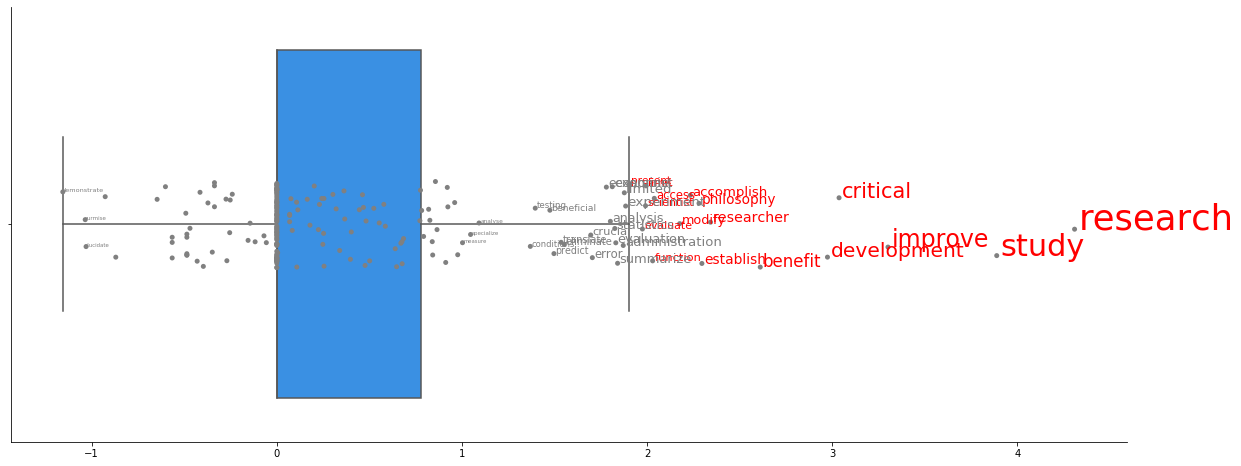

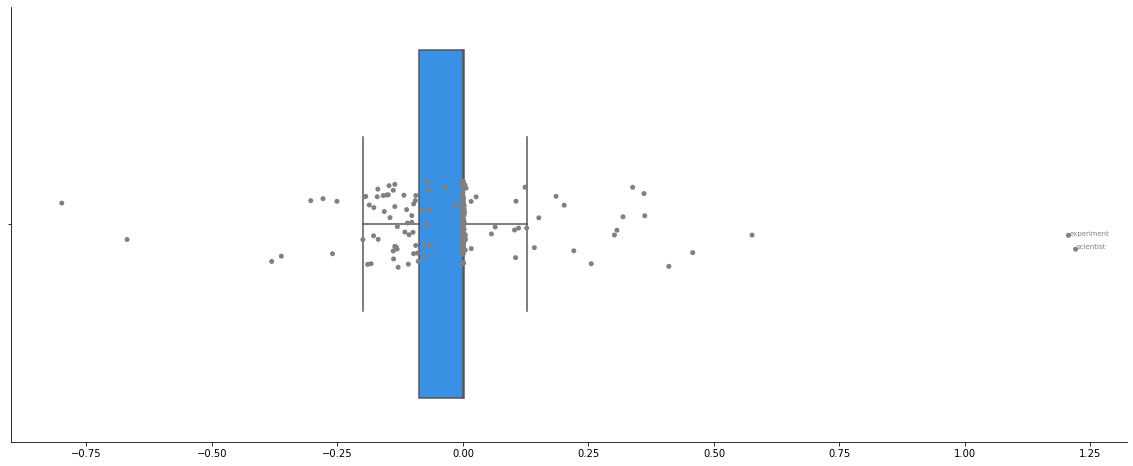

In [342]:
for corp_name in corp_to_analyze:
    to_plot_df = pd.DataFrame({
        'word': [w for w in all_empath_sci_feats],
        'lor': [lor_per_corp[corp_name]['weighted_bare'][w]
                   for w in all_empath_sci_feats]
    })
    
    print('outliers:',to_plot_df.loc[to_plot_df['lor']<-3])
    
    to_plot_df = to_plot_df.loc[to_plot_df['lor']>-3].copy()

    fig, ax = plt.subplots(figsize=(20,8))
    sns.boxplot(data=to_plot_df, x='lor', ax=ax, color='dodgerblue',showfliers=False)
    sns.stripplot(data=to_plot_df, x='lor', ax=ax, jitter=True,dodge=True,color='gray')
    xs,ys = np.array(ax.collections[0].get_offsets()).T
    for i in range(len(to_plot_df)):
        if abs(to_plot_df['lor'].values[i]) > 1.9:
            ax.annotate(to_plot_df['word'].values[i],
                    xy=(xs[i],ys[i]),textcoords='offset points',color='red',
                        fontsize=abs(to_plot_df['lor'].values[i]*2.5)**1.5)
        elif abs(to_plot_df['lor'].values[i]) > 1:
            ax.annotate(to_plot_df['word'].values[i],
                    xy=(xs[i],ys[i]),textcoords='offset points',color='gray',
                        fontsize=abs(to_plot_df['lor'].values[i]*3)**1.5)
        else:
            pass
    sns.despine()
    ax.set_xlabel('')
    plt.savefig(f'figs/dist_lor_empath_sci_feats_{corp_name}.png',dpi=150,bbox_inches="tight")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


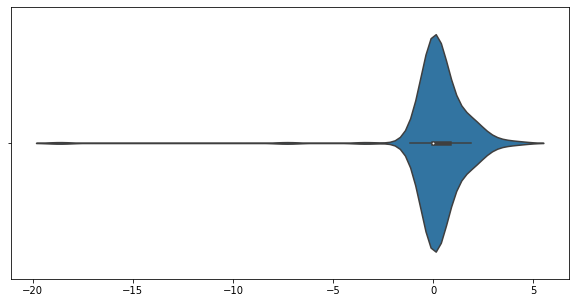

In [241]:
sns.violinplot([lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]
               for w in all_empath_sci_feats])

##### RQ2: Do high +/- arousal words change people's minds?

--> Are comments with deltas more likely to be high arousal?

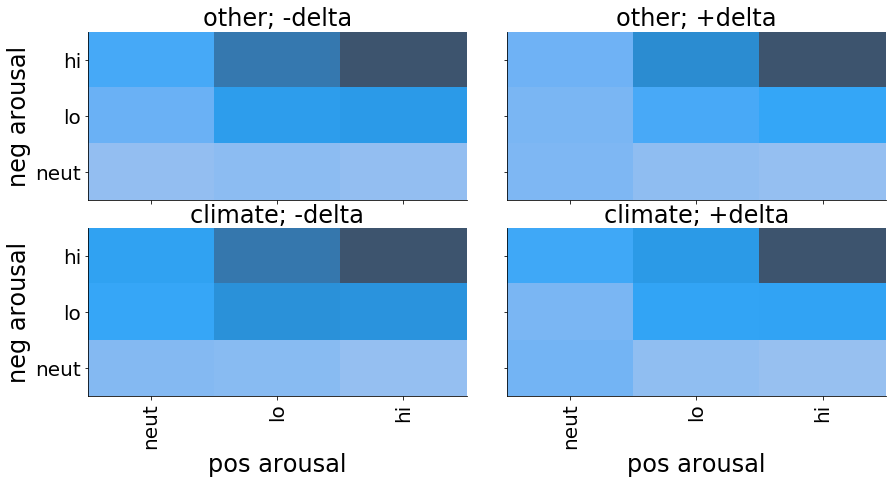

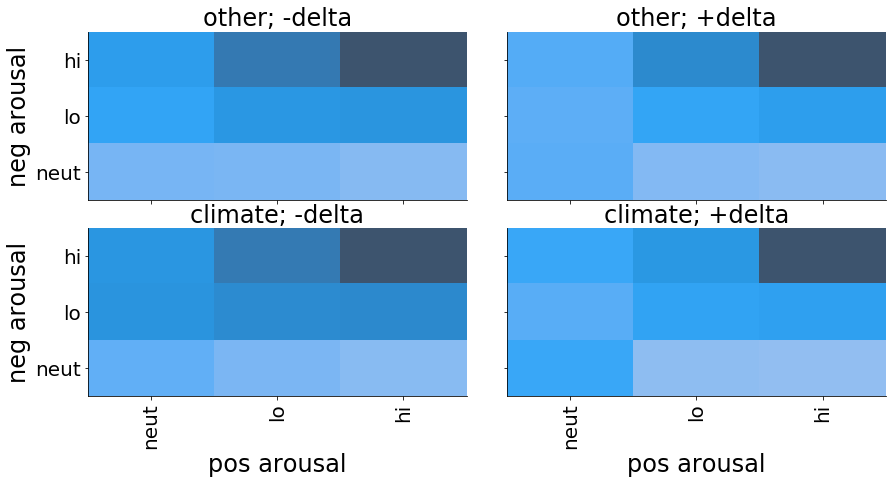

In [113]:
# Fig 4: Distribution of SentiStrength arousal categories for comments
for corp_name in corp_to_analyze:
    if 'cmv' in corp_name:
        # prep data to plot
        to_plot_df = pd.DataFrame({
            'is_awarded_delta': [utt.meta['is_awarded_delta']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat': [utt.meta['senti_all_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat': [utt.meta['senti_adxs_only_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'is_cc_related': [utt.meta['is_cc_related']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                             if utt.meta['senti_all_arousal_cat']]})
        
        SENTI_CATS = to_plot_df['senti_all_arousal_cat'].value_counts().index
        for senti_model in ['all','adxs_only']:
            to_plot_df[f'senti_{senti_model}_arousal_cat'] = \
            pd.Categorical(to_plot_df[f'senti_{senti_model}_arousal_cat'],
                           categories=SENTI_CATS,
                           ordered=True)
        
            # further prepping: isolate +/- SS components
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, f"{senti_model}_pos_arousal", f"{senti_model}_neg_arousal")
            #g.map(sns.histplot, "senti_arousal_cat")

            # aesthetics
            for ax_ix,ax in enumerate(g.axes.ravel()):
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
                if ax_ix % 2 == 0:
                    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
                    ax.set_ylabel("neg arousal",fontsize=24)
                else:
                    ax.set_yticklabels('')
                if ax_ix >= 2:
                    ax.set_xlabel("pos arousal",fontsize=24)

            # saving
            plt.savefig(f'figs/senti_arousal_dist_deltas_vs_no_deltas_{corp_name}_{senti_model}.png',
                       dpi=150,bbox_inches="tight")

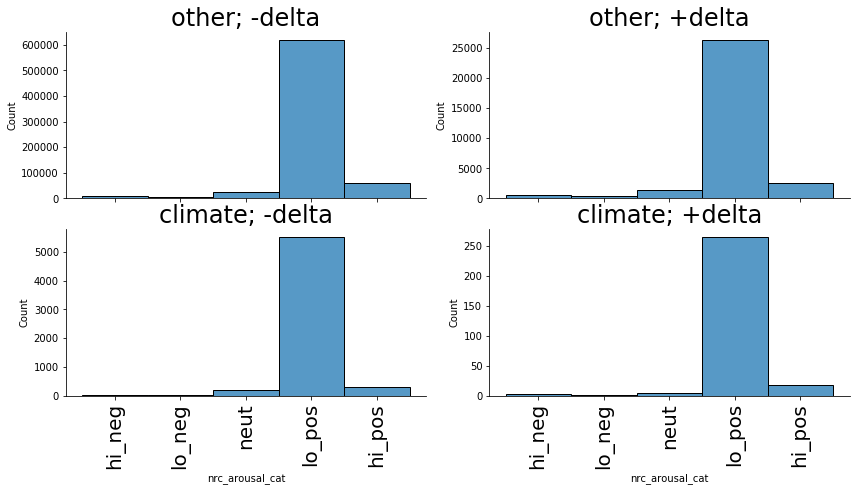

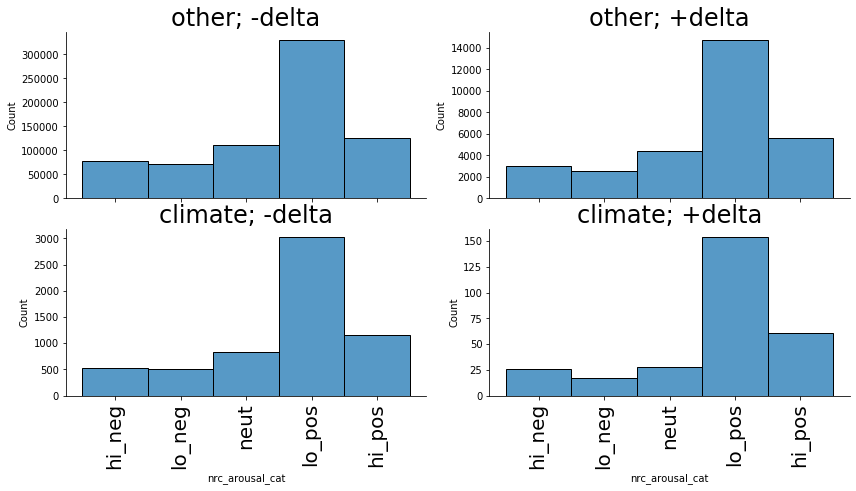

In [116]:
# Fig 5: Distribution of NRC VAD arousal categories for comments
for corp_name in corp_to_analyze:
    if 'cmv' in corp_name:
        for model_name in ['all','adxs_only']:
        
            # prep data to plot
            to_plot_df = pd.DataFrame({
                'is_awarded_delta': [utt.meta['is_awarded_delta']
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'nrc_arousal_cat': [utt.meta[f'nrc_{model_name}_arousal_cat']
                                    for utt in corp_to_analyze[corp_name].iter_utterances()
                                    if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                    and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'is_cc_related': [utt.meta['is_cc_related']
                                  for utt in corp_to_analyze[corp_name].iter_utterances()
                                  if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                  and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            to_plot_df['nrc_arousal_cat'] = \
            pd.Categorical(to_plot_df['nrc_arousal_cat'],
            categories=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, "nrc_arousal_cat")

            # aesthetics
            for ax in g.axes.ravel():
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)

            # saving
            plt.savefig(f'figs/nrc_arousal_dist_deltas_vs_no_deltas_{corp_name}_{model_name}.png',
                       dpi=150,bbox_inches="tight")

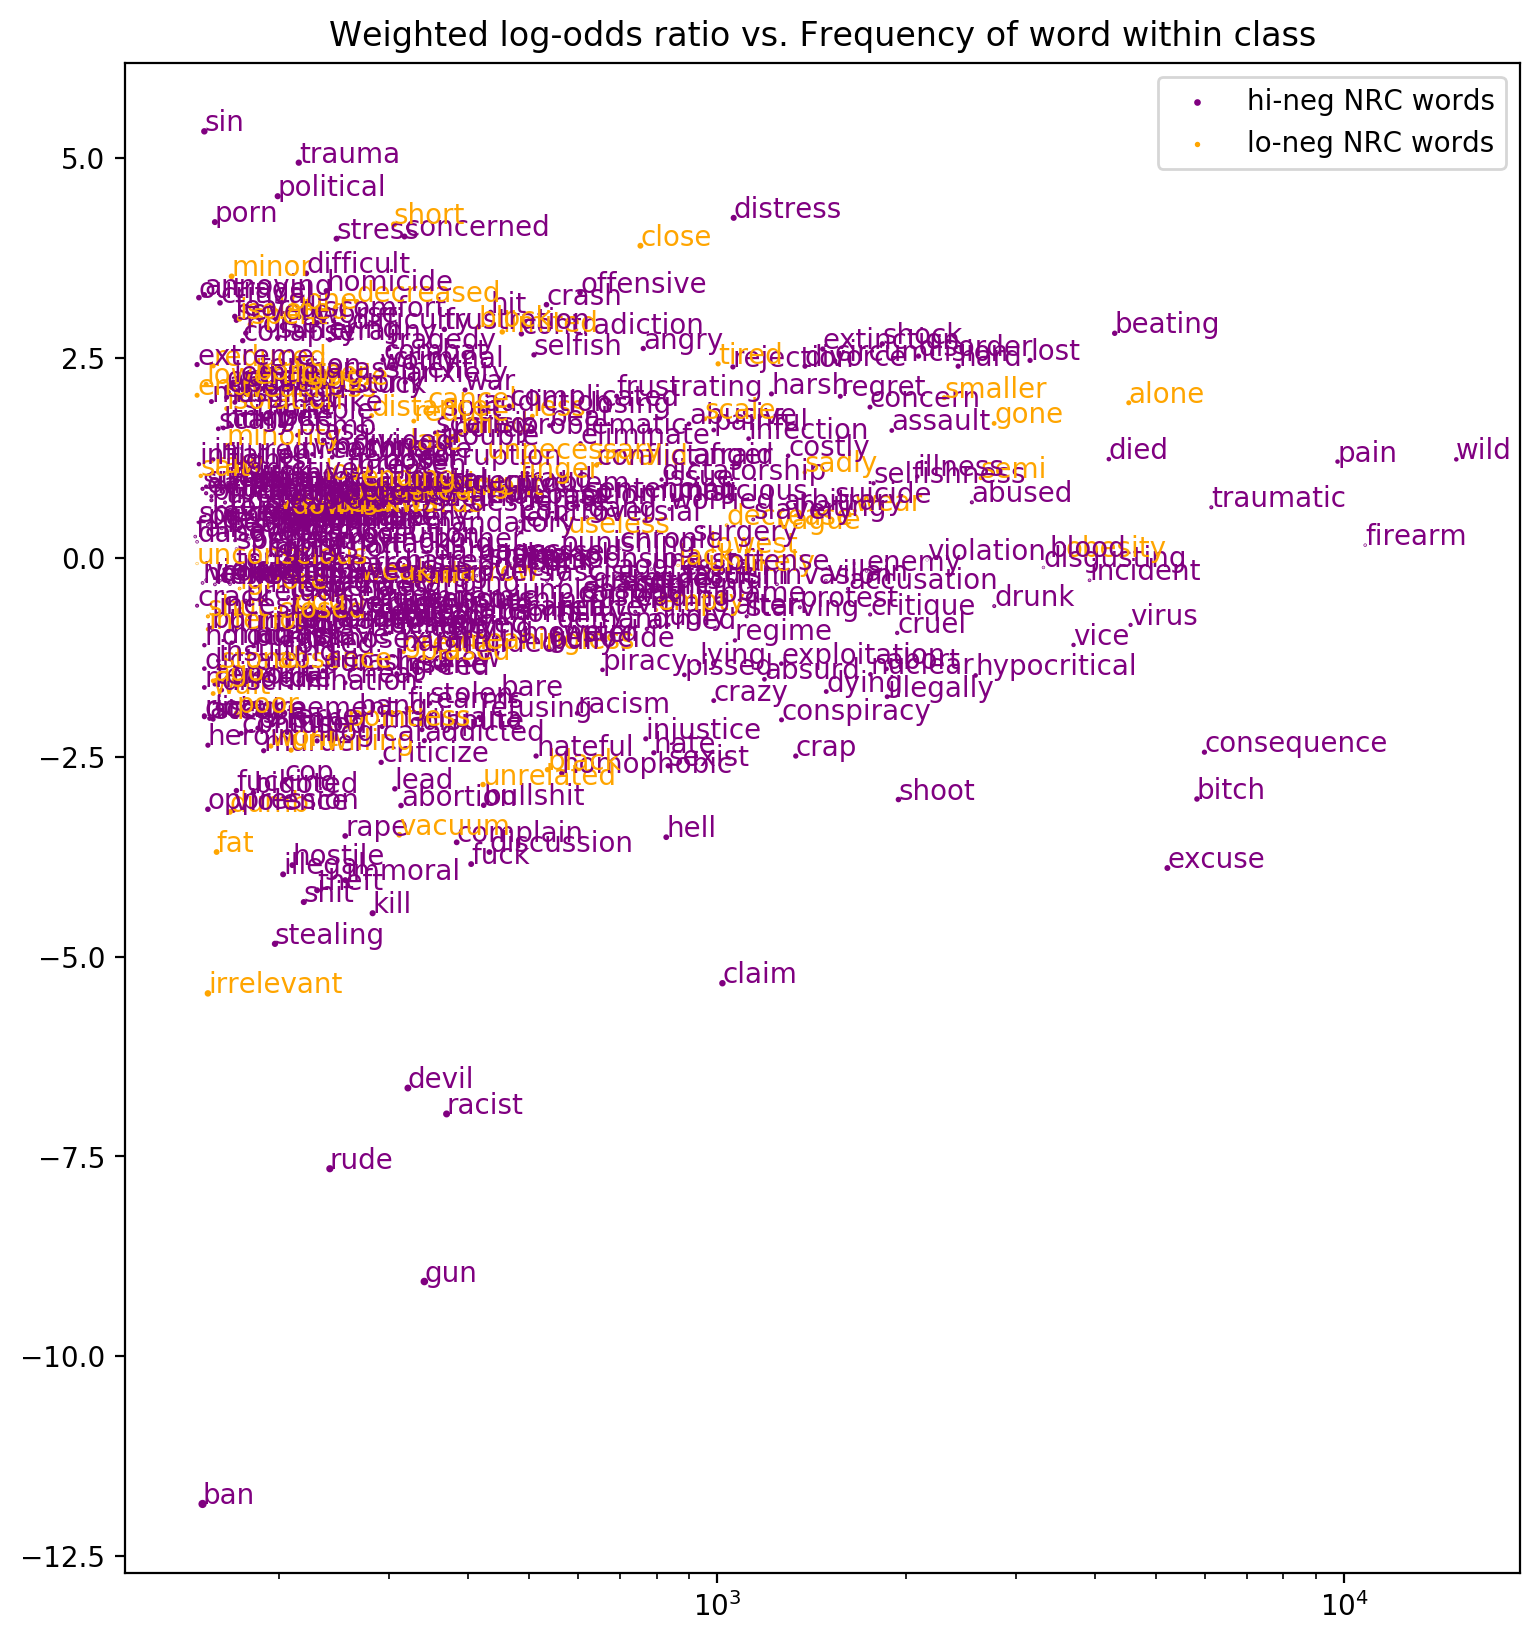

In [32]:
# no annotations of words or non-of-interest words--too crowded
fw_all_topics_no_bots.plot_fighting_words_fancy(class1_name='hi-neg NRC words', 
                                                class2_name='lo-neg NRC words', 
                                 config={'threshold': 1.96, 'annot_method': 'custom'},
                                word_set1=NRC_words_per_cat['hi_neg'],
                                word_set2=NRC_words_per_cat['lo_neg'],
                                verbose=True)

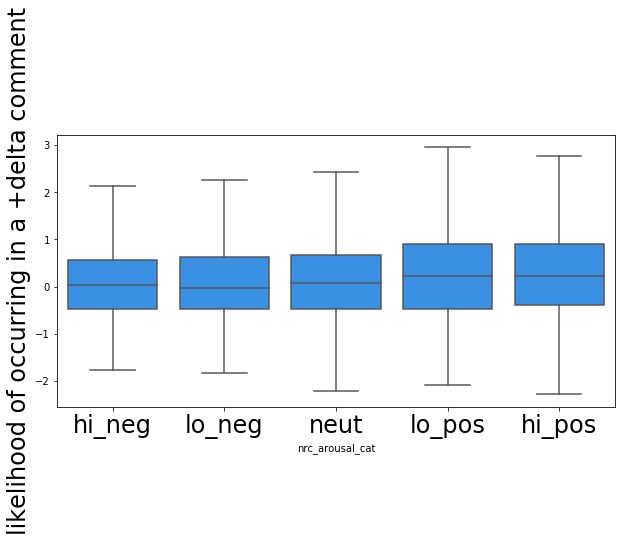

In [211]:
for corp_name in corp_to_analyze:
    #for model_name in ['all','adxs_only']:
    to_plot_df = pd.DataFrame({
        'z-score': [lor_per_corp[corp_name]['weighted_bare'][w]
                    for w in lor_per_corp[corp_name]['weighted_bare']],
        'nrc_arousal_cat': [word2NRC_cat[w]
                            if w in word2NRC_cat else None
                            for w in lor_per_corp[corp_name]['weighted_bare']]
    })
    
    sns.boxplot(data=to_plot_df,
            x='nrc_arousal_cat',y='z-score',
            order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            showfliers=False,color='dodgerblue')
    plt.ylabel("likelihood of occurring in a +delta comment",fontsize=24)
    plt.xticks(fontsize=24)
    plt.savefig(f'figs/lor_per_nrc_arousal_cat_{corp_name}.png',
                dpi=150,bbox_inches="tight")

In [76]:
# Check LOR values for words of derived NRC arousal cats
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-2]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-1]

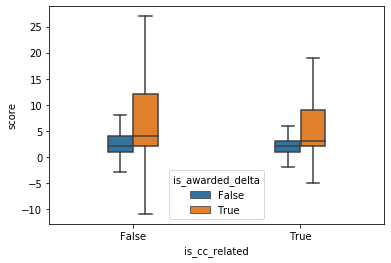

In [51]:
# Is score of a comment related to whether or not it gets a delta?
to_plot_df = pd.DataFrame({
    'is_awarded_delta': [utt.meta['is_awarded_delta']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'score': [utt.meta['score']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'is_cc_related': [utt.meta['is_cc_related']
                        for utt in filtered_cmv_subsample.iter_utterances()]
})

sns.boxplot(data=to_plot_df, x='is_cc_related', y='score', showfliers=False, width=0.3,
           hue='is_awarded_delta')

##### RQ3: Do emotions matter for deltas?

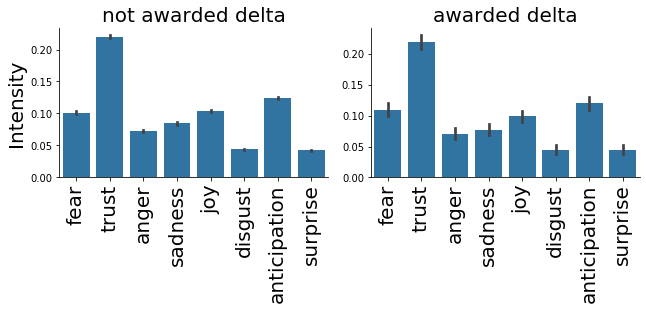

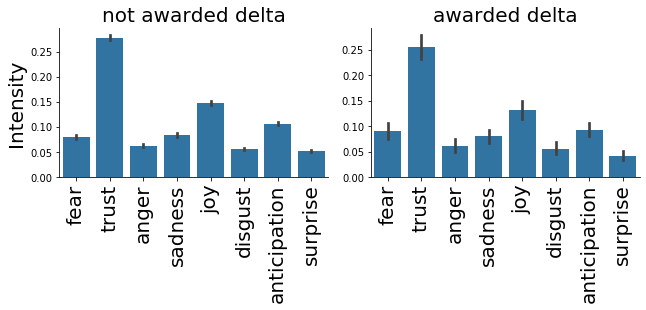

In [142]:
for corp_name in corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            if utt.timestamp and utt.id[:2] != 't3':
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
                for key in utt.meta.keys():
                    if key.startswith(f'emolex_{model_name}'):
                        emo = key.split('_')[-1]
                        score = utt.meta[f'emolex_{model_name}_{emo}']
                        df_year.append(year)
                        df_topic.append(topic)
                        df_emo.append(emo)
                        df_emoscore.append(score)
                        df_id.append(utt.id)
                        df_contro.append(utt.meta['controversiality'])
                        df_replies.append(len(utt.meta['reply_ids']))
                        df_score.append(utt.meta['score'])
                        df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                        senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                        df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                        df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                        df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })

#         g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="emotion", sharey=False, aspect=1.5)
#         g.map(sns.histplot, "emoscore")
        
        g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
        g.map(sns.barplot, "emotion", "emoscore", order=EMOLEX_EMOS)
        for ax_ix,ax in enumerate(g.axes[0]):
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel("")
            if ax_ix == 0:
                ax.set_ylabel("Intensity",fontsize=20)
            ax.set_title("not "[:4*(not (ax.get_title().split(' = ')[-1] == 'True'))] \
                         + "awarded delta",fontsize=20)
        plt.savefig(f'figs/emo_dist_deltas_v_no_deltas_{corp_name}_{model_name}.png',
                    dpi=150,bbox_inches="tight")

# Hypothesis: engaging with opponent is good strategy (agree > disagree chains)

Already tested in other paper and found to be ineffective.

# User-level analysis

In [16]:
# Update speaker-meta w/ cached files
for corp_name in corp_to_analyze:
    user_comments = pickle.load(open(f'{corp_name}_comments_per_speaker.pkl','rb'))
    convo_speaker_ids = [convo.speaker.id for convo in corp_to_analyze[corp_name].iter_utterances()
                            if convo.id[:2]=='t3']

    for speaker_id in tqdm(convo_speaker_ids):
        if speaker_id in user_comments:
            corp_to_analyze[corp_name].get_speaker(speaker_id).add_meta('comments', user_comments[speaker_id])
        else:
            corp_to_analyze[corp_name].get_speaker(speaker_id).add_meta('comments', [])

100%|██████████| 26221/26221 [00:00<00:00, 111098.27it/s]


See if we can use user-subreddit activity as proxy for stance:

Approach 1: R if user comments more in R-leaning subs; same for L.

In [21]:
import praw
from praw.models import Submission
from prawcore.exceptions import Forbidden,NotFound

reddit = praw.Reddit(client_id='ACEORGSlEeJyQhPyNRAUiA',
                     client_secret='xGN33fztXu_4jiOek_RHUtMGhHXAcQ',
                     user_agent='me',
                    password='redditC0bintr@sena',
                    username='Western-Wishbone573')
print(reddit.user.me())

Version 7.4.0 of praw is outdated. Version 7.5.0 was released 1 day ago.


Western-Wishbone573


In [ ]:
for corp_name in corp_to_analyze:
    user_comments = pickle.load(open(f'{corp_name}_comments_per_speaker.pkl','rb'))
    for speaker_id in tqdm(user_comments):
        comment_subs = []
        for c_id in tqdm(user_comments[speaker_id]):
            comment_subs.append(reddit.comment(id=c_id).subreddit.display_name)
        corp_to_analyze[corp_name].get_speaker(speaker_id).add_meta('comment_subs', comment_subs)
        
#sorted(Counter(user_comment_subs).items(),key=lambda x:x[1],reverse=True)

 31%|███       | 309/997 [04:57<11:33,  1.01s/it]


 33%|███▎      | 330/997 [05:18<10:14,  1.09it/s]

In [43]:
len(user_comments[speaker_id])

597

In [42]:
[reddit.comment(id=c_id).subreddit.display_name
                           for c_id in user_comments[speaker_id]]

KeyboardInterrupt: 

In [19]:
for corp_name in corp_to_analyze:
    user_comments = pickle.load(open(f'{corp_name}_comments_per_speaker.pkl','rb'))
    for speaker_id in tqdm(user_comments):
        corp_to_analyze[corp_name].get_speaker(speaker_id).meta['comment_subs']

['RoyalWait', 'EconomistAnonymous']

In [20]:
user_comments['EconomistAnonymous']

['cktrg7f',
 'cktrg5j',
 'cktqf3j',
 'cktpvli',
 'ckpvvu1',
 'ckpucmm',
 'ckptxe4',
 'ckpcuhc',
 'ckpbje8',
 'ckon8ez',
 'ckon8aw',
 'cknoeec',
 'cknluqu',
 'cknlnqa',
 'cknlc7d',
 'cknl6gy',
 'cknl2hj',
 'cknktva']

In [39]:
[reddit.comment(id=c_id).subreddit.display_name
for c_id in user_comments['EconomistAnonymous']]

['changemyview',
 'changemyview',
 'badeconomics',
 'badeconomics',
 'changemyview',
 'badeconomics',
 'changemyview',
 'badeconomics',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview']

In [ ]:
R_subs = {}
L_subs = {}

def get_op_leaning(user_id):
    user_comms = user_comments[user_id]
    user_comm_subs = [x.subreddit.display_name for x in user_comms]
    user_R_subs = [x for x in user_comm_subs if x in R_subs]
    user_L_subs = [x for x in user_comm_subs if x in L_subs]
    if len(user_R_subs) > len(user_L_subs):
        return 'r'
    elif len(user_L_subs) > len(user_R_subs):
        return 'l'
    else:
        return 'n'

# Topic analysis

## Why do "doom people" think we're doomed?